# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import pickle
import random
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv')
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))

    three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
import random
drivingcost_per_mile=0.5
car_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>=1)]
car_trips=car_trips.loc[(car_trips.orig_taz !=car_trips.dest_taz) | (car_trips.trip_counter==1)]
car_transit_trips=car_trips.append(traveler_trips[traveler_trips.tripmode>8])
# car_transit_trips=prd.compare_mode_utlity(car_transit_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
random.seed(100)
car_transit_trips_sample=car_transit_trips[car_transit_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]
car_trips_sample=car_trips[car_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),1000))]

56 57 72


In [19]:
for index, group in traveler_trips.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag','hh_id']).groupby('hh_id'):
    if abs(len(group[group.actual_mode=='Car'])-len(group[group.predicted_mode=='Car']))<10 and len(group)>30:
        print(index,len(group),abs(len(group[group.actual_mode=='Car'])-len(group[group.predicted_mode=='Car'])))

364706 31 1
409288 33 3
483934 31 9
483949 34 2
484003 36 4
484011 34 3
484016 32 1
484018 31 5
484019 31 3
484031 36 6
484546 41 7
484577 34 9
484583 31 6
484700 33 8
527204 36 8
527616 34 2
527698 37 5
527747 46 8
555244 33 3
763802 31 2
831177 34 1
831255 35 0
831284 35 1
831293 33 2
831870 32 4
831871 37 3
831885 32 8
831950 33 4
831970 32 3
867853 31 0
867930 39 7
869078 31 6
869260 31 3
869383 35 7
937957 33 1
937968 36 7
937969 46 5
937977 31 7
937986 32 1
937990 31 0
938467 36 0
938468 31 6
938489 33 0
938491 32 3
938497 32 1
938511 33 6
938514 35 8
938516 31 5
938522 37 1
938523 35 8
938525 39 0
971894 41 4
971900 31 8
971918 40 2
971919 51 6
971933 40 5
971943 33 6
971947 32 4
971948 39 9
971951 31 6
971959 36 9
971970 47 4
971979 37 8
971982 36 1
971988 33 7
971989 39 8
971993 35 1
971998 44 1
972027 48 5
972040 33 8
972041 51 8
972048 33 5
972051 38 1
972053 38 4
972059 36 4
972094 32 5
972096 33 2
972106 32 2
972110 31 4
972111 35 2
972114 35 0
972117 35 5
972118 42 0
9727

2287435 39 9
2287457 31 4
2287460 31 2
2287468 43 8
2287474 40 7
2287478 32 9
2287479 38 9
2287484 34 4
2287487 31 1
2287489 41 5
2287493 34 3
3132077 33 4
3132080 31 2
3132920 32 8
3132925 42 4
3132935 41 1
3409437 34 6
3414010 32 4
3424451 31 3
3424458 38 9
3427430 37 1
3427442 33 9
3427500 39 7
3465015 33 3
3466749 36 1
3467817 39 7
3467826 31 7
3467878 34 1
3469892 32 1
3472015 38 8
3472018 31 5
3472019 38 6
3472020 31 1
3472030 35 8
3472032 31 4
3472040 40 3
3472041 31 2
3472053 31 6
3472056 31 8
3474563 38 8
3474566 35 3
3474591 46 6
3474595 47 6
3474712 33 1


In [12]:
car_transit_trips.groupby('actual_mode').count()

,Unnamed: 0,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,...,Diff_bet_starttime,travel_time,person_type,earlyarr_penalty,latearr_penalty,early_penalty_threshold,late_penalty_threshold,transit_utility,car_utility,predicted_mode
actual_mode,,,,,,,,,,,,,,,,,,,,,
Car,180011,180011,180011,180011,180011,180011,180011,180011,180011,180011,...,180011,180011,180011,180011,180011,180011,180011,180011,180011,180011
NonCar,12178,12178,12178,12178,12178,12178,12178,12178,12178,12178,...,12178,12178,12178,12178,12178,12178,12178,12178,12178,12178


In [51]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
route_info_modechoice07,darp_solutions_modechoice07=\
sod.get_route_info_allhh(car_transit_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Estimate Route for the  0 th household  2018-07-17 05:02:54.850152
1 7 2018-07-17 05:02:55.217172
2 12 2018-07-17 05:02:55.941224
3 9 2018-07-17 05:02:56.464261
4 14 2018-07-17 05:02:58.306395
5 2 2018-07-17 05:02:58.453399
6 20 2018-07-17 05:03:00.098515
7 2 2018-07-17 05:03:00.246525
8 12 2018-07-17 05:03:01.017584
9 13 2018-07-17 05:03:02.014650
10 13 2018-07-17 05:03:02.674694
11 6 2018-07-17 05:03:02.981717
12 10 2018-07-17 05:03:03.606763
13 13 2018-07-17 05:03:04.520826
14 3 2018-07-17 05:03:04.684837
15 7 2018-07-17 05:03:05.001859
16 7 2018-07-17 05:03:05.378884
17 11 2018-07-17 05:03:06.016932
18 18 2018-07-17 05:03:07.420026
19 8 2018-07-17 05:03:07.940063
20 12 2018-07-17 05:03:08.658114
21 11 2018-07-17 05:03:09.262157
22 8 2018-07-17 05:03:09.631182
23 10 2018-07-17 05:03:10.217221
24 15 2018-07-17 05:03:11.232299
25 5 2018-07-17 05:03:11.463309
26 13 2018-07-17 05:03:12.187360
27 5 2018-07-17 05:03:12.438378
28 8 2018-07-17 05:03:12.791403
29 4 2018-07-17 05:03:13.015418

244 11 2018-07-17 05:05:58.785012
245 4 2018-07-17 05:05:59.052030
246 4 2018-07-17 05:05:59.264045
247 8 2018-07-17 05:05:59.602068
248 6 2018-07-17 05:05:59.869087
249 12 2018-07-17 05:06:00.618142
250 9 2018-07-17 05:06:01.144178
251 6 2018-07-17 05:06:01.416196
252 12 2018-07-17 05:06:01.996236
253 20 2018-07-17 05:06:10.444826
254 9 2018-07-17 05:06:10.831853
255 13 2018-07-17 05:06:11.836925
256 7 2018-07-17 05:06:12.557975
257 4 2018-07-17 05:06:12.736993
258 12 2018-07-17 05:06:13.345035
259 8 2018-07-17 05:06:13.757059
260 10 2018-07-17 05:06:14.371101
261 8 2018-07-17 05:06:14.749128
262 7 2018-07-17 05:06:15.000146
263 3 2018-07-17 05:06:15.163156
264 21 2018-07-17 05:06:16.613264
265 7 2018-07-17 05:06:16.906279
266 10 2018-07-17 05:06:17.569325
267 3 2018-07-17 05:06:17.807342
268 2 2018-07-17 05:06:17.972353
269 10 2018-07-17 05:06:18.429385
270 9 2018-07-17 05:06:18.731407
271 7 2018-07-17 05:06:19.092431
272 11 2018-07-17 05:06:19.529468
273 10 2018-07-17 05:06:20.02849

486 12 2018-07-17 05:08:38.167382
487 10 2018-07-17 05:08:38.780423
488 4 2018-07-17 05:08:38.992435
489 5 2018-07-17 05:08:39.240449
490 7 2018-07-17 05:08:39.570470
491 8 2018-07-17 05:08:39.960495
492 3 2018-07-17 05:08:40.144506
493 5 2018-07-17 05:08:40.354519
494 7 2018-07-17 05:08:40.727543
495 7 2018-07-17 05:08:41.144569
496 5 2018-07-17 05:08:41.412588
497 14 2018-07-17 05:08:42.651671
498 5 2018-07-17 05:08:42.918683
499 10 2018-07-17 05:08:43.315708
500 3 2018-07-17 05:08:43.458717
Estimate Route for the  500 th household  2018-07-17 05:08:43.464718
501 13 2018-07-17 05:08:44.782807
502 3 2018-07-17 05:08:44.921809
503 12 2018-07-17 05:08:45.581850
504 9 2018-07-17 05:08:45.901871
505 9 2018-07-17 05:08:46.362900
506 6 2018-07-17 05:08:46.626917
507 8 2018-07-17 05:08:47.037943
508 8 2018-07-17 05:08:47.340963
509 5 2018-07-17 05:08:47.574978
510 8 2018-07-17 05:08:47.956002
511 5 2018-07-17 05:08:48.241022
512 6 2018-07-17 05:08:48.498035
513 5 2018-07-17 05:08:48.725056
5

726 5 2018-07-17 05:10:48.928671
727 9 2018-07-17 05:10:49.288693
728 6 2018-07-17 05:10:49.570711
729 4 2018-07-17 05:10:49.743722
730 7 2018-07-17 05:10:50.108746
731 6 2018-07-17 05:10:50.376762
732 6 2018-07-17 05:10:50.628784
733 4 2018-07-17 05:10:50.831791
734 6 2018-07-17 05:10:51.128811
735 3 2018-07-17 05:10:51.285826
736 13 2018-07-17 05:10:52.992934
737 4 2018-07-17 05:10:53.171940
738 6 2018-07-17 05:10:53.439956
739 8 2018-07-17 05:10:53.864984
740 4 2018-07-17 05:10:54.043997
741 11 2018-07-17 05:10:54.424019
742 6 2018-07-17 05:10:54.722038
743 3 2018-07-17 05:10:54.886048
744 13 2018-07-17 05:10:55.488087
745 6 2018-07-17 05:10:55.754105
746 7 2018-07-17 05:10:56.065123
747 3 2018-07-17 05:10:56.204132
748 2 2018-07-17 05:10:56.356141
749 8 2018-07-17 05:10:56.707164
750 9 2018-07-17 05:10:57.218197
751 9 2018-07-17 05:10:57.534216
752 5 2018-07-17 05:10:57.708233
753 6 2018-07-17 05:10:58.065250
754 14 2018-07-17 05:10:58.896303
755 2 2018-07-17 05:10:59.045313
756 7 

971 6 2018-07-17 05:12:36.327107
972 3 2018-07-17 05:12:36.493116
973 4 2018-07-17 05:12:36.679127
974 4 2018-07-17 05:12:36.827136
975 4 2018-07-17 05:12:37.011145
976 4 2018-07-17 05:12:37.254160
977 7 2018-07-17 05:12:37.594178
978 7 2018-07-17 05:12:37.911198
979 6 2018-07-17 05:12:38.172212
980 8 2018-07-17 05:12:38.584235
981 5 2018-07-17 05:12:38.764246
982 9 2018-07-17 05:12:39.134272
983 4 2018-07-17 05:12:39.431283
984 2 2018-07-17 05:12:39.583292
985 11 2018-07-17 05:12:40.423346
986 9 2018-07-17 05:12:40.739357
987 8 2018-07-17 05:12:41.137380
988 4 2018-07-17 05:12:41.310389
989 4 2018-07-17 05:12:41.547404
990 7 2018-07-17 05:12:41.832421
991 2 2018-07-17 05:12:41.980428
992 10 2018-07-17 05:12:42.501459
993 8 2018-07-17 05:12:42.878481
994 2 2018-07-17 05:12:43.031488
995 12 2018-07-17 05:12:43.466515
996 5 2018-07-17 05:12:43.690525
997 6 2018-07-17 05:12:43.972543
998 9 2018-07-17 05:12:44.509572
999 4 2018-07-17 05:12:44.692588
1000 14 2018-07-17 05:12:47.015715
Estim

1206 8 2018-07-17 05:14:43.435874
1207 3 2018-07-17 05:14:43.624884
1208 3 2018-07-17 05:14:43.802894
1209 7 2018-07-17 05:14:44.218914
1210 7 2018-07-17 05:14:44.757942
1211 13 2018-07-17 05:14:45.316970
1212 2 2018-07-17 05:14:45.465977
1213 4 2018-07-17 05:14:45.679988
1214 4 2018-07-17 05:14:45.864999
1215 10 2018-07-17 05:14:46.243023
1216 18 2018-07-17 05:14:48.614136
1217 10 2018-07-17 05:14:48.916152
1218 4 2018-07-17 05:14:49.090161
1219 7 2018-07-17 05:14:49.621193
1220 4 2018-07-17 05:14:49.804197
1221 11 2018-07-17 05:14:50.484231
1222 2 2018-07-17 05:14:50.633240
1223 4 2018-07-17 05:14:50.827249
1224 6 2018-07-17 05:14:51.149264
1225 10 2018-07-17 05:14:52.005310
1226 7 2018-07-17 05:14:52.309325
1227 4 2018-07-17 05:14:52.554337
1228 15 2018-07-17 05:14:53.618396
1229 4 2018-07-17 05:14:53.792399
1230 8 2018-07-17 05:14:54.163418
1231 2 2018-07-17 05:14:54.310425
1232 2 2018-07-17 05:14:54.459433
1233 10 2018-07-17 05:14:55.221472
1234 11 2018-07-17 05:14:56.077516
1235 

1442 7 2018-07-17 05:16:18.214679
1443 13 2018-07-17 05:16:19.378739
1444 4 2018-07-17 05:16:19.621750
1445 11 2018-07-17 05:16:20.776810
1446 5 2018-07-17 05:16:21.112825
1447 10 2018-07-17 05:16:21.599850
1448 5 2018-07-17 05:16:21.890865
1449 4 2018-07-17 05:16:22.069874
1450 18 2018-07-17 05:16:23.234940
1451 11 2018-07-17 05:16:23.685958
1452 3 2018-07-17 05:16:23.850965
1453 6 2018-07-17 05:16:24.111979
1454 8 2018-07-17 05:16:24.479996
1455 11 2018-07-17 05:16:25.076027
1456 10 2018-07-17 05:16:25.592057
1457 8 2018-07-17 05:16:25.950071
1458 2 2018-07-17 05:16:26.099078
1459 2 2018-07-17 05:16:26.249085
1460 1 2018-07-17 05:16:26.355093
1461 6 2018-07-17 05:16:26.611105
1462 2 2018-07-17 05:16:26.760112
1463 4 2018-07-17 05:16:26.945122
1464 10 2018-07-17 05:16:27.317143
1465 8 2018-07-17 05:16:27.605159
1466 13 2018-07-17 05:16:29.125238
1467 2 2018-07-17 05:16:29.279240
1468 2 2018-07-17 05:16:29.441248
1469 6 2018-07-17 05:16:29.723262
1470 7 2018-07-17 05:16:30.024277
1471 

1678 2 2018-07-17 05:17:36.037623
1679 8 2018-07-17 05:17:36.400642
1680 7 2018-07-17 05:17:36.718659
1681 7 2018-07-17 05:17:37.027674
1682 16 2018-07-17 05:17:37.818719
1683 12 2018-07-17 05:17:38.318740
1684 3 2018-07-17 05:17:38.487749
1685 8 2018-07-17 05:17:38.874768
1686 8 2018-07-17 05:17:39.208785
1687 6 2018-07-17 05:17:39.483798
1688 4 2018-07-17 05:17:39.686808
1689 9 2018-07-17 05:17:40.094830
1690 12 2018-07-17 05:17:41.054878
1691 7 2018-07-17 05:17:41.362893
1692 1 2018-07-17 05:17:41.469898
1693 7 2018-07-17 05:17:41.841918
1694 2 2018-07-17 05:17:41.991926
1695 4 2018-07-17 05:17:42.146933
1696 6 2018-07-17 05:17:42.451948
1697 5 2018-07-17 05:17:42.721963
1698 2 2018-07-17 05:17:42.881971
1699 6 2018-07-17 05:17:43.496002
1700 6 2018-07-17 05:17:43.809018
Estimate Route for the  1700 th household  2018-07-17 05:17:43.820019
1701 2 2018-07-17 05:17:43.968026
1702 7 2018-07-17 05:17:44.251046
1703 4 2018-07-17 05:17:44.438049
1704 2 2018-07-17 05:17:44.596057
1705 3 20

1913 2 2018-07-17 05:19:04.762341
1914 3 2018-07-17 05:19:04.903349
1915 7 2018-07-17 05:19:05.189366
1916 1 2018-07-17 05:19:05.296372
1917 8 2018-07-17 05:19:05.559387
1918 9 2018-07-17 05:19:05.857404
1919 2 2018-07-17 05:19:06.007412
1920 3 2018-07-17 05:19:06.162421
1921 11 2018-07-17 05:19:06.629448
1922 3 2018-07-17 05:19:06.818464
1923 5 2018-07-17 05:19:07.165478
1924 5 2018-07-17 05:19:07.398491
1925 2 2018-07-17 05:19:07.500497
1926 8 2018-07-17 05:19:07.749511
1927 13 2018-07-17 05:19:08.397550
1928 16 2018-07-17 05:19:09.699629
1929 4 2018-07-17 05:19:09.904634
1930 3 2018-07-17 05:19:10.057643
1931 3 2018-07-17 05:19:10.211651
1932 6 2018-07-17 05:19:10.481667
1933 2 2018-07-17 05:19:10.604674
1934 5 2018-07-17 05:19:10.897690
1935 9 2018-07-17 05:19:11.306719
1936 2 2018-07-17 05:19:11.456728
1937 9 2018-07-17 05:19:11.806742
1938 2 2018-07-17 05:19:11.957751
1939 3 2018-07-17 05:19:12.122761
1940 9 2018-07-17 05:19:12.611788
1941 4 2018-07-17 05:19:12.790798
1942 4 2018

2149 8 2018-07-17 05:20:31.266260
2150 4 2018-07-17 05:20:31.456270
2151 2 2018-07-17 05:20:31.608279
2152 2 2018-07-17 05:20:31.740292
2153 2 2018-07-17 05:20:31.896296
2154 2 2018-07-17 05:20:32.047304
2155 18 2018-07-17 05:20:32.832348
2156 7 2018-07-17 05:20:33.190369
2157 5 2018-07-17 05:20:33.434383
2158 6 2018-07-17 05:20:33.743401
2159 7 2018-07-17 05:20:34.048418
2160 3 2018-07-17 05:20:34.208426
2161 8 2018-07-17 05:20:34.516444
2162 10 2018-07-17 05:20:35.048478
2163 8 2018-07-17 05:20:35.310492
2164 4 2018-07-17 05:20:35.557505
2165 5 2018-07-17 05:20:35.824519
2166 2 2018-07-17 05:20:35.977527
2167 4 2018-07-17 05:20:36.135537
2168 3 2018-07-17 05:20:36.281545
2169 7 2018-07-17 05:20:36.592562
2170 10 2018-07-17 05:20:37.337605
2171 2 2018-07-17 05:20:37.490614
2172 2 2018-07-17 05:20:37.646623
2173 7 2018-07-17 05:20:37.957640
2174 10 2018-07-17 05:20:38.508671
2175 6 2018-07-17 05:20:38.696682
2176 9 2018-07-17 05:20:39.067709
2177 6 2018-07-17 05:20:39.318717
2178 14 20

2387 4 2018-07-17 05:21:40.319185
2388 9 2018-07-17 05:21:40.676205
2389 4 2018-07-17 05:21:40.853215
2390 13 2018-07-17 05:21:42.996340
2391 3 2018-07-17 05:21:43.151347
2392 2 2018-07-17 05:21:43.306355
2393 4 2018-07-17 05:21:43.524368
2394 5 2018-07-17 05:21:43.696377
2395 10 2018-07-17 05:21:44.024396
2396 4 2018-07-17 05:21:44.220407
2397 6 2018-07-17 05:21:44.491422
2398 3 2018-07-17 05:21:44.635436
2399 6 2018-07-17 05:21:44.866445
2400 5 2018-07-17 05:21:45.098457
Estimate Route for the  2400 th household  2018-07-17 05:21:45.111458
2401 4 2018-07-17 05:21:45.311470
2402 3 2018-07-17 05:21:45.478478
2403 3 2018-07-17 05:21:45.643488
2404 4 2018-07-17 05:21:45.826499
2405 6 2018-07-17 05:21:46.100514
2406 2 2018-07-17 05:21:46.253523
2407 2 2018-07-17 05:21:46.408531
2408 3 2018-07-17 05:21:46.573542
2409 5 2018-07-17 05:21:46.855557
2410 11 2018-07-17 05:21:47.299581
2411 2 2018-07-17 05:21:47.452596
2412 4 2018-07-17 05:21:47.652602
2413 6 2018-07-17 05:21:47.870619
2414 10 2

2622 4 2018-07-17 05:22:43.887802
2623 7 2018-07-17 05:22:44.188818
2624 2 2018-07-17 05:22:44.318824
2625 4 2018-07-17 05:22:44.560838
2626 4 2018-07-17 05:22:44.744848
2627 5 2018-07-17 05:22:44.980862
2628 6 2018-07-17 05:22:45.247877
2629 2 2018-07-17 05:22:45.378884
2630 4 2018-07-17 05:22:45.565895
2631 2 2018-07-17 05:22:45.718903
2632 5 2018-07-17 05:22:45.961916
2633 4 2018-07-17 05:22:46.151928
2634 5 2018-07-17 05:22:46.348939
2635 7 2018-07-17 05:22:47.075981
2636 2 2018-07-17 05:22:47.235990
2637 6 2018-07-17 05:22:47.502005
2638 4 2018-07-17 05:22:47.687016
2639 2 2018-07-17 05:22:47.842023
2640 9 2018-07-17 05:22:48.159043
2641 4 2018-07-17 05:22:48.369054
2642 13 2018-07-17 05:22:48.842081
2643 2 2018-07-17 05:22:48.996089
2644 3 2018-07-17 05:22:49.151099
2645 5 2018-07-17 05:22:49.388112
2646 3 2018-07-17 05:22:49.552121
2647 5 2018-07-17 05:22:49.771135
2648 5 2018-07-17 05:22:49.963145
2649 7 2018-07-17 05:22:50.353169
2650 2 2018-07-17 05:22:50.490175
2651 3 2018-0

2860 4 2018-07-17 05:23:29.532394
2861 1 2018-07-17 05:23:29.642400
2862 2 2018-07-17 05:23:29.795409
2863 4 2018-07-17 05:23:30.010421
2864 1 2018-07-17 05:23:30.120427
2865 2 2018-07-17 05:23:30.275437
2866 4 2018-07-17 05:23:30.474447
2867 3 2018-07-17 05:23:30.626456
2868 2 2018-07-17 05:23:30.778464
2869 2 2018-07-17 05:23:30.933474
2870 4 2018-07-17 05:23:31.178487
2871 5 2018-07-17 05:23:31.449503
2872 5 2018-07-17 05:23:31.636513
2873 2 2018-07-17 05:23:31.749521
2874 2 2018-07-17 05:23:31.901529
2875 2 2018-07-17 05:23:32.056537
2876 4 2018-07-17 05:23:32.262550
2877 4 2018-07-17 05:23:32.481561
2878 1 2018-07-17 05:23:32.590568
2879 2 2018-07-17 05:23:32.745576
2880 3 2018-07-17 05:23:32.898590
2881 3 2018-07-17 05:23:33.056596
2882 2 2018-07-17 05:23:33.186602
2883 2 2018-07-17 05:23:33.344610
2884 2 2018-07-17 05:23:33.497619
2885 2 2018-07-17 05:23:33.653629
2886 2 2018-07-17 05:23:33.807638
2887 3 2018-07-17 05:23:33.951645
2888 2 2018-07-17 05:23:34.103655
2889 3 2018-07

In [9]:
len(route_info_modechoice07)

22615

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
route_info_modechoice07,darp_solutions_modechoice07=\
sod.get_route_info_allhh(car_transit_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

In [52]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_modechoice08,darp_solutions_modechoice08=\
sod.get_route_info_allhh(car_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)

Estimate Route for the  0 th household  2018-07-17 10:13:34.627185
1 18 2018-07-17 10:13:36.012260
2 7 2018-07-17 10:13:36.342279
3 5 2018-07-17 10:13:36.650303
4 5 2018-07-17 10:13:36.936313
5 5 2018-07-17 10:13:37.219329
6 8 2018-07-17 10:13:37.609351
7 8 2018-07-17 10:13:37.969371
8 11 2018-07-17 10:13:38.588406
9 11 2018-07-17 10:13:39.299448
10 7 2018-07-17 10:13:39.633465
11 6 2018-07-17 10:13:39.912482
12 8 2018-07-17 10:13:40.274503
13 9 2018-07-17 10:13:40.902538
14 5 2018-07-17 10:13:41.178553
15 9 2018-07-17 10:13:41.690583
16 11 2018-07-17 10:13:42.271616
17 9 2018-07-17 10:13:42.719641
18 5 2018-07-17 10:13:42.988656
19 18 2018-07-17 10:13:44.232733
20 11 2018-07-17 10:13:45.062774
21 10 2018-07-17 10:13:45.736813
22 13 2018-07-17 10:13:47.014891
23 17 2018-07-17 10:13:49.177010
24 2 2018-07-17 10:13:49.324023
25 9 2018-07-17 10:13:49.779042
26 8 2018-07-17 10:13:50.118063
27 11 2018-07-17 10:13:51.090117
28 2 2018-07-17 10:13:51.240125
29 9 2018-07-17 10:13:51.664149
30 1

244 6 2018-07-17 10:15:34.680007
245 2 2018-07-17 10:15:34.831015
246 6 2018-07-17 10:15:35.053029
247 16 2018-07-17 10:15:35.909079
248 6 2018-07-17 10:15:36.163090
249 9 2018-07-17 10:15:36.654121
250 4 2018-07-17 10:15:36.803128
251 6 2018-07-17 10:15:37.067142
252 6 2018-07-17 10:15:37.283154
253 3 2018-07-17 10:15:37.427162
254 7 2018-07-17 10:15:37.664180
255 12 2018-07-17 10:15:38.732239
256 16 2018-07-17 10:15:39.459277
257 5 2018-07-17 10:15:39.722292
258 1 2018-07-17 10:15:39.829299
259 7 2018-07-17 10:15:40.208321
260 14 2018-07-17 10:15:40.934368
261 2 2018-07-17 10:15:41.078370
262 5 2018-07-17 10:15:41.272380
263 4 2018-07-17 10:15:41.449391
264 8 2018-07-17 10:15:41.783410
265 10 2018-07-17 10:15:42.535454
266 12 2018-07-17 10:15:43.077484
267 3 2018-07-17 10:15:43.236492
268 6 2018-07-17 10:15:43.504508
269 5 2018-07-17 10:15:43.723522
270 10 2018-07-17 10:15:44.066540
271 4 2018-07-17 10:15:44.244550
272 2 2018-07-17 10:15:44.389558
273 4 2018-07-17 10:15:44.606570
274

488 4 2018-07-17 10:17:09.285384
489 4 2018-07-17 10:17:09.503397
490 15 2018-07-17 10:17:10.203438
491 9 2018-07-17 10:17:10.866475
492 10 2018-07-17 10:17:11.930537
493 10 2018-07-17 10:17:12.554571
494 6 2018-07-17 10:17:12.829587
495 10 2018-07-17 10:17:13.280614
496 3 2018-07-17 10:17:13.441621
497 5 2018-07-17 10:17:13.632632
498 6 2018-07-17 10:17:13.868645
499 2 2018-07-17 10:17:14.014659
500 9 2018-07-17 10:17:14.643689
Estimate Route for the  500 th household  2018-07-17 10:17:14.648690
501 4 2018-07-17 10:17:14.839701
502 2 2018-07-17 10:17:14.985708
503 7 2018-07-17 10:17:15.223722
504 4 2018-07-17 10:17:15.391737
505 7 2018-07-17 10:17:15.651746
506 4 2018-07-17 10:17:15.843757
507 4 2018-07-17 10:17:16.045770
508 6 2018-07-17 10:17:16.308784
509 7 2018-07-17 10:17:16.675806
510 8 2018-07-17 10:17:16.945820
511 5 2018-07-17 10:17:17.156832
512 3 2018-07-17 10:17:17.319841
513 2 2018-07-17 10:17:17.469850
514 4 2018-07-17 10:17:17.699863
515 9 2018-07-17 10:17:18.519910
516

730 5 2018-07-17 10:18:23.453643
731 5 2018-07-17 10:18:23.656656
732 9 2018-07-17 10:18:24.083683
733 11 2018-07-17 10:18:24.765731
734 2 2018-07-17 10:18:24.917736
735 6 2018-07-17 10:18:25.149751
736 4 2018-07-17 10:18:25.321767
737 2 2018-07-17 10:18:25.466771
738 6 2018-07-17 10:18:25.694785
739 4 2018-07-17 10:18:25.895799
740 8 2018-07-17 10:18:26.259827
741 15 2018-07-17 10:18:28.881988
742 2 2018-07-17 10:18:29.037997
743 3 2018-07-17 10:18:29.184007
744 4 2018-07-17 10:18:29.369018
745 8 2018-07-17 10:18:29.806052
746 3 2018-07-17 10:18:29.963056
747 4 2018-07-17 10:18:30.112065
748 2 2018-07-17 10:18:30.261075
749 1 2018-07-17 10:18:30.366081
750 5 2018-07-17 10:18:30.635099
751 4 2018-07-17 10:18:30.772112
752 2 2018-07-17 10:18:30.929117
753 7 2018-07-17 10:18:31.138131
754 2 2018-07-17 10:18:31.290146
755 4 2018-07-17 10:18:31.523156
756 2 2018-07-17 10:18:31.670169
757 4 2018-07-17 10:18:31.870177
758 5 2018-07-17 10:18:32.167196
759 4 2018-07-17 10:18:32.385210
760 2 20

In [53]:
print(datetime.datetime.now())
num_shared_ride_dict={}
total_number_shared_rides=0
for group1, group2 in zip(route_info_modechoice08.groupby(['hh_id']),car_trips_sample.groupby(['hh_id'])):
    temp=group1[1]
    num_shared_ride=len(temp[(temp.orig_node_index<len(group2[1]) &(temp.dest_node_index<len(group2[1])))])
    num_shared_ride_dict[group1[0]]=num_shared_ride
    total_number_shared_rides+=num_shared_ride
print(datetime.datetime.now())

2018-07-17 10:19:42.844676
2018-07-17 10:19:44.545784


In [54]:
num_shared_ride

0

In [ ]:
run_name='modechoice_newutility'
route_info

In [63]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=2
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_allcar2av,darp_solutions_allcar2av=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)

Estimate Route for the  0 th household  2018-07-16 08:47:49.604781
1 9 2018-07-16 08:47:50.241819
2 14 2018-07-16 08:47:52.732965
3 13 2018-07-16 08:47:54.643082
4 25 2018-07-16 08:47:58.146284
5 9 2018-07-16 08:47:58.769320
6 6 2018-07-16 08:47:59.049337
7 8 2018-07-16 08:47:59.586368
8 9 2018-07-16 08:48:00.244408
9 8 2018-07-16 08:48:00.928448
10 7 2018-07-16 08:48:01.568485
11 11 2018-07-16 08:48:02.913567
12 12 2018-07-16 08:48:04.620665
13 4 2018-07-16 08:48:04.891681
14 6 2018-07-16 08:48:05.211699
15 13 2018-07-16 08:48:06.166761
16 14 2018-07-16 08:48:07.783850
17 11 2018-07-16 08:48:08.808911
18 8 2018-07-16 08:48:09.412946
19 6 2018-07-16 08:48:09.658960
20 5 2018-07-16 08:48:10.018982
21 6 2018-07-16 08:48:10.271996
22 10 2018-07-16 08:48:10.748024
23 15 2018-07-16 08:48:13.584191
24 18 2018-07-16 08:48:17.981450
25 14 2018-07-16 08:48:20.484597
26 6 2018-07-16 08:48:20.808616
27 9 2018-07-16 08:48:21.890680
28 6 2018-07-16 08:48:22.188697
29 5 2018-07-16 08:48:22.431711
30

243 13 2018-07-16 08:53:59.088499
244 21 2018-07-16 08:54:03.640772
245 14 2018-07-16 08:54:04.944843
246 10 2018-07-16 08:54:05.891898
247 8 2018-07-16 08:54:06.481933
248 9 2018-07-16 08:54:06.881957
249 10 2018-07-16 08:54:07.735007
250 12 2018-07-16 08:54:09.827135
251 20 2018-07-16 08:54:14.559414
252 27 2018-07-16 08:54:19.521701
253 2 2018-07-16 08:54:19.726711
254 20 2018-07-16 08:54:24.109974
255 4 2018-07-16 08:54:24.503992
256 16 2018-07-16 08:54:27.884191
257 11 2018-07-16 08:54:28.770245
258 13 2018-07-16 08:54:31.627411
259 8 2018-07-16 08:54:32.206445
260 10 2018-07-16 08:54:33.110498
261 26 2018-07-16 08:54:57.059906
262 25 2018-07-16 08:55:34.724120
263 11 2018-07-16 08:55:35.519166
264 2 2018-07-16 08:55:35.713184
265 11 2018-07-16 08:55:36.584229
266 13 2018-07-16 08:55:39.594406
267 9 2018-07-16 08:55:40.445456
268 9 2018-07-16 08:55:41.310506
269 4 2018-07-16 08:55:41.616525
270 10 2018-07-16 08:55:42.842603
271 7 2018-07-16 08:55:43.159615
272 8 2018-07-16 08:55:4

484 8 2018-07-16 09:03:59.447785
485 4 2018-07-16 09:03:59.732802
486 14 2018-07-16 09:04:01.421901
487 10 2018-07-16 09:04:02.112942
488 12 2018-07-16 09:04:02.732983
489 7 2018-07-16 09:04:03.044002
490 10 2018-07-16 09:04:04.469082
491 9 2018-07-16 09:04:05.090122
492 14 2018-07-16 09:04:08.492322
493 8 2018-07-16 09:04:09.049349
494 7 2018-07-16 09:04:09.482380
495 7 2018-07-16 09:04:09.893404
496 7 2018-07-16 09:04:10.478434
497 5 2018-07-16 09:04:10.807453
498 6 2018-07-16 09:04:11.077469
499 9 2018-07-16 09:04:11.491495
500 11 2018-07-16 09:04:12.339545
Estimate Route for the  500 th household  2018-07-16 09:04:12.346547
501 7 2018-07-16 09:04:12.821571
502 14 2018-07-16 09:04:14.042648
503 18 2018-07-16 09:04:17.593853
504 20 2018-07-16 09:04:22.847160
505 10 2018-07-16 09:04:23.967226
506 11 2018-07-16 09:04:25.127300
507 5 2018-07-16 09:04:25.359308
508 11 2018-07-16 09:04:26.791392
509 8 2018-07-16 09:04:27.142415
510 2 2018-07-16 09:04:27.332424
511 13 2018-07-16 09:04:28.9

723 12 2018-07-16 09:08:50.027864
724 6 2018-07-16 09:08:50.699904
725 2 2018-07-16 09:08:50.894915
726 3 2018-07-16 09:08:51.141930
727 5 2018-07-16 09:08:51.446947
728 13 2018-07-16 09:08:54.809146
729 13 2018-07-16 09:08:56.518246
730 4 2018-07-16 09:08:56.774260
731 18 2018-07-16 09:09:00.185462
732 6 2018-07-16 09:09:00.440476
733 14 2018-07-16 09:09:02.957624
734 13 2018-07-16 09:09:06.160812
735 10 2018-07-16 09:09:07.456889
736 13 2018-07-16 09:09:09.540013
737 19 2018-07-16 09:09:12.630193
738 10 2018-07-16 09:09:13.603255
739 2 2018-07-16 09:09:13.794266
740 17 2018-07-16 09:09:16.862441
741 6 2018-07-16 09:09:17.264465
742 9 2018-07-16 09:09:17.723492
743 9 2018-07-16 09:09:18.266524
744 10 2018-07-16 09:09:19.207580
745 14 2018-07-16 09:09:20.772671
746 7 2018-07-16 09:09:21.494714
747 12 2018-07-16 09:09:23.072806
748 6 2018-07-16 09:09:23.442833
749 13 2018-07-16 09:09:25.737963
750 3 2018-07-16 09:09:25.967977
751 10 2018-07-16 09:09:26.865034
752 9 2018-07-16 09:09:27.5

964 4 2018-07-16 09:15:02.752771
965 17 2018-07-16 09:15:05.111910
966 10 2018-07-16 09:15:05.940959
967 15 2018-07-16 09:15:11.512292
968 7 2018-07-16 09:15:12.032317
969 8 2018-07-16 09:15:12.558348
970 3 2018-07-16 09:15:12.813362
971 15 2018-07-16 09:15:16.643593
972 8 2018-07-16 09:15:17.727652
973 5 2018-07-16 09:15:17.982666
974 11 2018-07-16 09:15:20.214798
975 6 2018-07-16 09:15:20.749830
976 4 2018-07-16 09:15:20.954841
977 20 2018-07-16 09:15:30.277389
978 10 2018-07-16 09:15:30.980430
979 5 2018-07-16 09:15:31.286448
980 9 2018-07-16 09:15:31.974488
981 19 2018-07-16 09:15:39.341921
982 19 2018-07-16 09:15:43.760181
983 20 2018-07-16 09:16:00.526167
984 5 2018-07-16 09:16:00.880187
985 7 2018-07-16 09:16:01.372218
986 2 2018-07-16 09:16:01.568228
987 10 2018-07-16 09:16:07.118554
988 6 2018-07-16 09:16:07.637585
989 16 2018-07-16 09:16:09.624704
990 8 2018-07-16 09:16:09.985722
991 5 2018-07-16 09:16:10.197736
992 11 2018-07-16 09:16:12.213854
993 7 2018-07-16 09:16:12.7638

1200 3 2018-07-16 09:21:40.162129
Estimate Route for the  1200 th household  2018-07-16 09:21:40.171130
1201 12 2018-07-16 09:21:41.725221
1202 5 2018-07-16 09:21:41.995239
1203 20 2018-07-16 09:22:01.253369
1204 14 2018-07-16 09:22:03.806519
1205 11 2018-07-16 09:22:06.035649
1206 8 2018-07-16 09:22:06.702689
1207 3 2018-07-16 09:22:06.927702
1208 13 2018-07-16 09:22:09.198839
1209 4 2018-07-16 09:22:09.559857
1210 7 2018-07-16 09:22:10.006883
1211 16 2018-07-16 09:22:11.240956
1212 10 2018-07-16 09:22:12.165014
1213 1 2018-07-16 09:22:12.322025
1214 8 2018-07-16 09:22:14.151129
1215 6 2018-07-16 09:22:14.597153
1216 9 2018-07-16 09:22:15.451204
1217 7 2018-07-16 09:22:16.046238
1218 23 2018-07-16 09:22:19.759463
1219 8 2018-07-16 09:22:20.218490
1220 5 2018-07-16 09:22:20.503500
1221 13 2018-07-16 09:22:22.821637
1222 4 2018-07-16 09:22:23.023648
1223 4 2018-07-16 09:22:23.239662
1224 6 2018-07-16 09:22:23.743690
1225 10 2018-07-16 09:22:24.244722
1226 9 2018-07-16 09:22:24.978763
12

1432 10 2018-07-16 09:28:36.684494
1433 11 2018-07-16 09:28:37.921567
1434 3 2018-07-16 09:28:38.097577
1435 5 2018-07-16 09:28:38.496601
1436 17 2018-07-16 09:28:40.327710
1437 14 2018-07-16 09:28:41.885802
1438 24 2018-07-16 09:28:46.006048
1439 11 2018-07-16 09:28:47.286124
1440 11 2018-07-16 09:28:48.162169
1441 6 2018-07-16 09:28:48.505189
1442 10 2018-07-16 09:28:49.465247
1443 4 2018-07-16 09:28:49.796266
1444 12 2018-07-16 09:28:51.253353
1445 16 2018-07-16 09:28:52.098401
1446 14 2018-07-16 09:28:54.386536
1447 14 2018-07-16 09:28:56.850680
1448 8 2018-07-16 09:28:57.389711
1449 19 2018-07-16 09:29:04.280116
1450 14 2018-07-16 09:29:07.900335
1451 5 2018-07-16 09:29:08.120347
1452 5 2018-07-16 09:29:08.374356
1453 7 2018-07-16 09:29:08.692376
1454 8 2018-07-16 09:29:09.091399
1455 10 2018-07-16 09:29:09.703435
1456 10 2018-07-16 09:29:10.444479
1457 11 2018-07-16 09:29:11.525542
1458 8 2018-07-16 09:29:12.568603
1459 4 2018-07-16 09:29:12.831619
1460 19 2018-07-16 09:29:43.941

1666 6 2018-07-16 09:36:03.916781
1667 10 2018-07-16 09:36:05.707888
1668 10 2018-07-16 09:36:06.652947
1669 3 2018-07-16 09:36:06.916956
1670 11 2018-07-16 09:36:07.884019
1671 8 2018-07-16 09:36:08.456048
1672 11 2018-07-16 09:36:10.410162
1673 3 2018-07-16 09:36:10.672177
1674 14 2018-07-16 09:36:13.771360
1675 4 2018-07-16 09:36:13.973377
1676 6 2018-07-16 09:36:14.659412
1677 6 2018-07-16 09:36:14.981431
1678 6 2018-07-16 09:36:15.248446
1679 10 2018-07-16 09:36:16.714535
1680 10 2018-07-16 09:36:17.364571
1681 15 2018-07-16 09:36:19.407692
1682 11 2018-07-16 09:36:20.291743
1683 6 2018-07-16 09:36:20.564760
1684 5 2018-07-16 09:36:20.831775
1685 7 2018-07-16 09:36:21.273806
1686 13 2018-07-16 09:36:23.708944
1687 7 2018-07-16 09:36:24.126968
1688 7 2018-07-16 09:36:24.569994
1689 10 2018-07-16 09:36:25.320039
1690 8 2018-07-16 09:36:25.809067
1691 10 2018-07-16 09:36:26.265094
1692 4 2018-07-16 09:36:26.533109
1693 20 2018-07-16 09:36:34.270570
1694 4 2018-07-16 09:36:34.488583
1

1900 22 2018-07-16 09:44:10.219368
Estimate Route for the  1900 th household  2018-07-16 09:44:10.249365
1901 14 2018-07-16 09:44:12.292491
1902 18 2018-07-16 09:44:16.884755
1903 3 2018-07-16 09:44:17.186778
1904 9 2018-07-16 09:44:17.677802
1905 5 2018-07-16 09:44:17.988819
1906 9 2018-07-16 09:44:18.389844
1907 10 2018-07-16 09:44:20.193950
1908 12 2018-07-16 09:44:21.427028
1909 4 2018-07-16 09:44:21.704038
1910 8 2018-07-16 09:44:22.583090
1911 12 2018-07-16 09:44:24.464207
1912 16 2018-07-16 09:44:27.894408
1913 9 2018-07-16 09:44:28.866459
1914 8 2018-07-16 09:44:29.496503
1915 12 2018-07-16 09:44:31.021592
1916 10 2018-07-16 09:44:32.658688
1917 10 2018-07-16 09:44:34.085771
1918 6 2018-07-16 09:44:34.656800
1919 4 2018-07-16 09:44:35.230833
1920 5 2018-07-16 09:44:35.587854
1921 7 2018-07-16 09:44:36.030880
1922 2 2018-07-16 09:44:36.230897
1923 2 2018-07-16 09:44:36.460907
1924 20 2018-07-16 09:44:39.153064
1925 12 2018-07-16 09:44:40.638155
1926 11 2018-07-16 09:44:41.689218

2132 8 2018-07-16 09:51:47.647741
2133 16 2018-07-16 09:51:49.884888
2134 9 2018-07-16 09:51:50.275908
2135 11 2018-07-16 09:51:51.614996
2136 9 2018-07-16 09:51:52.564057
2137 22 2018-07-16 09:51:54.880209
2138 12 2018-07-16 09:51:58.067417
2139 8 2018-07-16 09:51:58.757462
2140 8 2018-07-16 09:51:59.242493
2141 4 2018-07-16 09:51:59.450508
2142 15 2018-07-16 09:52:02.702725
2143 7 2018-07-16 09:52:03.015740
2144 9 2018-07-16 09:52:03.600781
2145 4 2018-07-16 09:52:03.794796
2146 4 2018-07-16 09:52:04.008805
2147 8 2018-07-16 09:52:04.377835
2148 10 2018-07-16 09:52:05.195882
2149 17 2018-07-16 09:52:06.724988
2150 5 2018-07-16 09:52:06.960004
2151 19 2018-07-16 09:52:33.683743
2152 10 2018-07-16 09:52:34.384789
2153 8 2018-07-16 09:52:34.933825
2154 4 2018-07-16 09:52:35.127838
2155 5 2018-07-16 09:52:35.378855
2156 15 2018-07-16 09:52:37.080965
2157 11 2018-07-16 09:52:38.100032
2158 27 2018-07-16 09:52:46.329571
2159 18 2018-07-16 09:52:59.118405
2160 13 2018-07-16 09:53:00.576500


2367 11 2018-07-16 09:58:30.094385
2368 15 2018-07-16 09:58:33.599591
2369 6 2018-07-16 09:58:34.078619
2370 8 2018-07-16 09:58:34.739658
2371 6 2018-07-16 09:58:35.000674
2372 2 2018-07-16 09:58:35.205685
2373 7 2018-07-16 09:58:35.665712
2374 18 2018-07-16 09:58:39.175919
2375 5 2018-07-16 09:58:39.438934
2376 6 2018-07-16 09:58:39.737951
2377 10 2018-07-16 09:58:40.389991
2378 12 2018-07-16 09:58:43.474172
2379 10 2018-07-16 09:58:44.748252
2380 7 2018-07-16 09:58:45.203273
2381 5 2018-07-16 09:58:45.454287
2382 3 2018-07-16 09:58:45.723304
2383 8 2018-07-16 09:58:46.111332
2384 9 2018-07-16 09:58:46.980377
2385 2 2018-07-16 09:58:47.184390
2386 7 2018-07-16 09:58:47.994442
2387 6 2018-07-16 09:58:48.281454
2388 5 2018-07-16 09:58:48.668477
2389 6 2018-07-16 09:58:48.944493
2390 3 2018-07-16 09:58:49.197508
2391 2 2018-07-16 09:58:49.404520
2392 4 2018-07-16 09:58:49.636534
2393 5 2018-07-16 09:58:49.867547
2394 10 2018-07-16 09:58:51.883667
2395 9 2018-07-16 09:58:52.447699
2396 14

2601 7 2018-07-16 10:06:51.667865
2602 8 2018-07-16 10:06:52.434910
2603 15 2018-07-16 10:06:54.783049
2604 8 2018-07-16 10:06:55.137069
2605 8 2018-07-16 10:06:55.714103
2606 11 2018-07-16 10:06:57.765224
2607 3 2018-07-16 10:06:57.949234
2608 10 2018-07-16 10:06:59.211314
2609 2 2018-07-16 10:06:59.430327
2610 5 2018-07-16 10:06:59.691337
2611 9 2018-07-16 10:07:00.388378
2612 11 2018-07-16 10:07:01.877472
2613 7 2018-07-16 10:07:02.272489
2614 8 2018-07-16 10:07:02.626513
2615 3 2018-07-16 10:07:02.905526
2616 6 2018-07-16 10:07:03.260547
2617 8 2018-07-16 10:07:03.761576
2618 8 2018-07-16 10:07:04.330609
2619 9 2018-07-16 10:07:04.974647
2620 26 2018-07-16 10:07:32.819284
2621 4 2018-07-16 10:07:33.024296
2622 7 2018-07-16 10:07:33.472323
2623 10 2018-07-16 10:07:34.240368
2624 7 2018-07-16 10:07:34.929408
2625 2 2018-07-16 10:07:35.134420
2626 8 2018-07-16 10:07:35.760456
2627 3 2018-07-16 10:07:36.001471
2628 10 2018-07-16 10:07:36.795518
2629 12 2018-07-16 10:07:38.254603
2630 4

2836 2 2018-07-16 10:16:41.769092
2837 4 2018-07-16 10:16:42.129111
2838 3 2018-07-16 10:16:42.343124
2839 5 2018-07-16 10:16:42.667143
2840 5 2018-07-16 10:16:42.916158
2841 8 2018-07-16 10:16:43.605198
2842 10 2018-07-16 10:16:44.896275
2843 18 2018-07-16 10:16:49.533510
2844 7 2018-07-16 10:16:50.414555
2845 5 2018-07-16 10:16:50.761575
2846 8 2018-07-16 10:16:51.823638
2847 5 2018-07-16 10:16:52.329668
2848 10 2018-07-16 10:16:53.477736
2849 4 2018-07-16 10:16:53.693748
2850 9 2018-07-16 10:16:54.251782
2851 6 2018-07-16 10:16:54.521797
2852 6 2018-07-16 10:16:55.255840
2853 9 2018-07-16 10:16:55.883881
2854 2 2018-07-16 10:16:56.198895
2855 11 2018-07-16 10:16:57.222958
2856 8 2018-07-16 10:16:57.834991
2857 12 2018-07-16 10:16:59.998118
2858 16 2018-07-16 10:17:01.283195
2859 4 2018-07-16 10:17:01.555210
2860 14 2018-07-16 10:17:04.140367
2861 6 2018-07-16 10:17:04.527384
2862 13 2018-07-16 10:17:06.687518
2863 6 2018-07-16 10:17:07.121537
2864 4 2018-07-16 10:17:07.470561
2865 1

3071 14 2018-07-16 10:21:13.054382
3072 13 2018-07-16 10:21:14.827492
3073 7 2018-07-16 10:21:15.142510
3074 6 2018-07-16 10:21:15.408526
3075 6 2018-07-16 10:21:15.700538
3076 11 2018-07-16 10:21:16.693596
3077 2 2018-07-16 10:21:16.901608
3078 4 2018-07-16 10:21:17.181625
3079 12 2018-07-16 10:21:18.435699
3080 3 2018-07-16 10:21:18.614709
3081 7 2018-07-16 10:21:18.942728
3082 5 2018-07-16 10:21:19.161741
3083 3 2018-07-16 10:21:19.361753
3084 12 2018-07-16 10:21:21.562882
3085 6 2018-07-16 10:21:21.909903
3086 17 2018-07-16 10:21:24.240046
3087 10 2018-07-16 10:21:26.335168
3088 17 2018-07-16 10:21:28.702302
3089 11 2018-07-16 10:21:29.361340
3090 2 2018-07-16 10:21:29.561352
3091 3 2018-07-16 10:21:29.838368
3092 6 2018-07-16 10:21:30.202390
3093 7 2018-07-16 10:21:30.529415
3094 10 2018-07-16 10:21:32.334515
3095 2 2018-07-16 10:21:32.544527
3096 12 2018-07-16 10:21:34.426638
3097 2 2018-07-16 10:21:34.630650
3098 10 2018-07-16 10:21:35.990730
3099 6 2018-07-16 10:21:36.361752
31

3304 3 2018-07-16 10:27:50.839764
3305 6 2018-07-16 10:27:51.278793
3306 7 2018-07-16 10:27:51.669818
3307 5 2018-07-16 10:27:51.900825
3308 6 2018-07-16 10:27:52.420855
3309 6 2018-07-16 10:27:52.799877
3310 4 2018-07-16 10:27:53.058893
3311 10 2018-07-16 10:27:53.709931
3312 5 2018-07-16 10:27:54.054951
3313 12 2018-07-16 10:27:55.883059
3314 9 2018-07-16 10:27:56.845115
3315 6 2018-07-16 10:27:57.178135
3316 1 2018-07-16 10:27:57.346150
3317 7 2018-07-16 10:27:58.038188
3318 4 2018-07-16 10:27:58.354204
3319 11 2018-07-16 10:28:00.031309
3320 13 2018-07-16 10:28:01.903413
3321 11 2018-07-16 10:28:03.846529
3322 5 2018-07-16 10:28:04.090541
3323 6 2018-07-16 10:28:04.419560
3324 4 2018-07-16 10:28:04.770581
3325 9 2018-07-16 10:28:05.731638
3326 3 2018-07-16 10:28:06.000653
3327 4 2018-07-16 10:28:06.285670
3328 6 2018-07-16 10:28:06.567692
3329 1 2018-07-16 10:28:06.726696
3330 13 2018-07-16 10:28:08.791817
3331 13 2018-07-16 10:28:10.577923
3332 7 2018-07-16 10:28:11.149962
3333 5 

3539 11 2018-07-16 10:34:01.222651
3540 6 2018-07-16 10:34:01.609668
3541 4 2018-07-16 10:34:01.930687
3542 14 2018-07-16 10:34:10.410186
3543 5 2018-07-16 10:34:10.668201
3544 6 2018-07-16 10:34:11.095226
3545 13 2018-07-16 10:34:14.303417
3546 11 2018-07-16 10:34:22.771914
3547 4 2018-07-16 10:34:23.134934
3548 6 2018-07-16 10:34:23.474959
3549 8 2018-07-16 10:34:23.852976
3550 7 2018-07-16 10:34:24.609021
3551 8 2018-07-16 10:34:25.553081
3552 5 2018-07-16 10:34:25.861094
3553 5 2018-07-16 10:34:26.210120
3554 5 2018-07-16 10:34:26.576136
3555 9 2018-07-16 10:34:28.200234
3556 4 2018-07-16 10:34:28.513250
3557 11 2018-07-16 10:34:29.634317
3558 3 2018-07-16 10:34:29.861329
3559 7 2018-07-16 10:34:31.254410
3560 7 2018-07-16 10:34:31.891448
3561 10 2018-07-16 10:34:32.975512
3562 13 2018-07-16 10:34:36.794737
3563 11 2018-07-16 10:34:38.814855
3564 8 2018-07-16 10:34:39.414891
3565 5 2018-07-16 10:34:39.716909
3566 11 2018-07-16 10:34:41.310001
3567 22 2018-07-16 10:35:08.664616
3568

3774 7 2018-07-16 10:40:39.488055
3775 2 2018-07-16 10:40:39.699069
3776 12 2018-07-16 10:40:42.152212
3777 9 2018-07-16 10:40:42.896254
3778 11 2018-07-16 10:40:44.273341
3779 6 2018-07-16 10:40:44.575353
3780 6 2018-07-16 10:40:44.898372
3781 7 2018-07-16 10:40:45.298395
3782 7 2018-07-16 10:40:45.714420
3783 9 2018-07-16 10:40:50.081677
3784 10 2018-07-16 10:40:51.134738
3785 6 2018-07-16 10:40:51.548762
3786 7 2018-07-16 10:40:51.995789
3787 5 2018-07-16 10:40:52.374812
3788 5 2018-07-16 10:40:52.731832
3789 3 2018-07-16 10:40:53.012854
3790 7 2018-07-16 10:40:53.523879
3791 3 2018-07-16 10:40:53.830897
3792 7 2018-07-16 10:40:54.346927
3793 3 2018-07-16 10:40:54.542939
3794 6 2018-07-16 10:40:54.812955
3795 5 2018-07-16 10:40:55.165976
3796 2 2018-07-16 10:40:55.384988
3797 12 2018-07-16 10:40:56.607060
3798 8 2018-07-16 10:40:57.221103
3799 5 2018-07-16 10:40:57.478112
3800 8 2018-07-16 10:40:58.526174
Estimate Route for the  3800 th household  2018-07-16 10:40:58.567178
3801 7 2

4007 2 2018-07-16 10:47:49.306317
4008 8 2018-07-16 10:47:49.902352
4009 5 2018-07-16 10:47:50.422383
4010 2 2018-07-16 10:47:50.684398
4011 12 2018-07-16 10:47:51.716462
4012 10 2018-07-16 10:47:52.463503
4013 8 2018-07-16 10:47:54.028597
4014 5 2018-07-16 10:47:54.387616
4015 5 2018-07-16 10:47:54.874644
4016 6 2018-07-16 10:47:55.162661
4017 12 2018-07-16 10:47:56.698751
4018 8 2018-07-16 10:47:57.201781
4019 9 2018-07-16 10:47:57.791815
4020 3 2018-07-16 10:47:58.059831
4021 4 2018-07-16 10:47:58.286844
4022 16 2018-07-16 10:47:59.511916
4023 12 2018-07-16 10:48:00.949002
4024 4 2018-07-16 10:48:01.326023
4025 4 2018-07-16 10:48:01.640041
4026 10 2018-07-16 10:48:02.422087
4027 5 2018-07-16 10:48:02.778109
4028 7 2018-07-16 10:48:03.167132
4029 12 2018-07-16 10:48:03.929176
4030 9 2018-07-16 10:48:04.518211
4031 21 2018-07-16 10:48:10.160542
4032 18 2018-07-16 10:48:21.978243
4033 7 2018-07-16 10:48:22.443264
4034 2 2018-07-16 10:48:22.662277
4035 2 2018-07-16 10:48:22.879290
4036 

4243 9 2018-07-16 10:52:10.618676
4244 7 2018-07-16 10:52:11.044700
4245 2 2018-07-16 10:52:11.262713
4246 7 2018-07-16 10:52:11.589733
4247 10 2018-07-16 10:52:12.347777
4248 8 2018-07-16 10:52:12.781803
4249 6 2018-07-16 10:52:13.146825
4250 9 2018-07-16 10:52:14.504904
4251 20 2018-07-16 10:52:15.993991
4252 6 2018-07-16 10:52:16.834041
4253 7 2018-07-16 10:52:17.372072
4254 14 2018-07-16 10:52:18.918163
4255 11 2018-07-16 10:52:20.173237
4256 13 2018-07-16 10:52:23.143418
4257 4 2018-07-16 10:52:23.445430
4258 6 2018-07-16 10:52:23.875455
4259 6 2018-07-16 10:52:24.396485
4260 2 2018-07-16 10:52:24.614504
4261 9 2018-07-16 10:52:25.454548
4262 8 2018-07-16 10:52:25.813569
4263 13 2018-07-16 10:52:27.118646
4264 14 2018-07-16 10:52:33.249006
4265 6 2018-07-16 10:52:33.524022
4266 12 2018-07-16 10:52:34.164059
4267 3 2018-07-16 10:52:34.361071
4268 8 2018-07-16 10:52:34.872101
4269 4 2018-07-16 10:52:35.193120
4270 7 2018-07-16 10:52:36.094173
4271 7 2018-07-16 10:52:36.415191
4272 6

4478 3 2018-07-16 10:56:20.834382
4479 12 2018-07-16 10:56:35.669260
4480 10 2018-07-16 10:56:37.217352
4481 4 2018-07-16 10:56:37.503362
4482 11 2018-07-16 10:56:38.410415
4483 4 2018-07-16 10:56:38.615427
4484 3 2018-07-16 10:56:38.888443
4485 8 2018-07-16 10:56:39.944505
4486 5 2018-07-16 10:56:40.198520
4487 8 2018-07-16 10:56:40.699549
4488 4 2018-07-16 10:56:40.912562
4489 6 2018-07-16 10:56:41.300585
4490 11 2018-07-16 10:56:46.634898
4491 9 2018-07-16 10:56:47.418949
4492 4 2018-07-16 10:56:47.674967
4493 8 2018-07-16 10:56:48.217991
4494 8 2018-07-16 10:56:48.771024
4495 8 2018-07-16 10:56:49.307056
4496 9 2018-07-16 10:56:50.130104
4497 2 2018-07-16 10:56:50.351117
4498 4 2018-07-16 10:56:50.664135
4499 11 2018-07-16 10:56:52.044223
4500 8 2018-07-16 10:56:52.423239
Estimate Route for the  4500 th household  2018-07-16 10:56:52.461241
4501 9 2018-07-16 10:56:53.195284
4502 3 2018-07-16 10:56:53.524303
4503 20 2018-07-16 10:56:57.461535
4504 4 2018-07-16 10:56:57.759552
4505 7

4711 6 2018-07-16 11:01:47.401581
4712 6 2018-07-16 11:01:47.861603
4713 4 2018-07-16 11:01:48.090617
4714 2 2018-07-16 11:01:48.309630
4715 8 2018-07-16 11:01:48.806659
4716 9 2018-07-16 11:01:49.623707
4717 8 2018-07-16 11:01:50.107735
4718 4 2018-07-16 11:01:50.412753
4719 11 2018-07-16 11:01:51.675828
4720 4 2018-07-16 11:01:51.977845
4721 11 2018-07-16 11:01:53.680945
4722 7 2018-07-16 11:01:54.132972
4723 15 2018-07-16 11:01:57.020141
4724 6 2018-07-16 11:01:57.638178
4725 10 2018-07-16 11:01:59.454284
4726 10 2018-07-16 11:02:00.469345
4727 2 2018-07-16 11:02:00.630354
4728 3 2018-07-16 11:02:00.848366
4729 4 2018-07-16 11:02:01.057379
4730 8 2018-07-16 11:02:02.424459
4731 5 2018-07-16 11:02:03.151502
4732 10 2018-07-16 11:02:04.139560
4733 3 2018-07-16 11:02:04.350572
4734 10 2018-07-16 11:02:05.428635
4735 16 2018-07-16 11:02:07.908787
4736 12 2018-07-16 11:02:09.876897
4737 9 2018-07-16 11:02:11.117970
4738 9 2018-07-16 11:02:12.555055
4739 11 2018-07-16 11:02:13.550113
4740

4947 5 2018-07-16 11:05:54.225089
4948 11 2018-07-16 11:05:55.972186
4949 4 2018-07-16 11:05:56.217207
4950 4 2018-07-16 11:05:56.478216
4951 19 2018-07-16 11:05:59.169380
4952 14 2018-07-16 11:06:04.849708
4953 3 2018-07-16 11:06:05.157726
4954 4 2018-07-16 11:06:05.453744
4955 12 2018-07-16 11:06:07.707878
4956 6 2018-07-16 11:06:08.043896
4957 13 2018-07-16 11:06:10.596052
4958 9 2018-07-16 11:06:11.251084
4959 12 2018-07-16 11:06:13.484216
4960 6 2018-07-16 11:06:13.772232
4961 6 2018-07-16 11:06:14.090251
4962 11 2018-07-16 11:06:15.112311
4963 1 2018-07-16 11:06:15.299322
4964 2 2018-07-16 11:06:15.521340
4965 3 2018-07-16 11:06:15.728347
4966 2 2018-07-16 11:06:15.937360
4967 4 2018-07-16 11:06:16.252378
4968 4 2018-07-16 11:06:16.560396
4969 14 2018-07-16 11:06:21.058667
4970 2 2018-07-16 11:06:21.276674
4971 13 2018-07-16 11:06:23.305793
4972 7 2018-07-16 11:06:23.644813
4973 9 2018-07-16 11:06:24.663873
4974 3 2018-07-16 11:06:24.880885
4975 9 2018-07-16 11:06:25.762937
4976 

5182 7 2018-07-16 11:10:01.641629
5183 7 2018-07-16 11:10:02.054655
5184 12 2018-07-16 11:10:03.349726
5185 10 2018-07-16 11:10:04.311783
5186 6 2018-07-16 11:10:04.602799
5187 19 2018-07-16 11:10:07.843990
5188 3 2018-07-16 11:10:08.045002
5189 5 2018-07-16 11:10:08.294016
5190 9 2018-07-16 11:10:08.960061
5191 6 2018-07-16 11:10:09.427088
5192 4 2018-07-16 11:10:09.734106
5193 3 2018-07-16 11:10:10.047119
5194 5 2018-07-16 11:10:10.291134
5195 2 2018-07-16 11:10:10.517147
5196 5 2018-07-16 11:10:10.815170
5197 7 2018-07-16 11:10:11.130188
5198 4 2018-07-16 11:10:11.436207
5199 10 2018-07-16 11:10:12.206247
5200 8 2018-07-16 11:10:12.816282
Estimate Route for the  5200 th household  2018-07-16 11:10:12.854284
5201 9 2018-07-16 11:10:14.390380
5202 8 2018-07-16 11:10:15.282433
5203 2 2018-07-16 11:10:15.507446
5204 10 2018-07-16 11:10:17.578562
5205 7 2018-07-16 11:10:18.460614
5206 10 2018-07-16 11:10:19.565681
5207 7 2018-07-16 11:10:19.976708
5208 5 2018-07-16 11:10:20.251719
5209 1

5415 8 2018-07-16 11:13:43.884688
5416 6 2018-07-16 11:13:44.175705
5417 4 2018-07-16 11:13:44.423719
5418 1 2018-07-16 11:13:44.618732
5419 4 2018-07-16 11:13:44.928749
5420 16 2018-07-16 11:13:47.351898
5421 12 2018-07-16 11:13:48.663975
5422 7 2018-07-16 11:13:49.456015
5423 4 2018-07-16 11:13:49.764033
5424 17 2018-07-16 11:13:53.102230
5425 12 2018-07-16 11:13:55.595383
5426 12 2018-07-16 11:13:56.474428
5427 12 2018-07-16 11:13:57.827508
5428 6 2018-07-16 11:13:58.111524
5429 17 2018-07-16 11:13:59.470604
5430 8 2018-07-16 11:14:00.314654
5431 4 2018-07-16 11:14:00.721678
5432 6 2018-07-16 11:14:01.109701
5433 3 2018-07-16 11:14:01.315712
5434 10 2018-07-16 11:14:02.432778
5435 11 2018-07-16 11:14:03.757856
5436 8 2018-07-16 11:14:04.338890
5437 11 2018-07-16 11:14:05.512959
5438 1 2018-07-16 11:14:05.693970
5439 14 2018-07-16 11:14:11.518313
5440 4 2018-07-16 11:14:11.853332
5441 4 2018-07-16 11:14:12.211352
5442 5 2018-07-16 11:14:12.529371
5443 23 2018-07-16 11:14:16.821624
54

5650 11 2018-07-16 11:17:46.311295
5651 2 2018-07-16 11:17:46.543304
5652 16 2018-07-16 11:17:49.069476
5653 7 2018-07-16 11:17:49.530499
5654 1 2018-07-16 11:17:49.698516
5655 4 2018-07-16 11:17:50.028532
5656 10 2018-07-16 11:17:51.168607
5657 1 2018-07-16 11:17:51.349618
5658 5 2018-07-16 11:17:51.673640
5659 10 2018-07-16 11:17:52.644703
5660 15 2018-07-16 11:17:55.160867
5661 4 2018-07-16 11:17:55.502889
5662 2 2018-07-16 11:17:55.733904
5663 10 2018-07-16 11:17:56.527957
5664 5 2018-07-16 11:17:56.766972
5665 2 2018-07-16 11:17:56.992987
5666 3 2018-07-16 11:17:57.191000
5667 14 2018-07-16 11:17:59.005118
5668 7 2018-07-16 11:17:59.438147
5669 11 2018-07-16 11:18:00.345211
5670 7 2018-07-16 11:18:00.700229
5671 8 2018-07-16 11:18:01.260266
5672 12 2018-07-16 11:18:02.078319
5673 7 2018-07-16 11:18:02.839369
5674 2 2018-07-16 11:18:03.111387
5675 7 2018-07-16 11:18:03.471410
5676 9 2018-07-16 11:18:04.128453
5677 7 2018-07-16 11:18:04.666488
5678 9 2018-07-16 11:18:05.257527
5679 

5885 5 2018-07-16 11:21:08.798801
5886 5 2018-07-16 11:21:09.173823
5887 6 2018-07-16 11:21:09.605848
5888 5 2018-07-16 11:21:09.900866
5889 3 2018-07-16 11:21:10.098878
5890 4 2018-07-16 11:21:10.426897
5891 9 2018-07-16 11:21:11.332951
5892 13 2018-07-16 11:21:22.510607
5893 5 2018-07-16 11:21:22.813625
5894 3 2018-07-16 11:21:23.098642
5895 10 2018-07-16 11:21:24.391718
5896 4 2018-07-16 11:21:24.614731
5897 10 2018-07-16 11:21:25.173764
5898 16 2018-07-16 11:21:26.210825
5899 10 2018-07-16 11:21:27.294889
5900 6 2018-07-16 11:21:27.801918
Estimate Route for the  5900 th household  2018-07-16 11:21:27.843921
5901 4 2018-07-16 11:21:28.113937
5902 8 2018-07-16 11:21:28.759974
5903 6 2018-07-16 11:21:29.052992
5904 4 2018-07-16 11:21:29.293006
5905 7 2018-07-16 11:21:29.702030
5906 2 2018-07-16 11:21:29.916042
5907 8 2018-07-16 11:21:30.399071
5908 5 2018-07-16 11:21:30.657086
5909 10 2018-07-16 11:21:31.783152
5910 18 2018-07-16 11:21:33.613260
5911 3 2018-07-16 11:21:33.824272
5912 

6119 6 2018-07-16 11:25:20.358587
6120 9 2018-07-16 11:25:21.301642
6121 2 2018-07-16 11:25:21.514655
6122 5 2018-07-16 11:25:21.782671
6123 7 2018-07-16 11:25:22.363705
6124 5 2018-07-16 11:25:22.626720
6125 9 2018-07-16 11:25:23.604778
6126 10 2018-07-16 11:25:24.423826
6127 13 2018-07-16 11:25:26.910972
6128 4 2018-07-16 11:25:27.137986
6129 4 2018-07-16 11:25:27.386000
6130 13 2018-07-16 11:25:30.224167
6131 6 2018-07-16 11:25:30.684194
6132 9 2018-07-16 11:25:31.100218
6133 23 2018-07-16 11:25:55.031625
6134 8 2018-07-16 11:25:55.717665
6135 12 2018-07-16 11:25:58.121806
6136 6 2018-07-16 11:25:58.603835
6137 11 2018-07-16 11:26:00.265933
6138 12 2018-07-16 11:26:03.105105
6139 10 2018-07-16 11:26:04.151162
6140 13 2018-07-16 11:26:07.809376
6141 7 2018-07-16 11:26:08.281404
6142 15 2018-07-16 11:26:13.407704
6143 10 2018-07-16 11:26:14.493769
6144 4 2018-07-16 11:26:14.711781
6145 4 2018-07-16 11:26:15.026800
6146 8 2018-07-16 11:26:15.640836
6147 6 2018-07-16 11:26:16.175868
614

6354 8 2018-07-16 11:30:01.918135
6355 7 2018-07-16 11:30:02.485170
6356 4 2018-07-16 11:30:02.779186
6357 11 2018-07-16 11:30:03.822247
6358 9 2018-07-16 11:30:04.365279
6359 3 2018-07-16 11:30:04.632295
6360 2 2018-07-16 11:30:04.864309
6361 2 2018-07-16 11:30:05.053320
6362 2 2018-07-16 11:30:05.273333
6363 11 2018-07-16 11:30:06.498405
6364 2 2018-07-16 11:30:06.720417
6365 4 2018-07-16 11:30:06.970432
6366 8 2018-07-16 11:30:07.568474
6367 7 2018-07-16 11:30:08.006493
6368 12 2018-07-16 11:30:09.894604
6369 7 2018-07-16 11:30:10.575644
6370 9 2018-07-16 11:30:11.480699
6371 8 2018-07-16 11:30:12.078733
6372 2 2018-07-16 11:30:12.353749
6373 6 2018-07-16 11:30:12.675768
6374 9 2018-07-16 11:30:15.553937
6375 17 2018-07-16 11:30:17.666067
6376 17 2018-07-16 11:30:22.622359
6377 13 2018-07-16 11:30:25.202506
6378 10 2018-07-16 11:30:29.106734
6379 6 2018-07-16 11:30:29.487756
6380 5 2018-07-16 11:30:29.857778
6381 6 2018-07-16 11:30:30.143794
6382 6 2018-07-16 11:30:30.745830
6383 9 

6590 11 2018-07-16 11:36:08.164662
6591 2 2018-07-16 11:36:08.399675
6592 4 2018-07-16 11:36:08.735695
6593 2 2018-07-16 11:36:08.953708
6594 7 2018-07-16 11:36:09.440737
6595 6 2018-07-16 11:36:09.835760
6596 8 2018-07-16 11:36:10.509800
6597 2 2018-07-16 11:36:10.744813
6598 7 2018-07-16 11:36:11.621865
6599 6 2018-07-16 11:36:11.901882
6600 11 2018-07-16 11:36:14.306029
Estimate Route for the  6600 th household  2018-07-16 11:36:14.338031
6601 6 2018-07-16 11:36:15.220076
6602 6 2018-07-16 11:36:15.671103
6603 7 2018-07-16 11:36:16.257137
6604 7 2018-07-16 11:36:16.854172
6605 9 2018-07-16 11:36:17.510212
6606 7 2018-07-16 11:36:18.123247
6607 2 2018-07-16 11:36:18.361261
6608 3 2018-07-16 11:36:18.623276
6609 1 2018-07-16 11:36:18.795287
6610 5 2018-07-16 11:36:19.220312
6611 12 2018-07-16 11:36:20.385387
6612 14 2018-07-16 11:36:23.914594
6613 14 2018-07-16 11:36:25.830701
6614 6 2018-07-16 11:36:26.160720
6615 8 2018-07-16 11:36:26.783756
6616 12 2018-07-16 11:36:28.880879
6617 4

6824 2 2018-07-16 11:40:52.737393
6825 2 2018-07-16 11:40:52.952401
6826 4 2018-07-16 11:40:53.210416
6827 6 2018-07-16 11:40:53.485433
6828 10 2018-07-16 11:40:55.277537
6829 2 2018-07-16 11:40:55.516552
6830 4 2018-07-16 11:40:55.898574
6831 17 2018-07-16 11:40:58.037705
6832 6 2018-07-16 11:40:58.328723
6833 7 2018-07-16 11:40:58.887755
6834 10 2018-07-16 11:41:00.362837
6835 10 2018-07-16 11:41:01.425904
6836 14 2018-07-16 11:41:04.384073
6837 3 2018-07-16 11:41:04.730092
6838 3 2018-07-16 11:41:05.064118
6839 12 2018-07-16 11:41:06.124180
6840 2 2018-07-16 11:41:06.371195
6841 5 2018-07-16 11:41:06.636206
6842 7 2018-07-16 11:41:06.997227
6843 6 2018-07-16 11:41:07.290249
6844 7 2018-07-16 11:41:07.776277
6845 5 2018-07-16 11:41:08.140295
6846 9 2018-07-16 11:41:09.090352
6847 5 2018-07-16 11:41:09.433374
6848 12 2018-07-16 11:41:10.690449
6849 17 2018-07-16 11:41:16.373777
6850 6 2018-07-16 11:41:16.909809
6851 8 2018-07-16 11:41:17.576851
6852 2 2018-07-16 11:41:17.859864
6853 6

7059 5 2018-07-16 11:45:06.415303
7060 9 2018-07-16 11:45:07.087338
7061 3 2018-07-16 11:45:07.430358
7062 4 2018-07-16 11:45:07.750377
7063 3 2018-07-16 11:45:07.978396
7064 8 2018-07-16 11:45:08.420421
7065 10 2018-07-16 11:45:10.075519
7066 5 2018-07-16 11:45:10.351535
7067 5 2018-07-16 11:45:10.693555
7068 16 2018-07-16 11:45:12.270642
7069 11 2018-07-16 11:45:13.431713
7070 3 2018-07-16 11:45:13.622727
7071 5 2018-07-16 11:45:13.891743
7072 2 2018-07-16 11:45:14.171755
7073 8 2018-07-16 11:45:15.082813
7074 2 2018-07-16 11:45:15.308826
7075 21 2018-07-16 11:45:17.985983
7076 12 2018-07-16 11:45:21.298173
7077 8 2018-07-16 11:45:21.899214
7078 12 2018-07-16 11:45:24.301355
7079 14 2018-07-16 11:45:30.048687
7080 4 2018-07-16 11:45:30.379712
7081 10 2018-07-16 11:45:31.803791
7082 4 2018-07-16 11:45:32.063811
7083 4 2018-07-16 11:45:32.530833
7084 6 2018-07-16 11:45:32.924861
7085 8 2018-07-16 11:45:33.294884
7086 8 2018-07-16 11:45:33.907921
7087 7 2018-07-16 11:45:34.592961
7088 5

7295 4 2018-07-16 11:50:04.373812
7296 7 2018-07-16 11:50:05.068852
7297 7 2018-07-16 11:50:05.553880
7298 7 2018-07-16 11:50:06.161916
7299 6 2018-07-16 11:50:06.518937
7300 6 2018-07-16 11:50:06.828955
Estimate Route for the  7300 th household  2018-07-16 11:50:06.880958
7301 3 2018-07-16 11:50:07.133972
7302 4 2018-07-16 11:50:07.404989
7303 3 2018-07-16 11:50:07.746009
7304 2 2018-07-16 11:50:08.012025
7305 9 2018-07-16 11:50:08.535056
7306 8 2018-07-16 11:50:09.164092
7307 8 2018-07-16 11:50:09.728131
7308 14 2018-07-16 11:50:12.779304
7309 16 2018-07-16 11:50:15.294457
7310 12 2018-07-16 11:50:17.443580
7311 6 2018-07-16 11:50:17.746596
7312 12 2018-07-16 11:50:18.759657
7313 2 2018-07-16 11:50:18.997671
7314 2 2018-07-16 11:50:19.222683
7315 3 2018-07-16 11:50:19.429696
7316 11 2018-07-16 11:50:20.441758
7317 5 2018-07-16 11:50:20.944785
7318 2 2018-07-16 11:50:21.183798
7319 8 2018-07-16 11:50:21.727830
7320 6 2018-07-16 11:50:22.219861
7321 4 2018-07-16 11:50:22.553879
7322 4 

7529 11 2018-07-16 11:53:32.853064
7530 8 2018-07-16 11:53:33.961129
7531 4 2018-07-16 11:53:34.215144
7532 5 2018-07-16 11:53:34.471159
7533 4 2018-07-16 11:53:34.795178
7534 5 2018-07-16 11:53:35.157199
7535 10 2018-07-16 11:53:35.929245
7536 4 2018-07-16 11:53:36.233268
7537 2 2018-07-16 11:53:36.514279
7538 2 2018-07-16 11:53:36.788296
7539 7 2018-07-16 11:53:37.181319
7540 6 2018-07-16 11:53:37.488339
7541 19 2018-07-16 11:53:41.092550
7542 8 2018-07-16 11:53:41.660583
7543 11 2018-07-16 11:53:42.574642
7544 7 2018-07-16 11:53:43.095671
7545 10 2018-07-16 11:53:43.864712
7546 3 2018-07-16 11:53:44.169730
7547 6 2018-07-16 11:53:44.642757
7548 2 2018-07-16 11:53:44.905773
7549 9 2018-07-16 11:53:46.279853
7550 9 2018-07-16 11:53:47.098901
7551 6 2018-07-16 11:53:47.480923
7552 7 2018-07-16 11:53:47.990954
7553 11 2018-07-16 11:53:49.386041
7554 2 2018-07-16 11:53:49.627055
7555 6 2018-07-16 11:53:50.196085
7556 7 2018-07-16 11:53:50.633114
7557 11 2018-07-16 11:53:51.374158
7558 6 

7765 7 2018-07-16 11:56:53.984893
7766 9 2018-07-16 11:56:54.707928
7767 17 2018-07-16 11:56:57.452092
7768 12 2018-07-16 11:56:59.557217
7769 18 2018-07-16 11:57:02.882408
7770 4 2018-07-16 11:57:03.116422
7771 15 2018-07-16 11:57:10.091832
7772 12 2018-07-16 11:57:11.354907
7773 9 2018-07-16 11:57:11.887938
7774 4 2018-07-16 11:57:12.137953
7775 10 2018-07-16 11:57:13.019004
7776 11 2018-07-16 11:57:14.681109
7777 15 2018-07-16 11:57:17.194250
7778 4 2018-07-16 11:57:17.514269
7779 7 2018-07-16 11:57:17.853289
7780 8 2018-07-16 11:57:18.324316
7781 7 2018-07-16 11:57:19.160366
7782 3 2018-07-16 11:57:19.406380
7783 6 2018-07-16 11:57:20.016416
7784 8 2018-07-16 11:57:20.666454
7785 11 2018-07-16 11:57:22.271548
7786 3 2018-07-16 11:57:22.504562
7787 3 2018-07-16 11:57:22.958589
7788 7 2018-07-16 11:57:23.684631
7789 4 2018-07-16 11:57:23.985649
7790 11 2018-07-16 11:57:24.846700
7791 5 2018-07-16 11:57:25.474737
7792 6 2018-07-16 11:57:25.880760
7793 12 2018-07-16 11:57:27.224841
779

8000 10 2018-07-16 12:01:13.250124
Estimate Route for the  8000 th household  2018-07-16 12:01:13.306127
8001 9 2018-07-16 12:01:13.987168
8002 4 2018-07-16 12:01:14.240183
8003 8 2018-07-16 12:01:14.973225
8004 14 2018-07-16 12:01:21.007580
8005 2 2018-07-16 12:01:21.250594
8006 9 2018-07-16 12:01:21.876632
8007 5 2018-07-16 12:01:22.146647
8008 2 2018-07-16 12:01:22.429664
8009 10 2018-07-16 12:01:23.200709
8010 7 2018-07-16 12:01:23.577732
8011 4 2018-07-16 12:01:23.845747
8012 3 2018-07-16 12:01:24.110762
8013 5 2018-07-16 12:01:24.433782
8014 3 2018-07-16 12:01:24.706798
8015 1 2018-07-16 12:01:24.903809
8016 8 2018-07-16 12:01:25.858868
8017 11 2018-07-16 12:01:26.992932
8018 11 2018-07-16 12:01:29.189067
8019 9 2018-07-16 12:01:29.808103
8020 4 2018-07-16 12:01:30.058117
8021 4 2018-07-16 12:01:30.538140
8022 3 2018-07-16 12:01:30.740152
8023 4 2018-07-16 12:01:31.093173
8024 6 2018-07-16 12:01:31.413192
8025 4 2018-07-16 12:01:31.709209
8026 13 2018-07-16 12:01:32.774272
8027 7

8234 4 2018-07-16 12:07:02.725347
8235 5 2018-07-16 12:07:02.992363
8236 7 2018-07-16 12:07:03.462391
8237 11 2018-07-16 12:07:04.946477
8238 10 2018-07-16 12:07:05.568515
8239 8 2018-07-16 12:07:05.948537
8240 6 2018-07-16 12:07:06.452572
8241 4 2018-07-16 12:07:06.779591
8242 12 2018-07-16 12:07:08.424682
8243 12 2018-07-16 12:07:09.329736
8244 4 2018-07-16 12:07:09.666756
8245 5 2018-07-16 12:07:10.123789
8246 7 2018-07-16 12:07:10.657821
8247 6 2018-07-16 12:07:11.077838
8248 8 2018-07-16 12:07:11.760878
8249 8 2018-07-16 12:07:12.202904
8250 8 2018-07-16 12:07:12.735935
8251 10 2018-07-16 12:07:13.560984
8252 2 2018-07-16 12:07:13.844001
8253 5 2018-07-16 12:07:14.153020
8254 3 2018-07-16 12:07:14.443036
8255 5 2018-07-16 12:07:14.766055
8256 2 2018-07-16 12:07:15.014070
8257 12 2018-07-16 12:07:16.364154
8258 2 2018-07-16 12:07:16.598168
8259 2 2018-07-16 12:07:16.887185
8260 7 2018-07-16 12:07:17.375213
8261 6 2018-07-16 12:07:17.745236
8262 2 2018-07-16 12:07:18.035253
8263 21 

8470 4 2018-07-16 12:11:12.729041
8471 14 2018-07-16 12:11:14.816165
8472 5 2018-07-16 12:11:15.085180
8473 10 2018-07-16 12:11:15.951230
8474 3 2018-07-16 12:11:16.156243
8475 9 2018-07-16 12:11:16.587268
8476 3 2018-07-16 12:11:16.921287
8477 10 2018-07-16 12:11:17.825347
8478 7 2018-07-16 12:11:18.231365
8479 5 2018-07-16 12:11:18.499381
8480 5 2018-07-16 12:11:18.790398
8481 19 2018-07-16 12:11:24.961762
8482 17 2018-07-16 12:11:28.407963
8483 6 2018-07-16 12:11:28.727982
8484 12 2018-07-16 12:11:29.814052
8485 16 2018-07-16 12:11:31.531147
8486 5 2018-07-16 12:11:31.916169
8487 6 2018-07-16 12:11:32.196186
8488 1 2018-07-16 12:11:32.400198
8489 2 2018-07-16 12:11:32.643212
8490 7 2018-07-16 12:11:33.395257
8491 4 2018-07-16 12:11:33.622270
8492 5 2018-07-16 12:11:33.873284
8493 5 2018-07-16 12:11:34.226305
8494 3 2018-07-16 12:11:34.513322
8495 5 2018-07-16 12:11:34.917346
8496 6 2018-07-16 12:11:35.208362
8497 10 2018-07-16 12:11:36.051412
8498 1 2018-07-16 12:11:36.249423
8499 9

8704 10 2018-07-16 12:14:39.926219
8705 6 2018-07-16 12:14:40.406248
8706 8 2018-07-16 12:14:40.923278
8707 4 2018-07-16 12:14:41.185293
8708 6 2018-07-16 12:14:41.553315
8709 2 2018-07-16 12:14:41.781329
8710 4 2018-07-16 12:14:42.094347
8711 9 2018-07-16 12:14:42.726384
8712 9 2018-07-16 12:14:43.146409
8713 7 2018-07-16 12:14:43.799448
8714 6 2018-07-16 12:14:44.402482
8715 10 2018-07-16 12:14:45.599553
8716 2 2018-07-16 12:14:45.846567
8717 3 2018-07-16 12:14:46.192588
8718 6 2018-07-16 12:14:46.725619
8719 3 2018-07-16 12:14:47.003635
8720 7 2018-07-16 12:14:47.353657
8721 6 2018-07-16 12:14:47.676678
8722 2 2018-07-16 12:14:47.925689
8723 6 2018-07-16 12:14:48.208707
8724 2 2018-07-16 12:14:48.437720
8725 9 2018-07-16 12:14:49.612789
8726 2 2018-07-16 12:14:49.843802
8727 3 2018-07-16 12:14:50.081817
8728 7 2018-07-16 12:14:50.683852
8729 5 2018-07-16 12:14:50.945868
8730 2 2018-07-16 12:14:51.226884
8731 19 2018-07-16 12:15:07.876862
8732 12 2018-07-16 12:15:08.508900
8733 11 20

8941 4 2018-07-16 12:18:05.576307
8942 3 2018-07-16 12:18:05.897325
8943 11 2018-07-16 12:18:06.999397
8944 11 2018-07-16 12:18:08.084455
8945 6 2018-07-16 12:18:08.455476
8946 14 2018-07-16 12:18:13.439775
8947 5 2018-07-16 12:18:13.707785
8948 8 2018-07-16 12:18:14.651840
8949 6 2018-07-16 12:18:15.034863
8950 9 2018-07-16 12:18:16.297937
8951 12 2018-07-16 12:18:21.668253
8952 10 2018-07-16 12:18:22.385294
8953 3 2018-07-16 12:18:22.617308
8954 10 2018-07-16 12:18:24.055393
8955 7 2018-07-16 12:18:24.395413
8956 6 2018-07-16 12:18:24.692430
8957 5 2018-07-16 12:18:25.073452
8958 7 2018-07-16 12:18:25.552481
8959 2 2018-07-16 12:18:25.800496
8960 2 2018-07-16 12:18:26.049510
8961 12 2018-07-16 12:18:27.446592
8962 7 2018-07-16 12:18:27.866617
8963 3 2018-07-16 12:18:28.152634
8964 3 2018-07-16 12:18:28.500654
8965 4 2018-07-16 12:18:28.936679
8966 7 2018-07-16 12:18:29.375705
8967 6 2018-07-16 12:18:29.678723
8968 3 2018-07-16 12:18:29.905737
8969 4 2018-07-16 12:18:30.164751
8970 12

9177 12 2018-07-16 12:21:35.193633
9178 8 2018-07-16 12:21:35.716658
9179 8 2018-07-16 12:21:36.242689
9180 4 2018-07-16 12:21:36.577709
9181 12 2018-07-16 12:21:38.652831
9182 7 2018-07-16 12:21:39.122858
9183 6 2018-07-16 12:21:39.549883
9184 3 2018-07-16 12:21:39.847901
9185 4 2018-07-16 12:21:40.108916
9186 4 2018-07-16 12:21:40.344930
9187 5 2018-07-16 12:21:40.666949
9188 5 2018-07-16 12:21:40.932965
9189 9 2018-07-16 12:21:42.538059
9190 11 2018-07-16 12:21:43.943142
9191 11 2018-07-16 12:21:46.154272
9192 11 2018-07-16 12:21:47.320340
9193 2 2018-07-16 12:21:47.621363
9194 6 2018-07-16 12:21:47.934376
9195 13 2018-07-16 12:21:50.128506
9196 4 2018-07-16 12:21:50.619534
9197 3 2018-07-16 12:21:51.110564
9198 9 2018-07-16 12:21:52.133624
9199 7 2018-07-16 12:21:53.049262
9200 10 2018-07-16 12:21:54.430359
Estimate Route for the  9200 th household  2018-07-16 12:21:54.525353
9201 8 2018-07-16 12:21:55.372399
9202 3 2018-07-16 12:21:55.750420
9203 6 2018-07-16 12:21:56.073439
9204 

9411 4 2018-07-16 12:25:52.749263
9412 3 2018-07-16 12:25:53.105290
9413 9 2018-07-16 12:25:53.862330
9414 2 2018-07-16 12:25:54.090343
9415 7 2018-07-16 12:25:54.820385
9416 4 2018-07-16 12:25:55.040398
9417 7 2018-07-16 12:25:55.789442
9418 5 2018-07-16 12:25:56.158471
9419 8 2018-07-16 12:25:56.572488
9420 7 2018-07-16 12:25:57.236527
9421 13 2018-07-16 12:26:05.990047
9422 10 2018-07-16 12:26:07.868159
9423 4 2018-07-16 12:26:08.183171
9424 11 2018-07-16 12:26:09.406243
9425 15 2018-07-16 12:26:12.135403
9426 3 2018-07-16 12:26:12.464428
9427 2 2018-07-16 12:26:12.717443
9428 9 2018-07-16 12:26:14.242528
9429 3 2018-07-16 12:26:14.534544
9430 9 2018-07-16 12:26:15.190583
9431 13 2018-07-16 12:26:17.885748
9432 3 2018-07-16 12:26:18.154759
9433 4 2018-07-16 12:26:18.532785
9434 9 2018-07-16 12:26:19.442833
9435 2 2018-07-16 12:26:19.744856
9436 8 2018-07-16 12:26:20.153880
9437 9 2018-07-16 12:26:20.812914
9438 4 2018-07-16 12:26:21.051928
9439 3 2018-07-16 12:26:21.304947
9440 7 20

9647 4 2018-07-16 12:29:08.199754
9648 2 2018-07-16 12:29:08.449772
9649 2 2018-07-16 12:29:08.694786
9650 12 2018-07-16 12:29:13.063040
9651 9 2018-07-16 12:29:13.536065
9652 18 2018-07-16 12:29:17.623306
9653 7 2018-07-16 12:29:18.087333
9654 6 2018-07-16 12:29:18.622364
9655 5 2018-07-16 12:29:18.899380
9656 4 2018-07-16 12:29:19.225399
9657 3 2018-07-16 12:29:19.597422
9658 4 2018-07-16 12:29:20.020446
9659 4 2018-07-16 12:29:20.311464
9660 3 2018-07-16 12:29:20.606481
9661 4 2018-07-16 12:29:20.918499
9662 6 2018-07-16 12:29:21.381526
9663 12 2018-07-16 12:29:28.714958
9664 6 2018-07-16 12:29:29.102982
9665 5 2018-07-16 12:29:29.528005
9666 8 2018-07-16 12:29:31.034094
9667 6 2018-07-16 12:29:31.360112
9668 4 2018-07-16 12:29:31.720134
9669 7 2018-07-16 12:29:32.343171
9670 6 2018-07-16 12:29:32.629187
9671 2 2018-07-16 12:29:32.889203
9672 12 2018-07-16 12:29:35.418352
9673 6 2018-07-16 12:29:35.958383
9674 2 2018-07-16 12:29:36.214398
9675 4 2018-07-16 12:29:36.572419
9676 4 201

9883 9 2018-07-16 12:32:58.687304
9884 5 2018-07-16 12:32:58.991322
9885 11 2018-07-16 12:33:00.302399
9886 4 2018-07-16 12:33:00.585410
9887 11 2018-07-16 12:33:02.274513
9888 4 2018-07-16 12:33:02.525529
9889 7 2018-07-16 12:33:03.015558
9890 2 2018-07-16 12:33:03.272574
9891 7 2018-07-16 12:33:04.030613
9892 6 2018-07-16 12:33:04.618652
9893 7 2018-07-16 12:33:05.104676
9894 5 2018-07-16 12:33:05.460696
9895 7 2018-07-16 12:33:05.926725
9896 8 2018-07-16 12:33:06.443755
9897 3 2018-07-16 12:33:06.798776
9898 5 2018-07-16 12:33:07.074792
9899 10 2018-07-16 12:33:08.282863
9900 6 2018-07-16 12:33:08.788892
Estimate Route for the  9900 th household  2018-07-16 12:33:08.854896
9901 5 2018-07-16 12:33:09.154914
9902 6 2018-07-16 12:33:09.536936
9903 14 2018-07-16 12:33:11.098034
9904 8 2018-07-16 12:33:11.712070
9905 8 2018-07-16 12:33:12.392106
9906 4 2018-07-16 12:33:12.672120
9907 6 2018-07-16 12:33:13.350160
9908 9 2018-07-16 12:33:13.769185
9909 10 2018-07-16 12:33:14.955260
9910 8 

10113 2 2018-07-16 12:36:05.674839
10114 6 2018-07-16 12:36:05.996859
10115 3 2018-07-16 12:36:06.334878
10116 4 2018-07-16 12:36:06.710900
10117 9 2018-07-16 12:36:08.477004
10118 2 2018-07-16 12:36:08.679016
10119 6 2018-07-16 12:36:09.190046
10120 4 2018-07-16 12:36:09.561068
10121 12 2018-07-16 12:36:12.327230
10122 5 2018-07-16 12:36:12.766256
10123 10 2018-07-16 12:36:14.085334
10124 6 2018-07-16 12:36:14.582362
10125 4 2018-07-16 12:36:14.951384
10126 7 2018-07-16 12:36:15.292404
10127 4 2018-07-16 12:36:15.654426
10128 3 2018-07-16 12:36:15.970445
10129 5 2018-07-16 12:36:16.393469
10130 12 2018-07-16 12:36:26.095045
10131 9 2018-07-16 12:36:26.691075
10132 3 2018-07-16 12:36:27.010093
10133 5 2018-07-16 12:36:27.295110
10134 6 2018-07-16 12:36:27.712135
10135 2 2018-07-16 12:36:27.906146
10136 6 2018-07-16 12:36:28.207164
10137 12 2018-07-16 12:36:31.804375
10138 2 2018-07-16 12:36:32.061390
10139 9 2018-07-16 12:36:33.446474
10140 4 2018-07-16 12:36:33.781492
10141 5 2018-07-

10342 2 2018-07-16 12:39:31.272000
10343 6 2018-07-16 12:39:31.566019
10344 4 2018-07-16 12:39:31.932043
10345 6 2018-07-16 12:39:32.325068
10346 6 2018-07-16 12:39:32.718094
10347 5 2018-07-16 12:39:33.008113
10348 4 2018-07-16 12:39:33.270130
10349 9 2018-07-16 12:39:34.141187
10350 3 2018-07-16 12:39:34.502210
10351 4 2018-07-16 12:39:34.847233
10352 9 2018-07-16 12:39:35.641285
10353 9 2018-07-16 12:39:36.266326
10354 10 2018-07-16 12:39:37.079379
10355 4 2018-07-16 12:39:37.416401
10356 7 2018-07-16 12:39:37.791425
10357 4 2018-07-16 12:39:38.148448
10358 3 2018-07-16 12:39:38.448468
10359 2 2018-07-16 12:39:38.679483
10360 8 2018-07-16 12:39:39.096510
10361 16 2018-07-16 12:39:41.911695
10362 8 2018-07-16 12:39:42.310721
10363 7 2018-07-16 12:39:42.947762
10364 5 2018-07-16 12:39:43.347788
10365 9 2018-07-16 12:39:44.043834
10366 7 2018-07-16 12:39:44.526866
10367 9 2018-07-16 12:39:44.976895
10368 8 2018-07-16 12:39:45.490929
10369 4 2018-07-16 12:39:45.829951
10370 4 2018-07-16

10571 2 2018-07-16 12:42:37.141140
10572 3 2018-07-16 12:42:37.355154
10573 14 2018-07-16 12:42:38.418224
10574 1 2018-07-16 12:42:38.619238
10575 13 2018-07-16 12:42:42.454494
10576 6 2018-07-16 12:42:42.806511
10577 11 2018-07-16 12:42:43.841578
10578 1 2018-07-16 12:42:44.072594
10579 2 2018-07-16 12:42:44.336610
10580 4 2018-07-16 12:42:44.655632
10581 7 2018-07-16 12:42:45.154664
10582 7 2018-07-16 12:42:45.710701
10583 8 2018-07-16 12:42:49.191928
10584 2 2018-07-16 12:42:49.452945
10585 4 2018-07-16 12:42:49.717962
10586 9 2018-07-16 12:42:50.489012
10587 10 2018-07-16 12:42:51.221063
10588 4 2018-07-16 12:42:51.492078
10589 4 2018-07-16 12:42:51.739094
10590 6 2018-07-16 12:42:52.074116
10591 7 2018-07-16 12:42:53.099183
10592 5 2018-07-16 12:42:53.350199
10593 2 2018-07-16 12:42:53.578214
10594 12 2018-07-16 12:42:57.035446
10595 1 2018-07-16 12:42:57.236454
10596 2 2018-07-16 12:42:57.453467
10597 4 2018-07-16 12:42:57.782489
10598 9 2018-07-16 12:42:58.401529
10599 6 2018-07

10800 4 2018-07-16 12:45:31.195041
Estimate Route for the  10800 th household  2018-07-16 12:45:31.268045
10801 4 2018-07-16 12:45:31.472058
10802 9 2018-07-16 12:45:31.970087
10803 4 2018-07-16 12:45:32.210101
10804 2 2018-07-16 12:45:32.437114
10805 6 2018-07-16 12:45:33.012148
10806 1 2018-07-16 12:45:33.198159
10807 17 2018-07-16 12:45:34.972263
10808 10 2018-07-16 12:45:36.231337
10809 6 2018-07-16 12:45:36.657363
10810 2 2018-07-16 12:45:36.956380
10811 8 2018-07-16 12:45:37.761428
10812 3 2018-07-16 12:45:38.044444
10813 4 2018-07-16 12:45:38.307460
10814 12 2018-07-16 12:45:43.772781
10815 2 2018-07-16 12:45:44.040796
10816 3 2018-07-16 12:45:44.361815
10817 6 2018-07-16 12:45:45.006853
10818 7 2018-07-16 12:45:45.715895
10819 2 2018-07-16 12:45:45.974910
10820 6 2018-07-16 12:45:46.355933
10821 6 2018-07-16 12:45:46.722954
10822 2 2018-07-16 12:45:46.985970
10823 2 2018-07-16 12:45:47.250985
10824 11 2018-07-16 12:45:48.780075
10825 8 2018-07-16 12:45:49.658127
10826 6 2018-07

11027 3 2018-07-16 12:48:14.705779
11028 9 2018-07-16 12:48:15.318813
11029 5 2018-07-16 12:48:15.705835
11030 13 2018-07-16 12:48:17.839962
11031 9 2018-07-16 12:48:18.676010
11032 4 2018-07-16 12:48:18.946025
11033 17 2018-07-16 12:48:22.836254
11034 9 2018-07-16 12:48:23.279281
11035 5 2018-07-16 12:48:23.656303
11036 9 2018-07-16 12:48:24.362350
11037 2 2018-07-16 12:48:24.634366
11038 2 2018-07-16 12:48:24.941384
11039 4 2018-07-16 12:48:25.186398
11040 8 2018-07-16 12:48:26.208454
11041 4 2018-07-16 12:48:26.599482
11042 4 2018-07-16 12:48:27.066508
11043 2 2018-07-16 12:48:27.386522
11044 4 2018-07-16 12:48:27.746548
11045 2 2018-07-16 12:48:27.991559
11046 2 2018-07-16 12:48:28.271574
11047 2 2018-07-16 12:48:28.479591
11048 3 2018-07-16 12:48:28.693599
11049 5 2018-07-16 12:48:28.961614
11050 4 2018-07-16 12:48:29.192629
11051 5 2018-07-16 12:48:29.486646
11052 9 2018-07-16 12:48:30.651719
11053 2 2018-07-16 12:48:30.989740
11054 8 2018-07-16 12:48:31.571767
11055 13 2018-07-1

11256 4 2018-07-16 12:52:06.891423
11257 12 2018-07-16 12:52:08.812066
11258 7 2018-07-16 12:52:09.292091
11259 2 2018-07-16 12:52:09.649114
11260 8 2018-07-16 12:52:10.720173
11261 4 2018-07-16 12:52:11.213203
11262 7 2018-07-16 12:52:12.246263
11263 8 2018-07-16 12:52:12.949305
11264 4 2018-07-16 12:52:13.270323
11265 3 2018-07-16 12:52:13.535343
11266 2 2018-07-16 12:52:13.808355
11267 11 2018-07-16 12:52:14.864416
11268 10 2018-07-16 12:52:16.455513
11269 8 2018-07-16 12:52:17.343567
11270 4 2018-07-16 12:52:17.736587
11271 2 2018-07-16 12:52:18.086605
11272 3 2018-07-16 12:52:18.459628
11273 8 2018-07-16 12:52:20.971775
11274 9 2018-07-16 12:52:22.159850
11275 7 2018-07-16 12:52:22.749879
11276 4 2018-07-16 12:52:23.030902
11277 3 2018-07-16 12:52:23.409919
11278 4 2018-07-16 12:52:23.884952
11279 4 2018-07-16 12:52:24.206971
11280 8 2018-07-16 12:52:25.321031
11281 2 2018-07-16 12:52:25.558045
11282 11 2018-07-16 12:52:34.169550
11283 2 2018-07-16 12:52:34.475571
11284 7 2018-07-

11485 7 2018-07-16 12:55:23.073807
11486 8 2018-07-16 12:55:23.653843
11487 1 2018-07-16 12:55:23.880855
11488 4 2018-07-16 12:55:24.188872
11489 2 2018-07-16 12:55:24.429887
11490 14 2018-07-16 12:55:26.714027
11491 4 2018-07-16 12:55:27.034040
11492 8 2018-07-16 12:55:27.644076
11493 4 2018-07-16 12:55:27.924092
11494 7 2018-07-16 12:55:28.548130
11495 2 2018-07-16 12:55:28.814146
11496 6 2018-07-16 12:55:29.156165
11497 6 2018-07-16 12:55:29.472184
11498 9 2018-07-16 12:55:30.716257
11499 8 2018-07-16 12:55:31.355294
11500 8 2018-07-16 12:55:31.980331
Estimate Route for the  11500 th household  2018-07-16 12:55:32.055335
11501 6 2018-07-16 12:55:32.570365
11502 7 2018-07-16 12:55:33.138399
11503 5 2018-07-16 12:55:33.451418
11504 13 2018-07-16 12:55:36.309593
11505 13 2018-07-16 12:55:38.875742
11506 6 2018-07-16 12:55:39.324762
11507 5 2018-07-16 12:55:39.980801
11508 2 2018-07-16 12:55:40.301821
11509 6 2018-07-16 12:55:40.846858
11510 6 2018-07-16 12:55:41.349882
11511 9 2018-07-

11712 4 2018-07-16 12:58:57.592416
11713 2 2018-07-16 12:58:57.833430
11714 4 2018-07-16 12:58:58.275461
11715 1 2018-07-16 12:58:58.466472
11716 4 2018-07-16 12:58:58.812488
11717 11 2018-07-16 12:59:00.056563
11718 3 2018-07-16 12:59:00.270573
11719 2 2018-07-16 12:59:00.544595
11720 4 2018-07-16 12:59:00.828611
11721 8 2018-07-16 12:59:01.763662
11722 2 2018-07-16 12:59:02.027682
11723 2 2018-07-16 12:59:02.289697
11724 13 2018-07-16 12:59:04.030800
11725 2 2018-07-16 12:59:04.266814
11726 6 2018-07-16 12:59:04.708840
11727 4 2018-07-16 12:59:04.995851
11728 14 2018-07-16 12:59:13.283338
11729 4 2018-07-16 12:59:13.600363
11730 6 2018-07-16 12:59:14.043384
11731 9 2018-07-16 12:59:14.993438
11732 2 2018-07-16 12:59:15.288456
11733 7 2018-07-16 12:59:15.769484
11734 5 2018-07-16 12:59:16.233512
11735 5 2018-07-16 12:59:16.674538
11736 6 2018-07-16 12:59:17.021558
11737 4 2018-07-16 12:59:17.345583
11738 7 2018-07-16 12:59:17.724599
11739 2 2018-07-16 12:59:17.995615
11740 9 2018-07-1

11942 2 2018-07-16 13:02:16.806125
11943 7 2018-07-16 13:02:17.340156
11944 9 2018-07-16 13:02:18.072199
11945 9 2018-07-16 13:02:18.735238
11946 2 2018-07-16 13:02:19.019255
11947 2 2018-07-16 13:02:19.336273
11948 8 2018-07-16 13:02:19.987312
11949 4 2018-07-16 13:02:20.365335
11950 4 2018-07-16 13:02:20.799365
11951 6 2018-07-16 13:02:21.140379
11952 7 2018-07-16 13:02:21.991430
11953 5 2018-07-16 13:02:22.272446
11954 2 2018-07-16 13:02:22.539462
11955 4 2018-07-16 13:02:22.830479
11956 14 2018-07-16 13:02:24.595582
11957 1 2018-07-16 13:02:24.831602
11958 12 2018-07-16 13:02:31.921013
11959 6 2018-07-16 13:02:32.352044
11960 1 2018-07-16 13:02:32.599053
11961 2 2018-07-16 13:02:32.836067
11962 2 2018-07-16 13:02:33.026078
11963 11 2018-07-16 13:02:34.345156
11964 2 2018-07-16 13:02:34.596170
11965 14 2018-07-16 13:02:37.931370
11966 2 2018-07-16 13:02:38.150384
11967 1 2018-07-16 13:02:38.383394
11968 5 2018-07-16 13:02:38.723414
11969 6 2018-07-16 13:02:39.508460
11970 5 2018-07-

12171 9 2018-07-16 13:05:17.348736
12172 11 2018-07-16 13:05:18.396798
12173 2 2018-07-16 13:05:18.664813
12174 15 2018-07-16 13:05:21.302974
12175 2 2018-07-16 13:05:21.528982
12176 11 2018-07-16 13:05:40.271089
12177 4 2018-07-16 13:05:40.730116
12178 6 2018-07-16 13:05:41.179142
12179 4 2018-07-16 13:05:41.426157
12180 14 2018-07-16 13:05:43.259264
12181 6 2018-07-16 13:05:43.597284
12182 2 2018-07-16 13:05:43.869300
12183 11 2018-07-16 13:05:46.507456
12184 13 2018-07-16 13:05:47.925533
12185 2 2018-07-16 13:05:48.195549
12186 6 2018-07-16 13:05:48.530569
12187 4 2018-07-16 13:05:48.859588
12188 7 2018-07-16 13:05:49.349617
12189 7 2018-07-16 13:05:49.853647
12190 10 2018-07-16 13:05:51.313738
12191 2 2018-07-16 13:05:51.592749
12192 8 2018-07-16 13:05:52.416803
12193 8 2018-07-16 13:05:53.082837
12194 6 2018-07-16 13:05:53.599867
12195 2 2018-07-16 13:05:53.895884
12196 4 2018-07-16 13:05:54.272906
12197 11 2018-07-16 13:05:57.066078
12198 8 2018-07-16 13:05:57.666106
12199 4 2018

12400 9 2018-07-16 13:08:42.889817
Estimate Route for the  12400 th household  2018-07-16 13:08:42.969821
12401 10 2018-07-16 13:08:44.339909
12402 4 2018-07-16 13:08:44.693923
12403 2 2018-07-16 13:08:44.966939
12404 6 2018-07-16 13:08:45.267957
12405 4 2018-07-16 13:08:45.590976
12406 9 2018-07-16 13:08:46.252015
12407 4 2018-07-16 13:08:46.591034
12408 2 2018-07-16 13:08:46.854050
12409 4 2018-07-16 13:08:47.125066
12410 2 2018-07-16 13:08:47.386084
12411 12 2018-07-16 13:08:49.351203
12412 7 2018-07-16 13:08:50.075239
12413 5 2018-07-16 13:08:50.423260
12414 1 2018-07-16 13:08:50.659274
12415 6 2018-07-16 13:08:51.229307
12416 4 2018-07-16 13:08:51.464321
12417 2 2018-07-16 13:08:51.704335
12418 4 2018-07-16 13:08:52.085357
12419 15 2018-07-16 13:08:55.671568
12420 6 2018-07-16 13:08:56.217600
12421 3 2018-07-16 13:08:56.468615
12422 2 2018-07-16 13:08:56.692628
12423 2 2018-07-16 13:08:56.876639
12424 6 2018-07-16 13:08:57.234660
12425 4 2018-07-16 13:08:57.474674
12426 7 2018-07-

12628 4 2018-07-16 13:12:32.015284
12629 4 2018-07-16 13:12:32.318301
12630 5 2018-07-16 13:12:32.629321
12631 2 2018-07-16 13:12:32.905336
12632 13 2018-07-16 13:12:34.581434
12633 2 2018-07-16 13:12:34.878452
12634 2 2018-07-16 13:12:35.187476
12635 6 2018-07-16 13:12:35.488488
12636 5 2018-07-16 13:12:35.746503
12637 12 2018-07-16 13:12:36.725561
12638 5 2018-07-16 13:12:37.020578
12639 10 2018-07-16 13:12:37.648615
12640 10 2018-07-16 13:12:39.342714
12641 11 2018-07-16 13:12:40.702794
12642 4 2018-07-16 13:12:41.039814
12643 4 2018-07-16 13:12:41.367835
12644 8 2018-07-16 13:12:41.777857
12645 2 2018-07-16 13:12:42.023873
12646 8 2018-07-16 13:12:42.585911
12647 4 2018-07-16 13:12:42.943927
12648 5 2018-07-16 13:12:43.442958
12649 2 2018-07-16 13:12:43.696977
12650 2 2018-07-16 13:12:43.981988
12651 1 2018-07-16 13:12:44.242002
12652 6 2018-07-16 13:12:44.737032
12653 3 2018-07-16 13:12:45.025048
12654 1 2018-07-16 13:12:45.253062
12655 2 2018-07-16 13:12:45.492076
12656 4 2018-07

12857 9 2018-07-16 13:15:03.748203
12858 5 2018-07-16 13:15:04.039219
12859 7 2018-07-16 13:15:04.598253
12860 2 2018-07-16 13:15:04.866268
12861 2 2018-07-16 13:15:05.135284
12862 8 2018-07-16 13:15:05.649314
12863 4 2018-07-16 13:15:06.000335
12864 2 2018-07-16 13:15:06.275351
12865 6 2018-07-16 13:15:06.564367
12866 2 2018-07-16 13:15:06.806382
12867 5 2018-07-16 13:15:07.093398
12868 18 2018-07-16 13:15:09.301528
12869 10 2018-07-16 13:15:10.380593
12870 8 2018-07-16 13:15:10.830618
12871 1 2018-07-16 13:15:11.064632
12872 6 2018-07-16 13:15:11.413653
12873 6 2018-07-16 13:15:11.875687
12874 2 2018-07-16 13:15:12.218702
12875 1 2018-07-16 13:15:12.466716
12876 4 2018-07-16 13:15:12.842743
12877 6 2018-07-16 13:15:13.165761
12878 4 2018-07-16 13:15:13.460773
12879 7 2018-07-16 13:15:14.109811
12880 6 2018-07-16 13:15:14.442831
12881 5 2018-07-16 13:15:14.997864
12882 2 2018-07-16 13:15:15.239878
12883 3 2018-07-16 13:15:15.620900
12884 14 2018-07-16 13:15:19.252113
12885 9 2018-07-1

13086 8 2018-07-16 13:18:11.194221
13087 7 2018-07-16 13:18:11.938264
13088 4 2018-07-16 13:18:12.327286
13089 1 2018-07-16 13:18:12.580301
13090 4 2018-07-16 13:18:12.879325
13091 2 2018-07-16 13:18:13.129333
13092 3 2018-07-16 13:18:13.424350
13093 6 2018-07-16 13:18:13.730369
13094 10 2018-07-16 13:18:14.491413
13095 4 2018-07-16 13:18:14.874435
13096 4 2018-07-16 13:18:15.220456
13097 6 2018-07-16 13:18:15.521474
13098 10 2018-07-16 13:18:16.822555
13099 10 2018-07-16 13:18:25.620067
13100 4 2018-07-16 13:18:25.900084
Estimate Route for the  13100 th household  2018-07-16 13:18:25.986089
13101 5 2018-07-16 13:18:26.283106
13102 2 2018-07-16 13:18:26.560131
13103 6 2018-07-16 13:18:26.882148
13104 4 2018-07-16 13:18:27.145157
13105 2 2018-07-16 13:18:27.419179
13106 5 2018-07-16 13:18:27.850204
13107 4 2018-07-16 13:18:28.175218
13108 7 2018-07-16 13:18:28.769252
13109 2 2018-07-16 13:18:29.009266
13110 4 2018-07-16 13:18:29.340286
13111 5 2018-07-16 13:18:29.630303
13112 6 2018-07-

13314 2 2018-07-16 13:20:48.375460
13315 2 2018-07-16 13:20:48.651474
13316 7 2018-07-16 13:20:49.001495
13317 7 2018-07-16 13:20:49.464521
13318 7 2018-07-16 13:20:50.077563
13319 9 2018-07-16 13:20:50.700600
13320 4 2018-07-16 13:20:51.055620
13321 8 2018-07-16 13:20:51.851664
13322 8 2018-07-16 13:20:52.615713
13323 3 2018-07-16 13:20:52.951732
13324 7 2018-07-16 13:20:53.756775
13325 8 2018-07-16 13:20:54.399811
13326 16 2018-07-16 13:20:56.836961
13327 2 2018-07-16 13:20:57.063969
13328 10 2018-07-16 13:20:58.099031
13329 2 2018-07-16 13:20:58.333049
13330 2 2018-07-16 13:20:58.577058
13331 4 2018-07-16 13:20:59.021089
13332 5 2018-07-16 13:20:59.339102
13333 8 2018-07-16 13:20:59.862139
13334 7 2018-07-16 13:21:00.409165
13335 2 2018-07-16 13:21:00.683181
13336 14 2018-07-16 13:21:02.828313
13337 3 2018-07-16 13:21:03.134330
13338 8 2018-07-16 13:21:03.555350
13339 2 2018-07-16 13:21:03.797364
13340 4 2018-07-16 13:21:04.079381
13341 4 2018-07-16 13:21:04.387399
13342 2 2018-07-1

13543 3 2018-07-16 13:24:07.408187
13544 6 2018-07-16 13:24:08.058244
13545 6 2018-07-16 13:24:08.557272
13546 11 2018-07-16 13:24:11.654460
13547 9 2018-07-16 13:24:12.228490
13548 8 2018-07-16 13:24:13.276549
13549 9 2018-07-16 13:24:14.070598
13550 2 2018-07-16 13:24:14.349617
13551 6 2018-07-16 13:24:14.730642
13552 2 2018-07-16 13:24:15.000651
13553 3 2018-07-16 13:24:15.287672
13554 10 2018-07-16 13:24:18.031834
13555 2 2018-07-16 13:24:18.373854
13556 5 2018-07-16 13:24:18.943882
13557 2 2018-07-16 13:24:19.178895
13558 2 2018-07-16 13:24:19.486915
13559 8 2018-07-16 13:24:20.167954
13560 5 2018-07-16 13:24:20.488973
13561 2 2018-07-16 13:24:20.823992
13562 2 2018-07-16 13:24:21.148012
13563 8 2018-07-16 13:24:21.729045
13564 4 2018-07-16 13:24:21.999062
13565 4 2018-07-16 13:24:22.327081
13566 2 2018-07-16 13:24:22.618100
13567 6 2018-07-16 13:24:22.996120
13568 5 2018-07-16 13:24:23.540153
13569 4 2018-07-16 13:24:23.820174
13570 2 2018-07-16 13:24:24.127192
13571 14 2018-07-1

13773 8 2018-07-16 13:27:07.133767
13774 2 2018-07-16 13:27:07.374781
13775 4 2018-07-16 13:27:07.706801
13776 7 2018-07-16 13:27:08.233832
13777 7 2018-07-16 13:27:08.779864
13778 4 2018-07-16 13:27:09.153889
13779 4 2018-07-16 13:27:09.654916
13780 2 2018-07-16 13:27:09.918931
13781 2 2018-07-16 13:27:10.161945
13782 2 2018-07-16 13:27:10.405960
13783 7 2018-07-16 13:27:10.813984
13784 2 2018-07-16 13:27:11.055998
13785 6 2018-07-16 13:27:11.435020
13786 5 2018-07-16 13:27:11.697035
13787 10 2018-07-16 13:27:12.932108
13788 7 2018-07-16 13:27:13.484140
13789 2 2018-07-16 13:27:13.756156
13790 6 2018-07-16 13:27:14.081176
13791 3 2018-07-16 13:27:14.424196
13792 4 2018-07-16 13:27:14.783216
13793 2 2018-07-16 13:27:15.023231
13794 5 2018-07-16 13:27:15.438256
13795 14 2018-07-16 13:27:17.417378
13796 4 2018-07-16 13:27:17.783393
13797 8 2018-07-16 13:27:18.658444
13798 2 2018-07-16 13:27:18.937462
13799 5 2018-07-16 13:27:19.713507
13800 12 2018-07-16 13:27:21.009589
Estimate Route fo

14001 2 2018-07-16 13:31:20.143211
14002 4 2018-07-16 13:31:20.512227
14003 8 2018-07-16 13:31:21.292273
14004 2 2018-07-16 13:31:21.544293
14005 12 2018-07-16 13:31:23.133387
14006 4 2018-07-16 13:31:23.383396
14007 4 2018-07-16 13:31:23.699420
14008 4 2018-07-16 13:31:24.026435
14009 6 2018-07-16 13:31:24.457459
14010 12 2018-07-16 13:31:26.617587
14011 4 2018-07-16 13:31:26.930606
14012 4 2018-07-16 13:31:27.258624
14013 2 2018-07-16 13:31:27.507639
14014 5 2018-07-16 13:31:28.101673
14015 5 2018-07-16 13:31:28.369689
14016 9 2018-07-16 13:31:29.308750
14017 2 2018-07-16 13:31:29.589761
14018 2 2018-07-16 13:31:29.864777
14019 7 2018-07-16 13:31:30.396814
14020 9 2018-07-16 13:31:31.029849
14021 12 2018-07-16 13:31:34.574056
14022 4 2018-07-16 13:31:34.931080
14023 6 2018-07-16 13:31:35.393108
14024 9 2018-07-16 13:31:35.881136
14025 6 2018-07-16 13:31:36.212156
14026 4 2018-07-16 13:31:36.587172
14027 5 2018-07-16 13:31:36.946198
14028 9 2018-07-16 13:31:37.687238
14029 4 2018-07-1

14231 6 2018-07-16 13:34:26.533120
14232 2 2018-07-16 13:34:26.854132
14233 8 2018-07-16 13:34:27.290159
14234 5 2018-07-16 13:34:27.714183
14235 7 2018-07-16 13:34:28.142210
14236 11 2018-07-16 13:34:30.537355
14237 9 2018-07-16 13:34:32.919490
14238 8 2018-07-16 13:34:33.379522
14239 8 2018-07-16 13:34:34.379577
14240 6 2018-07-16 13:34:34.717595
14241 16 2018-07-16 13:34:39.297870
14242 15 2018-07-16 13:34:42.033350
14243 4 2018-07-16 13:34:42.348370
14244 7 2018-07-16 13:34:42.770393
14245 8 2018-07-16 13:34:43.718455
14246 2 2018-07-16 13:34:43.948463
14247 3 2018-07-16 13:34:44.196477
14248 10 2018-07-16 13:34:45.304543
14249 1 2018-07-16 13:34:45.566563
14250 2 2018-07-16 13:34:45.865580
14251 6 2018-07-16 13:34:46.259598
14252 7 2018-07-16 13:34:46.688624
14253 9 2018-07-16 13:34:47.364665
14254 2 2018-07-16 13:34:47.704683
14255 4 2018-07-16 13:34:48.010702
14256 4 2018-07-16 13:34:48.344721
14257 2 2018-07-16 13:34:48.629738
14258 10 2018-07-16 13:34:49.409783
14259 6 2018-07

14460 2 2018-07-16 13:37:25.248949
14461 2 2018-07-16 13:37:25.558962
14462 4 2018-07-16 13:37:26.035989
14463 4 2018-07-16 13:37:26.352007
14464 14 2018-07-16 13:37:30.615261
14465 8 2018-07-16 13:37:31.258302
14466 12 2018-07-16 13:37:32.027343
14467 8 2018-07-16 13:37:32.781386
14468 4 2018-07-16 13:37:33.151408
14469 4 2018-07-16 13:37:33.445425
14470 2 2018-07-16 13:37:33.691439
14471 8 2018-07-16 13:37:34.257478
14472 8 2018-07-16 13:37:34.903511
14473 16 2018-07-16 13:37:50.890452
14474 3 2018-07-16 13:37:51.224470
14475 9 2018-07-16 13:37:52.118529
14476 5 2018-07-16 13:37:52.539552
14477 6 2018-07-16 13:37:52.937576
14478 4 2018-07-16 13:37:53.297593
14479 2 2018-07-16 13:37:53.593612
14480 6 2018-07-16 13:37:54.001633
14481 6 2018-07-16 13:37:54.403658
14482 13 2018-07-16 13:37:58.293890
14483 7 2018-07-16 13:37:59.310951
14484 5 2018-07-16 13:37:59.690973
14485 10 2018-07-16 13:38:00.371009
14486 7 2018-07-16 13:38:01.447071
14487 7 2018-07-16 13:38:02.134111
14488 7 2018-07

14690 8 2018-07-16 13:40:12.319764
14691 4 2018-07-16 13:40:12.680784
14692 3 2018-07-16 13:40:12.956800
14693 4 2018-07-16 13:40:13.375826
14694 7 2018-07-16 13:40:13.973860
14695 4 2018-07-16 13:40:14.342882
14696 13 2018-07-16 13:40:31.340881
14697 6 2018-07-16 13:40:32.220938
14698 7 2018-07-16 13:40:32.859970
14699 6 2018-07-16 13:40:33.465006
14700 14 2018-07-16 13:40:39.600367
Estimate Route for the  14700 th household  2018-07-16 13:40:39.692371
14701 10 2018-07-16 13:40:40.662434
14702 13 2018-07-16 13:40:43.761614
14703 8 2018-07-16 13:40:44.628667
14704 4 2018-07-16 13:40:44.969682
14705 2 2018-07-16 13:40:45.256699
14706 2 2018-07-16 13:40:45.596719
14707 3 2018-07-16 13:40:45.921739
14708 4 2018-07-16 13:40:46.193754
14709 14 2018-07-16 13:40:47.365828
14710 3 2018-07-16 13:40:47.736846
14711 1 2018-07-16 13:40:48.040868
14712 2 2018-07-16 13:40:48.443885
14713 4 2018-07-16 13:40:48.832911
14714 9 2018-07-16 13:40:49.356946
14715 6 2018-07-16 13:40:49.719962
14716 2 2018-0

14917 5 2018-07-16 13:43:30.726245
14918 5 2018-07-16 13:43:31.086272
14919 4 2018-07-16 13:43:31.403288
14920 6 2018-07-16 13:43:31.731306
14921 6 2018-07-16 13:43:32.162330
14922 2 2018-07-16 13:43:32.415345
14923 3 2018-07-16 13:43:32.708367
14924 7 2018-07-16 13:43:33.460407
14925 13 2018-07-16 13:43:35.324516
14926 2 2018-07-16 13:43:35.609533
14927 4 2018-07-16 13:43:35.962560
14928 4 2018-07-16 13:43:36.218574
14929 14 2018-07-16 13:43:38.363700
14930 2 2018-07-16 13:43:38.614709
14931 7 2018-07-16 13:43:39.196749
14932 4 2018-07-16 13:43:39.456764
14933 1 2018-07-16 13:43:39.690778
14934 6 2018-07-16 13:43:40.091796
14935 6 2018-07-16 13:43:40.496821
14936 11 2018-07-16 13:43:43.771018
14937 4 2018-07-16 13:43:44.036033
14938 10 2018-07-16 13:43:46.130155
14939 15 2018-07-16 13:43:57.288812
14940 6 2018-07-16 13:43:57.746839
14941 2 2018-07-16 13:43:57.994848
14942 7 2018-07-16 13:43:58.549881
14943 2 2018-07-16 13:43:58.758894
14944 2 2018-07-16 13:43:59.044911
14945 2 2018-07

15146 6 2018-07-16 13:46:44.660644
15147 3 2018-07-16 13:46:44.921659
15148 7 2018-07-16 13:46:45.574698
15149 4 2018-07-16 13:46:45.826713
15150 2 2018-07-16 13:46:46.070727
15151 6 2018-07-16 13:46:46.462756
15152 12 2018-07-16 13:46:47.735826
15153 7 2018-07-16 13:46:48.506870
15154 4 2018-07-16 13:46:48.874892
15155 4 2018-07-16 13:46:49.207911
15156 5 2018-07-16 13:46:49.508930
15157 11 2018-07-16 13:46:51.236036
15158 3 2018-07-16 13:46:51.567050
15159 3 2018-07-16 13:46:51.877069
15160 5 2018-07-16 13:46:52.194087
15161 6 2018-07-16 13:46:52.509105
15162 5 2018-07-16 13:46:52.854126
15163 4 2018-07-16 13:46:53.246148
15164 7 2018-07-16 13:46:54.064197
15165 6 2018-07-16 13:46:54.401217
15166 7 2018-07-16 13:46:55.713294
15167 9 2018-07-16 13:46:56.755362
15168 7 2018-07-16 13:46:57.210387
15169 2 2018-07-16 13:46:57.501404
15170 3 2018-07-16 13:46:57.808422
15171 5 2018-07-16 13:46:58.352449
15172 8 2018-07-16 13:46:58.764473
15173 4 2018-07-16 13:46:59.022488
15174 2 2018-07-16

15375 7 2018-07-16 13:52:09.265723
15376 3 2018-07-16 13:52:09.554741
15377 4 2018-07-16 13:52:09.916769
15378 11 2018-07-16 13:52:11.816873
15379 8 2018-07-16 13:52:12.294901
15380 19 2018-07-16 13:52:17.038180
15381 2 2018-07-16 13:52:17.323196
15382 2 2018-07-16 13:52:17.573211
15383 4 2018-07-16 13:52:17.872228
15384 9 2018-07-16 13:52:18.799283
15385 12 2018-07-16 13:52:21.372435
15386 8 2018-07-16 13:52:22.001472
15387 2 2018-07-16 13:52:22.284488
15388 8 2018-07-16 13:52:22.981533
15389 4 2018-07-16 13:52:23.296548
15390 4 2018-07-16 13:52:23.584565
15391 5 2018-07-16 13:52:23.997590
15392 4 2018-07-16 13:52:24.325608
15393 8 2018-07-16 13:52:24.763639
15394 6 2018-07-16 13:52:25.465675
15395 3 2018-07-16 13:52:25.846697
15396 3 2018-07-16 13:52:26.114713
15397 4 2018-07-16 13:52:26.369728
15398 7 2018-07-16 13:52:26.935762
15399 12 2018-07-16 13:52:28.221837
15400 6 2018-07-16 13:52:28.605860
Estimate Route for the  15400 th household  2018-07-16 13:52:28.699865
15401 1 2018-07

15603 8 2018-07-16 13:54:30.866897
15604 9 2018-07-16 13:54:31.351924
15605 5 2018-07-16 13:54:31.654942
15606 4 2018-07-16 13:54:31.949959
15607 5 2018-07-16 13:54:32.315987
15608 6 2018-07-16 13:54:32.679002
15609 2 2018-07-16 13:54:32.967021
15610 4 2018-07-16 13:54:33.267040
15611 2 2018-07-16 13:54:33.512052
15612 3 2018-07-16 13:54:33.798069
15613 6 2018-07-16 13:54:34.273096
15614 3 2018-07-16 13:54:34.605116
15615 11 2018-07-16 13:54:35.748184
15616 6 2018-07-16 13:54:36.262213
15617 2 2018-07-16 13:54:36.547230
15618 7 2018-07-16 13:54:37.088267
15619 3 2018-07-16 13:54:37.305274
15620 8 2018-07-16 13:54:37.735300
15621 6 2018-07-16 13:54:38.069319
15622 4 2018-07-16 13:54:38.354341
15623 4 2018-07-16 13:54:38.691361
15624 9 2018-07-16 13:54:39.132387
15625 2 2018-07-16 13:54:39.414399
15626 7 2018-07-16 13:54:39.804421
15627 4 2018-07-16 13:54:40.116439
15628 4 2018-07-16 13:54:40.410457
15629 6 2018-07-16 13:54:41.007498
15630 5 2018-07-16 13:54:41.673531
15631 8 2018-07-16 

15833 2 2018-07-16 13:58:57.752661
15834 10 2018-07-16 13:58:58.585712
15835 13 2018-07-16 13:59:00.779839
15836 2 2018-07-16 13:59:01.062862
15837 4 2018-07-16 13:59:01.538884
15838 7 2018-07-16 13:59:02.217923
15839 2 2018-07-16 13:59:02.509940
15840 17 2018-07-16 13:59:05.597123
15841 6 2018-07-16 13:59:06.015147
15842 3 2018-07-16 13:59:06.364168
15843 2 2018-07-16 13:59:06.663185
15844 7 2018-07-16 13:59:07.104211
15845 6 2018-07-16 13:59:07.420229
15846 4 2018-07-16 13:59:07.799252
15847 8 2018-07-16 13:59:08.464292
15848 12 2018-07-16 13:59:09.804371
15849 4 2018-07-16 13:59:10.148389
15850 3 2018-07-16 13:59:10.423406
15851 6 2018-07-16 13:59:10.782427
15852 2 2018-07-16 13:59:11.059443
15853 2 2018-07-16 13:59:11.380462
15854 10 2018-07-16 13:59:12.132507
15855 4 2018-07-16 13:59:12.412529
15856 6 2018-07-16 13:59:12.894551
15857 4 2018-07-16 13:59:13.287575
15858 8 2018-07-16 13:59:14.575650
15859 8 2018-07-16 13:59:15.281692
15860 5 2018-07-16 13:59:15.623712
15861 6 2018-07

16062 4 2018-07-16 14:02:43.241465
16063 4 2018-07-16 14:02:43.603486
16064 3 2018-07-16 14:02:43.997510
16065 6 2018-07-16 14:02:44.431535
16066 6 2018-07-16 14:02:44.832558
16067 4 2018-07-16 14:02:45.224581
16068 12 2018-07-16 14:03:32.803383
16069 3 2018-07-16 14:03:33.082399
16070 2 2018-07-16 14:03:33.367416
16071 5 2018-07-16 14:03:33.771435
16072 2 2018-07-16 14:03:34.067452
16073 21 2018-07-16 14:03:42.645956
16074 2 2018-07-16 14:03:42.935973
16075 13 2018-07-16 14:03:44.993094
16076 8 2018-07-16 14:03:45.485123
16077 2 2018-07-16 14:03:45.812143
16078 2 2018-07-16 14:03:46.096159
16079 5 2018-07-16 14:03:46.567186
16080 4 2018-07-16 14:03:46.817201
16081 21 2018-07-16 14:04:24.250437
16082 2 2018-07-16 14:04:24.544452
16083 7 2018-07-16 14:04:25.028488
16084 4 2018-07-16 14:04:25.288504
16085 5 2018-07-16 14:04:25.640528
16086 7 2018-07-16 14:04:26.642593
16087 4 2018-07-16 14:04:26.906611
16088 8 2018-07-16 14:04:27.464647
16089 2 2018-07-16 14:04:27.673655
16090 1 2018-07-

16292 5 2018-07-16 14:06:53.020149
16293 2 2018-07-16 14:06:53.273165
16294 6 2018-07-16 14:06:53.575185
16295 3 2018-07-16 14:06:53.880205
16296 2 2018-07-16 14:06:54.166224
16297 6 2018-07-16 14:06:54.604252
16298 4 2018-07-16 14:06:54.867270
16299 4 2018-07-16 14:06:55.164289
16300 12 2018-07-16 14:06:57.147419
Estimate Route for the  16300 th household  2018-07-16 14:06:57.209423
16301 2 2018-07-16 14:06:57.400436
16302 6 2018-07-16 14:06:57.751458
16303 2 2018-07-16 14:06:58.002474
16304 3 2018-07-16 14:06:58.341497
16305 4 2018-07-16 14:06:58.756524
16306 12 2018-07-16 14:07:00.196618
16307 3 2018-07-16 14:07:00.506638
16308 6 2018-07-16 14:07:00.847667
16309 2 2018-07-16 14:07:01.097677
16310 2 2018-07-16 14:07:01.390696
16311 2 2018-07-16 14:07:01.642712
16312 2 2018-07-16 14:07:01.890729
16313 4 2018-07-16 14:07:02.293755
16314 5 2018-07-16 14:07:02.626777
16315 4 2018-07-16 14:07:02.970799
16316 7 2018-07-16 14:07:03.389826
16317 1 2018-07-16 14:07:03.595840
16318 1 2018-07-1

16520 2 2018-07-16 14:10:33.230052
16521 2 2018-07-16 14:10:33.477066
16522 5 2018-07-16 14:10:34.151106
16523 2 2018-07-16 14:10:34.359118
16524 1 2018-07-16 14:10:34.579131
16525 6 2018-07-16 14:10:34.901150
16526 6 2018-07-16 14:10:35.850206
16527 8 2018-07-16 14:10:36.297232
16528 14 2018-07-16 14:10:37.693314
16529 4 2018-07-16 14:10:37.969330
16530 8 2018-07-16 14:10:38.408356
16531 4 2018-07-16 14:10:38.825381
16532 6 2018-07-16 14:10:39.275407
16533 11 2018-07-16 14:10:40.551492
16534 4 2018-07-16 14:10:40.843499
16535 2 2018-07-16 14:10:41.138517
16536 17 2018-07-16 14:10:45.643781
16537 5 2018-07-16 14:10:46.037805
16538 5 2018-07-16 14:10:46.541834
16539 12 2018-07-16 14:10:47.674906
16540 2 2018-07-16 14:10:47.987919
16541 2 2018-07-16 14:10:48.233939
16542 6 2018-07-16 14:10:48.644957
16543 2 2018-07-16 14:10:48.858970
16544 16 2018-07-16 14:10:51.952152
16545 6 2018-07-16 14:10:52.365177
16546 13 2018-07-16 14:10:53.727263
16547 3 2018-07-16 14:10:54.043275
16548 2 2018-0

16749 12 2018-07-16 14:13:02.686839
16750 3 2018-07-16 14:13:03.002854
16751 2 2018-07-16 14:13:03.291872
16752 6 2018-07-16 14:13:03.654893
16753 6 2018-07-16 14:13:04.074918
16754 7 2018-07-16 14:13:04.622950
16755 6 2018-07-16 14:13:04.998972
16756 7 2018-07-16 14:13:05.421997
16757 6 2018-07-16 14:13:05.770017
16758 4 2018-07-16 14:13:06.105038
16759 8 2018-07-16 14:13:07.015091
16760 4 2018-07-16 14:13:07.313116
16761 4 2018-07-16 14:13:07.632127
16762 6 2018-07-16 14:13:07.955146
16763 4 2018-07-16 14:13:08.259164
16764 2 2018-07-16 14:13:08.528185
16765 3 2018-07-16 14:13:08.805196
16766 4 2018-07-16 14:13:09.064211
16767 5 2018-07-16 14:13:09.377229
16768 3 2018-07-16 14:13:09.643245
16769 13 2018-07-16 14:13:14.366523
16770 5 2018-07-16 14:13:15.027561
16771 6 2018-07-16 14:13:15.498589
16772 1 2018-07-16 14:13:15.765615
16773 15 2018-07-16 14:13:18.979796
16774 2 2018-07-16 14:13:19.243811
16775 4 2018-07-16 14:13:19.699836
16776 3 2018-07-16 14:13:19.930849
16777 8 2018-07-1

16979 3 2018-07-16 14:15:53.863903
16980 2 2018-07-16 14:15:54.163916
16981 5 2018-07-16 14:15:54.462932
16982 9 2018-07-16 14:15:55.889016
16983 4 2018-07-16 14:15:56.215036
16984 4 2018-07-16 14:15:56.536054
16985 2 2018-07-16 14:15:56.831071
16986 4 2018-07-16 14:15:57.181092
16987 10 2018-07-16 14:15:57.945138
16988 2 2018-07-16 14:15:58.236154
16989 11 2018-07-16 14:15:58.982198
16990 6 2018-07-16 14:15:59.335219
16991 26 2018-07-16 14:16:12.041966
16992 3 2018-07-16 14:16:12.368985
16993 6 2018-07-16 14:16:12.716005
16994 2 2018-07-16 14:16:12.968020
16995 2 2018-07-16 14:16:13.222035
16996 2 2018-07-16 14:16:13.478050
16997 15 2018-07-16 14:16:16.509229
16998 4 2018-07-16 14:16:16.796245
16999 2 2018-07-16 14:16:17.085262
17000 3 2018-07-16 14:16:17.332277
Estimate Route for the  17000 th household  2018-07-16 14:16:17.399281
17001 4 2018-07-16 14:16:17.596292
17002 4 2018-07-16 14:16:17.894310
17003 11 2018-07-16 14:16:20.337454
17004 4 2018-07-16 14:16:20.699474
17005 9 2018-0

17207 5 2018-07-16 14:18:59.603814
17208 8 2018-07-16 14:19:00.451864
17209 4 2018-07-16 14:19:00.703879
17210 1 2018-07-16 14:19:00.951893
17211 9 2018-07-16 14:19:01.973960
17212 6 2018-07-16 14:19:02.244969
17213 14 2018-07-16 14:19:05.151146
17214 4 2018-07-16 14:19:05.524162
17215 10 2018-07-16 14:19:06.711238
17216 6 2018-07-16 14:19:07.057252
17217 1 2018-07-16 14:19:07.301266
17218 4 2018-07-16 14:19:07.591284
17219 15 2018-07-16 14:19:10.862477
17220 5 2018-07-16 14:19:11.195501
17221 6 2018-07-16 14:19:11.543515
17222 4 2018-07-16 14:19:11.847534
17223 4 2018-07-16 14:19:12.147552
17224 2 2018-07-16 14:19:12.445569
17225 8 2018-07-16 14:19:13.069611
17226 3 2018-07-16 14:19:13.392625
17227 12 2018-07-16 14:19:14.500691
17228 8 2018-07-16 14:19:15.187730
17229 7 2018-07-16 14:19:15.744763
17230 2 2018-07-16 14:19:16.035780
17231 2 2018-07-16 14:19:16.325797
17232 6 2018-07-16 14:19:16.762823
17233 4 2018-07-16 14:19:17.028838
17234 6 2018-07-16 14:19:17.412861
17235 8 2018-07-

17437 4 2018-07-16 14:21:18.622991
17438 6 2018-07-16 14:21:19.127020
17439 5 2018-07-16 14:21:19.512038
17440 2 2018-07-16 14:21:19.763052
17441 4 2018-07-16 14:21:20.137080
17442 2 2018-07-16 14:21:20.393095
17443 3 2018-07-16 14:21:20.625109
17444 12 2018-07-16 14:21:22.301204
17445 6 2018-07-16 14:21:22.736232
17446 6 2018-07-16 14:21:23.183253
17447 3 2018-07-16 14:21:23.535275
17448 2 2018-07-16 14:21:23.786289
17449 2 2018-07-16 14:21:24.039304
17450 4 2018-07-16 14:21:24.378325
17451 6 2018-07-16 14:21:24.881354
17452 3 2018-07-16 14:21:25.272382
17453 10 2018-07-16 14:21:26.300442
17454 9 2018-07-16 14:21:26.773465
17455 9 2018-07-16 14:21:28.006537
17456 1 2018-07-16 14:21:28.254556
17457 11 2018-07-16 14:21:30.254670
17458 2 2018-07-16 14:21:30.507689
17459 4 2018-07-16 14:21:30.888706
17460 4 2018-07-16 14:21:31.156722
17461 8 2018-07-16 14:21:31.731758
17462 7 2018-07-16 14:21:32.257792
17463 4 2018-07-16 14:21:32.659811
17464 3 2018-07-16 14:21:32.935832
17465 2 2018-07-1

17667 1 2018-07-16 14:23:40.401318
17668 2 2018-07-16 14:23:40.671334
17669 7 2018-07-16 14:23:41.228372
17670 5 2018-07-16 14:23:41.542385
17671 9 2018-07-16 14:23:42.702459
17672 9 2018-07-16 14:23:44.709577
17673 3 2018-07-16 14:23:45.107595
17674 4 2018-07-16 14:23:45.443614
17675 2 2018-07-16 14:23:45.696630
17676 7 2018-07-16 14:23:46.246662
17677 3 2018-07-16 14:23:46.533679
17678 6 2018-07-16 14:23:46.979706
17679 4 2018-07-16 14:23:47.365729
17680 1 2018-07-16 14:23:47.614743
17681 7 2018-07-16 14:23:48.274782
17682 5 2018-07-16 14:23:48.566799
17683 13 2018-07-16 14:23:52.838055
17684 6 2018-07-16 14:23:53.360080
17685 2 2018-07-16 14:23:53.658097
17686 10 2018-07-16 14:23:55.413202
17687 11 2018-07-16 14:23:56.568269
17688 4 2018-07-16 14:23:56.893287
17689 4 2018-07-16 14:23:57.200305
17690 2 2018-07-16 14:23:57.499324
17691 9 2018-07-16 14:23:58.153362
17692 2 2018-07-16 14:23:58.412382
17693 7 2018-07-16 14:23:58.905406
17694 6 2018-07-16 14:23:59.415436
17695 19 2018-07-

17897 10 2018-07-16 14:27:19.902220
17898 3 2018-07-16 14:27:20.140234
17899 2 2018-07-16 14:27:20.401249
17900 12 2018-07-16 14:27:22.099349
Estimate Route for the  17900 th household  2018-07-16 14:27:22.164352
17901 2 2018-07-16 14:27:22.317362
17902 4 2018-07-16 14:27:22.762388
17903 2 2018-07-16 14:27:23.062406
17904 8 2018-07-16 14:27:23.611438
17905 9 2018-07-16 14:27:24.372482
17906 1 2018-07-16 14:27:24.581495
17907 8 2018-07-16 14:27:25.151528
17908 4 2018-07-16 14:27:25.420550
17909 2 2018-07-16 14:27:25.674559
17910 6 2018-07-16 14:27:26.343598
17911 7 2018-07-16 14:27:26.925632
17912 11 2018-07-16 14:27:27.561670
17913 2 2018-07-16 14:27:27.854687
17914 1 2018-07-16 14:27:28.100702
17915 4 2018-07-16 14:27:28.363717
17916 6 2018-07-16 14:27:28.724738
17917 9 2018-07-16 14:27:29.464788
17918 2 2018-07-16 14:27:29.757799
17919 2 2018-07-16 14:27:30.050815
17920 2 2018-07-16 14:27:30.300830
17921 2 2018-07-16 14:27:30.554845
17922 3 2018-07-16 14:27:30.866864
17923 4 2018-07-

18125 4 2018-07-16 14:32:57.214046
18126 3 2018-07-16 14:32:57.485062
18127 4 2018-07-16 14:32:57.947088
18128 7 2018-07-16 14:32:58.470120
18129 4 2018-07-16 14:32:58.723134
18130 2 2018-07-16 14:32:59.015156
18131 2 2018-07-16 14:32:59.301173
18132 6 2018-07-16 14:32:59.717192
18133 9 2018-07-16 14:33:01.161277
18134 1 2018-07-16 14:33:01.432293
18135 4 2018-07-16 14:33:01.729311
18136 6 2018-07-16 14:33:02.152336
18137 12 2018-07-16 14:33:03.521418
18138 11 2018-07-16 14:33:04.620481
18139 8 2018-07-16 14:33:05.179519
18140 7 2018-07-16 14:33:05.823557
18141 2 2018-07-16 14:33:06.077567
18142 7 2018-07-16 14:33:06.663601
18143 6 2018-07-16 14:33:07.275637
18144 5 2018-07-16 14:33:07.595661
18145 3 2018-07-16 14:33:08.114686
18146 8 2018-07-16 14:33:08.836728
18147 4 2018-07-16 14:33:09.112750
18148 2 2018-07-16 14:33:09.372761
18149 2 2018-07-16 14:33:09.630781
18150 2 2018-07-16 14:33:09.923798
18151 6 2018-07-16 14:33:10.251817
18152 13 2018-07-16 14:33:12.377937
18153 7 2018-07-1

18355 2 2018-07-16 14:35:27.867900
18356 8 2018-07-16 14:35:28.594943
18357 4 2018-07-16 14:35:28.863959
18358 10 2018-07-16 14:35:29.668006
18359 6 2018-07-16 14:35:29.978024
18360 8 2018-07-16 14:35:30.609061
18361 3 2018-07-16 14:35:30.950081
18362 12 2018-07-16 14:35:32.920197
18363 11 2018-07-16 14:35:34.713302
18364 2 2018-07-16 14:35:35.006319
18365 6 2018-07-16 14:35:35.464347
18366 8 2018-07-16 14:35:36.605413
18367 2 2018-07-16 14:35:36.901431
18368 1 2018-07-16 14:35:37.151446
18369 6 2018-07-16 14:35:37.513467
18370 7 2018-07-16 14:35:38.057499
18371 10 2018-07-16 14:35:38.881548
18372 6 2018-07-16 14:35:39.238568
18373 5 2018-07-16 14:35:39.716597
18374 11 2018-07-16 14:35:40.559652
18375 9 2018-07-16 14:35:41.368700
18376 6 2018-07-16 14:35:41.878724
18377 4 2018-07-16 14:35:42.216743
18378 4 2018-07-16 14:35:42.526762
18379 4 2018-07-16 14:35:42.797777
18380 6 2018-07-16 14:35:43.181800
18381 5 2018-07-16 14:35:43.509826
18382 4 2018-07-16 14:35:43.907849
18383 10 2018-0

18585 4 2018-07-16 14:38:21.088081
18586 6 2018-07-16 14:38:21.853126
18587 4 2018-07-16 14:38:22.148143
18588 2 2018-07-16 14:38:22.395158
18589 5 2018-07-16 14:38:22.731178
18590 4 2018-07-16 14:38:23.010200
18591 16 2018-07-16 14:38:25.482345
18592 7 2018-07-16 14:38:26.089381
18593 9 2018-07-16 14:38:26.579410
18594 4 2018-07-16 14:38:26.982429
18595 2 2018-07-16 14:38:27.283451
18596 7 2018-07-16 14:38:27.813480
18597 5 2018-07-16 14:38:28.160497
18598 4 2018-07-16 14:38:28.556520
18599 6 2018-07-16 14:38:29.041554
18600 12 2018-07-16 14:38:30.404635
Estimate Route for the  18600 th household  2018-07-16 14:38:30.473633
18601 14 2018-07-16 14:38:35.076904
18602 2 2018-07-16 14:38:35.377921
18603 4 2018-07-16 14:38:35.790945
18604 4 2018-07-16 14:38:36.137971
18605 3 2018-07-16 14:38:36.492987
18606 5 2018-07-16 14:38:36.838007
18607 5 2018-07-16 14:38:37.220036
18608 5 2018-07-16 14:38:37.598057
18609 4 2018-07-16 14:38:37.879069
18610 8 2018-07-16 14:38:39.187148
18611 3 2018-07-

18813 14 2018-07-16 14:41:00.510454
18814 6 2018-07-16 14:41:04.549689
18815 6 2018-07-16 14:41:04.950712
18816 7 2018-07-16 14:41:05.505745
18817 2 2018-07-16 14:41:05.793767
18818 7 2018-07-16 14:41:06.814827
18819 12 2018-07-16 14:41:09.235970
18820 6 2018-07-16 14:41:09.683991
18821 4 2018-07-16 14:41:10.079015
18822 6 2018-07-16 14:41:10.487039
18823 4 2018-07-16 14:41:10.825064
18824 7 2018-07-16 14:41:11.441096
18825 7 2018-07-16 14:41:11.861118
18826 5 2018-07-16 14:41:12.406151
18827 11 2018-07-16 14:41:14.642283
18828 9 2018-07-16 14:41:15.359326
18829 11 2018-07-16 14:41:19.190550
18830 5 2018-07-16 14:41:19.580572
18831 4 2018-07-16 14:41:20.671638
18832 4 2018-07-16 14:41:21.090661
18833 16 2018-07-16 14:41:26.390973
18834 5 2018-07-16 14:41:26.955007
18835 4 2018-07-16 14:41:27.377037
18836 2 2018-07-16 14:41:27.703049
18837 13 2018-07-16 14:41:29.005128
18838 4 2018-07-16 14:41:29.330147
18839 2 2018-07-16 14:41:29.661169
18840 5 2018-07-16 14:41:30.077190
18841 8 2018-0

19043 4 2018-07-16 14:44:42.380994
19044 6 2018-07-16 14:44:42.908044
19045 2 2018-07-16 14:44:43.172069
19046 3 2018-07-16 14:44:43.548107
19047 4 2018-07-16 14:44:43.934148
19048 6 2018-07-16 14:44:44.772225
19049 2 2018-07-16 14:44:45.080254
19050 3 2018-07-16 14:44:45.448291
19051 5 2018-07-16 14:44:45.832333
19052 2 2018-07-16 14:44:46.101353
19053 4 2018-07-16 14:44:46.380381
19054 9 2018-07-16 14:44:47.556497
19055 5 2018-07-16 14:44:47.912535
19056 3 2018-07-16 14:44:48.194558
19057 3 2018-07-16 14:44:48.482587
19058 2 2018-07-16 14:44:48.746611
19059 3 2018-07-16 14:44:49.114649
19060 3 2018-07-16 14:44:49.412676
19061 3 2018-07-16 14:44:49.642698
19062 8 2018-07-16 14:44:50.151747
19063 3 2018-07-16 14:44:50.463784
19064 14 2018-07-16 14:45:03.562053
19065 8 2018-07-16 14:45:04.341128
19066 2 2018-07-16 14:45:04.616155
19067 4 2018-07-16 14:45:05.006193
19068 4 2018-07-16 14:45:05.312223
19069 8 2018-07-16 14:45:06.022294
19070 8 2018-07-16 14:45:06.746368
19071 2 2018-07-16 

19273 5 2018-07-16 14:48:17.787948
19274 7 2018-07-16 14:48:18.824045
19275 4 2018-07-16 14:48:19.117074
19276 5 2018-07-16 14:48:19.655129
19277 9 2018-07-16 14:48:20.944251
19278 2 2018-07-16 14:48:21.253287
19279 5 2018-07-16 14:48:21.579314
19280 3 2018-07-16 14:48:21.903346
19281 3 2018-07-16 14:48:22.146368
19282 9 2018-07-16 14:48:23.725522
19283 15 2018-07-16 14:48:28.483990
19284 10 2018-07-16 14:48:29.310065
19285 2 2018-07-16 14:48:29.652104
19286 6 2018-07-16 14:48:30.022135
19287 8 2018-07-16 14:48:30.696200
19288 4 2018-07-16 14:48:31.071237
19289 5 2018-07-16 14:48:31.526282
19290 3 2018-07-16 14:48:32.056338
19291 5 2018-07-16 14:48:32.455371
19292 9 2018-07-16 14:48:33.390468
19293 8 2018-07-16 14:48:34.038525
19294 6 2018-07-16 14:48:34.808600
19295 10 2018-07-16 14:48:35.534671
19296 7 2018-07-16 14:48:36.020718
19297 2 2018-07-16 14:48:36.285744
19298 2 2018-07-16 14:48:36.542769
19299 20 2018-07-16 14:48:45.499330
19300 5 2018-07-16 14:48:45.786347
Estimate Route f

19501 12 2018-07-16 14:51:59.265720
19502 6 2018-07-16 14:51:59.725746
19503 9 2018-07-16 14:52:00.558795
19504 5 2018-07-16 14:52:00.987819
19505 2 2018-07-16 14:52:01.311844
19506 2 2018-07-16 14:52:01.641859
19507 11 2018-07-16 14:52:04.175007
19508 10 2018-07-16 14:52:05.326075
19509 6 2018-07-16 14:52:05.786108
19510 4 2018-07-16 14:52:06.124122
19511 5 2018-07-16 14:52:06.610151
19512 11 2018-07-16 14:52:14.880643
19513 9 2018-07-16 14:52:15.775694
19514 4 2018-07-16 14:52:16.081713
19515 7 2018-07-16 14:52:16.670742
19516 6 2018-07-16 14:52:17.182772
19517 3 2018-07-16 14:52:17.574798
19518 8 2018-07-16 14:52:18.239834
19519 10 2018-07-16 14:52:19.021881
19520 4 2018-07-16 14:52:19.399902
19521 9 2018-07-16 14:52:20.242958
19522 8 2018-07-16 14:52:21.232010
19523 4 2018-07-16 14:52:21.530033
19524 7 2018-07-16 14:52:22.535087
19525 3 2018-07-16 14:52:22.832104
19526 7 2018-07-16 14:52:23.473147
19527 9 2018-07-16 14:52:24.430199
19528 4 2018-07-16 14:52:24.820226
19529 6 2018-07

19731 6 2018-07-16 14:55:35.607429
19732 2 2018-07-16 14:55:36.005451
19733 3 2018-07-16 14:55:36.289472
19734 7 2018-07-16 14:55:37.000510
19735 3 2018-07-16 14:55:37.321534
19736 7 2018-07-16 14:55:37.938569
19737 3 2018-07-16 14:55:38.246587
19738 8 2018-07-16 14:55:38.980631
19739 4 2018-07-16 14:55:39.354649
19740 9 2018-07-16 14:55:40.805733
19741 12 2018-07-16 14:55:45.325003
19742 2 2018-07-16 14:55:45.604014
19743 6 2018-07-16 14:55:46.304056
19744 3 2018-07-16 14:55:46.564071
19745 7 2018-07-16 14:55:47.215109
19746 4 2018-07-16 14:55:47.563133
19747 3 2018-07-16 14:55:48.045164
19748 5 2018-07-16 14:55:48.654199
19749 9 2018-07-16 14:55:49.437246
19750 2 2018-07-16 14:55:49.729257
19751 11 2018-07-16 14:55:51.865382
19752 3 2018-07-16 14:55:52.222409
19753 2 2018-07-16 14:55:52.629430
19754 8 2018-07-16 14:55:53.549487
19755 4 2018-07-16 14:55:53.998508
19756 10 2018-07-16 14:55:55.376592
19757 4 2018-07-16 14:55:55.841615
19758 11 2018-07-16 14:55:56.887679
19759 9 2018-07-

19961 2 2018-07-16 14:59:03.124377
19962 2 2018-07-16 14:59:03.536401
19963 6 2018-07-16 14:59:04.323446
19964 2 2018-07-16 14:59:04.709471
19965 5 2018-07-16 14:59:05.224497
19966 8 2018-07-16 14:59:06.094546
19967 6 2018-07-16 14:59:06.725585
19968 8 2018-07-16 14:59:07.733643
19969 2 2018-07-16 14:59:08.138666
19970 2 2018-07-16 14:59:08.717700
19971 5 2018-07-16 14:59:09.753765
19972 5 2018-07-16 14:59:10.545808
19973 2 2018-07-16 14:59:11.103843
19974 5 2018-07-16 14:59:11.719882
19975 4 2018-07-16 14:59:12.289912
19976 3 2018-07-16 14:59:12.958953
19977 5 2018-07-16 14:59:13.950010
19978 2 2018-07-16 14:59:14.314029
19979 11 2018-07-16 14:59:15.898125
19980 2 2018-07-16 14:59:16.285146
19981 4 2018-07-16 14:59:16.946185
19982 3 2018-07-16 14:59:17.560223
19983 8 2018-07-16 14:59:19.482338
19984 7 2018-07-16 14:59:20.956661
19985 8 2018-07-16 14:59:22.664768
19986 6 2018-07-16 14:59:24.042847
19987 4 2018-07-16 14:59:24.677883
19988 3 2018-07-16 14:59:25.651940
19989 5 2018-07-16 

20191 3 2018-07-16 15:02:22.563263
20192 2 2018-07-16 15:02:22.903284
20193 3 2018-07-16 15:02:23.187301
20194 4 2018-07-16 15:02:23.533321
20195 6 2018-07-16 15:02:23.925344
20196 10 2018-07-16 15:02:24.469376
20197 2 2018-07-16 15:02:24.777394
20198 10 2018-07-16 15:02:26.035469
20199 3 2018-07-16 15:02:26.347491
20200 7 2018-07-16 15:02:26.924518
Estimate Route for the  20200 th household  2018-07-16 15:02:26.999523
20201 3 2018-07-16 15:02:27.286540
20202 2 2018-07-16 15:02:27.601564
20203 8 2018-07-16 15:02:28.378605
20204 1 2018-07-16 15:02:28.686624
20205 11 2018-07-16 15:02:31.788809
20206 8 2018-07-16 15:02:33.193890
20207 10 2018-07-16 15:02:34.538968
20208 4 2018-07-16 15:02:34.862990
20209 8 2018-07-16 15:02:35.474022
20210 8 2018-07-16 15:02:36.066057
20211 11 2018-07-16 15:02:38.086174
20212 10 2018-07-16 15:02:38.934224
20213 5 2018-07-16 15:02:39.326249
20214 9 2018-07-16 15:02:40.454315
20215 2 2018-07-16 15:02:40.725330
20216 2 2018-07-16 15:02:41.038349
20217 2 2018-

20419 2 2018-07-16 15:05:16.783507
20420 8 2018-07-16 15:05:18.200591
20421 2 2018-07-16 15:05:18.461606
20422 2 2018-07-16 15:05:18.823628
20423 2 2018-07-16 15:05:19.133645
20424 4 2018-07-16 15:05:19.502662
20425 4 2018-07-16 15:05:19.881684
20426 2 2018-07-16 15:05:20.099697
20427 4 2018-07-16 15:05:20.528724
20428 7 2018-07-16 15:05:21.415778
20429 9 2018-07-16 15:05:22.063818
20430 10 2018-07-16 15:05:22.950865
20431 6 2018-07-16 15:05:23.346893
20432 10 2018-07-16 15:05:24.735970
20433 4 2018-07-16 15:05:25.233999
20434 6 2018-07-16 15:05:26.043047
20435 4 2018-07-16 15:05:26.634082
20436 5 2018-07-16 15:05:27.052111
20437 2 2018-07-16 15:05:27.315122
20438 6 2018-07-16 15:05:27.761147
20439 2 2018-07-16 15:05:28.035164
20440 7 2018-07-16 15:05:28.508191
20441 2 2018-07-16 15:05:28.758206
20442 6 2018-07-16 15:05:29.379243
20443 2 2018-07-16 15:05:29.657265
20444 2 2018-07-16 15:05:29.964282
20445 12 2018-07-16 15:05:31.965395
20446 3 2018-07-16 15:05:32.267417
20447 8 2018-07-1

20649 4 2018-07-16 15:08:11.986802
20650 7 2018-07-16 15:08:12.600836
20651 4 2018-07-16 15:08:12.928855
20652 7 2018-07-16 15:08:13.895912
20653 6 2018-07-16 15:08:14.364940
20654 3 2018-07-16 15:08:14.744967
20655 9 2018-07-16 15:08:15.294996
20656 10 2018-07-16 15:08:16.230050
20657 10 2018-07-16 15:08:17.513126
20658 9 2018-07-16 15:08:18.329173
20659 2 2018-07-16 15:08:18.693198
20660 2 2018-07-16 15:08:19.046221
20661 6 2018-07-16 15:08:19.390235
20662 9 2018-07-16 15:08:21.236344
20663 7 2018-07-16 15:08:21.639373
20664 2 2018-07-16 15:08:21.946391
20665 2 2018-07-16 15:08:22.260408
20666 7 2018-07-16 15:08:22.953445
20667 2 2018-07-16 15:08:23.228461
20668 6 2018-07-16 15:08:23.633484
20669 12 2018-07-16 15:08:25.843617
20670 9 2018-07-16 15:08:27.269704
20671 7 2018-07-16 15:08:27.906741
20672 4 2018-07-16 15:08:28.342761
20673 4 2018-07-16 15:08:28.752790
20674 11 2018-07-16 15:08:31.049920
20675 2 2018-07-16 15:08:31.253938
20676 7 2018-07-16 15:08:31.887975
20677 4 2018-07-

20879 2 2018-07-16 15:11:00.745898
20880 8 2018-07-16 15:11:01.222928
20881 4 2018-07-16 15:11:01.500947
20882 8 2018-07-16 15:11:01.983972
20883 4 2018-07-16 15:11:02.270989
20884 6 2018-07-16 15:11:02.853025
20885 2 2018-07-16 15:11:03.339050
20886 2 2018-07-16 15:11:03.688070
20887 10 2018-07-16 15:11:05.464177
20888 6 2018-07-16 15:11:06.077211
20889 9 2018-07-16 15:11:06.619244
20890 4 2018-07-16 15:11:07.001266
20891 5 2018-07-16 15:11:07.461298
20892 3 2018-07-16 15:11:07.731309
20893 5 2018-07-16 15:11:08.236339
20894 2 2018-07-16 15:11:08.564359
20895 2 2018-07-16 15:11:08.859375
20896 15 2018-07-16 15:11:12.479588
20897 6 2018-07-16 15:11:12.899614
20898 6 2018-07-16 15:11:13.428648
20899 2 2018-07-16 15:11:13.801670
20900 3 2018-07-16 15:11:14.175688
Estimate Route for the  20900 th household  2018-07-16 15:11:14.269693
20901 6 2018-07-16 15:11:14.730720
20902 4 2018-07-16 15:11:15.047737
20903 1 2018-07-16 15:11:15.315755
20904 9 2018-07-16 15:11:16.288811
20905 4 2018-07-1

21107 3 2018-07-16 15:15:35.273495
21108 5 2018-07-16 15:15:35.615514
21109 16 2018-07-16 15:15:41.102839
21110 9 2018-07-16 15:15:42.056894
21111 7 2018-07-16 15:15:43.622984
21112 2 2018-07-16 15:15:43.977005
21113 7 2018-07-16 15:15:44.576040
21114 1 2018-07-16 15:15:44.855056
21115 2 2018-07-16 15:15:45.277082
21116 6 2018-07-16 15:15:45.651103
21117 11 2018-07-16 15:15:47.347207
21118 4 2018-07-16 15:15:47.717231
21119 5 2018-07-16 15:15:48.319263
21120 7 2018-07-16 15:15:49.085306
21121 12 2018-07-16 15:15:57.735815
21122 7 2018-07-16 15:15:58.736873
21123 8 2018-07-16 15:15:59.458917
21124 1 2018-07-16 15:15:59.794934
21125 2 2018-07-16 15:16:00.211960
21126 4 2018-07-16 15:16:00.568983
21127 6 2018-07-16 15:16:01.319025
21128 2 2018-07-16 15:16:01.631042
21129 8 2018-07-16 15:16:02.369086
21130 8 2018-07-16 15:16:05.123251
21131 5 2018-07-16 15:16:05.734283
21132 9 2018-07-16 15:16:06.448325
21133 6 2018-07-16 15:16:06.851578
21134 5 2018-07-16 15:16:07.281133
21135 2 2018-07-1

21337 4 2018-07-16 15:18:38.046301
21338 4 2018-07-16 15:18:38.841344
21339 3 2018-07-16 15:18:39.212364
21340 12 2018-07-16 15:18:41.330488
21341 6 2018-07-16 15:18:41.883523
21342 1 2018-07-16 15:18:42.191539
21343 3 2018-07-16 15:18:42.515558
21344 10 2018-07-16 15:18:44.318665
21345 4 2018-07-16 15:18:44.749691
21346 2 2018-07-16 15:18:45.103714
21347 6 2018-07-16 15:18:45.499734
21348 4 2018-07-16 15:18:45.988763
21349 3 2018-07-16 15:18:46.361784
21350 4 2018-07-16 15:18:46.791811
21351 3 2018-07-16 15:18:47.182837
21352 6 2018-07-16 15:18:47.623865
21353 11 2018-07-16 15:18:49.326970
21354 4 2018-07-16 15:18:49.798989
21355 1 2018-07-16 15:18:50.077008
21356 2 2018-07-16 15:18:50.351019
21357 6 2018-07-16 15:18:51.104063
21358 2 2018-07-16 15:18:51.481085
21359 7 2018-07-16 15:18:52.286136
21360 4 2018-07-16 15:18:52.660155
21361 6 2018-07-16 15:18:53.252190
21362 8 2018-07-16 15:18:54.529264
21363 7 2018-07-16 15:18:55.152301
21364 5 2018-07-16 15:18:55.537329
21365 4 2018-07-1

21567 4 2018-07-16 15:22:06.766112
21568 5 2018-07-16 15:22:07.180130
21569 4 2018-07-16 15:22:07.500149
21570 4 2018-07-16 15:22:07.909180
21571 3 2018-07-16 15:22:08.216198
21572 6 2018-07-16 15:22:08.649224
21573 10 2018-07-16 15:22:10.377318
21574 5 2018-07-16 15:22:10.835350
21575 2 2018-07-16 15:22:11.247369
21576 2 2018-07-16 15:22:11.533386
21577 5 2018-07-16 15:22:11.987412
21578 5 2018-07-16 15:22:12.284436
21579 5 2018-07-16 15:22:12.631456
21580 3 2018-07-16 15:22:12.948469
21581 2 2018-07-16 15:22:13.231487
21582 2 2018-07-16 15:22:13.577508
21583 3 2018-07-16 15:22:13.962532
21584 4 2018-07-16 15:22:14.432560
21585 5 2018-07-16 15:22:14.806583
21586 5 2018-07-16 15:22:15.584626
21587 8 2018-07-16 15:22:16.652688
21588 4 2018-07-16 15:22:17.034710
21589 8 2018-07-16 15:22:17.690748
21590 2 2018-07-16 15:22:17.983765
21591 2 2018-07-16 15:22:18.314785
21592 6 2018-07-16 15:22:18.689808
21593 7 2018-07-16 15:22:19.293842
21594 2 2018-07-16 15:22:19.577860
21595 10 2018-07-16

21797 2 2018-07-16 15:24:40.893165
21798 8 2018-07-16 15:24:41.521205
21799 10 2018-07-16 15:24:42.349253
21800 5 2018-07-16 15:24:42.722273
Estimate Route for the  21800 th household  2018-07-16 15:24:42.881282
21801 13 2018-07-16 15:24:53.276895
21802 4 2018-07-16 15:24:53.694919
21803 3 2018-07-16 15:24:54.087945
21804 9 2018-07-16 15:24:55.001997
21805 4 2018-07-16 15:24:55.374016
21806 4 2018-07-16 15:24:55.785041
21807 7 2018-07-16 15:24:56.986110
21808 4 2018-07-16 15:24:57.329131
21809 12 2018-07-16 15:25:01.166356
21810 11 2018-07-16 15:25:02.354427
21811 14 2018-07-16 15:25:05.113590
21812 5 2018-07-16 15:25:05.649623
21813 4 2018-07-16 15:25:06.004643
21814 5 2018-07-16 15:25:06.367663
21815 6 2018-07-16 15:25:07.109706
21816 6 2018-07-16 15:25:07.993757
21817 2 2018-07-16 15:25:08.386781
21818 6 2018-07-16 15:25:08.800805
21819 3 2018-07-16 15:25:09.052819
21820 13 2018-07-16 15:25:10.679921
21821 3 2018-07-16 15:25:10.940937
21822 5 2018-07-16 15:25:11.296957
21823 3 2018-

22025 4 2018-07-16 15:27:22.960691
22026 1 2018-07-16 15:27:23.208705
22027 3 2018-07-16 15:27:23.554731
22028 4 2018-07-16 15:27:24.034755
22029 3 2018-07-16 15:27:24.433778
22030 12 2018-07-16 15:27:25.931865
22031 3 2018-07-16 15:27:26.188880
22032 4 2018-07-16 15:27:26.652907
22033 3 2018-07-16 15:27:26.981926
22034 11 2018-07-16 15:27:28.286004
22035 2 2018-07-16 15:27:28.603023
22036 6 2018-07-16 15:27:29.507078
22037 3 2018-07-16 15:27:30.167114
22038 6 2018-07-16 15:27:30.651142
22039 10 2018-07-16 15:27:31.713206
22040 3 2018-07-16 15:27:31.992221
22041 3 2018-07-16 15:27:32.327240
22042 2 2018-07-16 15:27:32.670262
22043 3 2018-07-16 15:27:33.036283
22044 7 2018-07-16 15:27:33.581320
22045 3 2018-07-16 15:27:33.980345
22046 5 2018-07-16 15:27:34.290358
22047 11 2018-07-16 15:27:35.344418
22048 14 2018-07-16 15:27:38.295594
22049 12 2018-07-16 15:27:41.015754
22050 10 2018-07-16 15:27:43.207880
22051 4 2018-07-16 15:27:43.566904
22052 2 2018-07-16 15:27:43.884920
22053 2 2018-

22255 1 2018-07-16 15:30:09.444481
22256 5 2018-07-16 15:30:09.913503
22257 5 2018-07-16 15:30:10.301526
22258 11 2018-07-16 15:30:11.729611
22259 2 2018-07-16 15:30:12.003631
22260 3 2018-07-16 15:30:12.381649
22261 12 2018-07-16 15:30:13.514716
22262 8 2018-07-16 15:30:14.116753
22263 7 2018-07-16 15:30:14.624780
22264 4 2018-07-16 15:30:14.937798
22265 5 2018-07-16 15:30:15.357829
22266 4 2018-07-16 15:30:15.680848
22267 4 2018-07-16 15:30:16.024862
22268 4 2018-07-16 15:30:16.421887
22269 7 2018-07-16 15:30:18.032987
22270 3 2018-07-16 15:30:18.375000
22271 1 2018-07-16 15:30:18.673018
22272 11 2018-07-16 15:30:20.076101
22273 11 2018-07-16 15:30:22.097220
22274 1 2018-07-16 15:30:22.381236
22275 6 2018-07-16 15:30:22.945269
22276 7 2018-07-16 15:30:23.809320
22277 6 2018-07-16 15:30:24.396356
22278 3 2018-07-16 15:30:24.810380
22279 1 2018-07-16 15:30:25.105396
22280 7 2018-07-16 15:30:25.652430
22281 5 2018-07-16 15:30:26.300468
22282 6 2018-07-16 15:30:27.054513
22283 5 2018-07-

22485 2 2018-07-16 15:33:06.795900
22486 8 2018-07-16 15:33:07.767957
22487 5 2018-07-16 15:33:08.429999
22488 7 2018-07-16 15:33:09.400194
22489 4 2018-07-16 15:33:09.785244
22490 5 2018-07-16 15:33:10.244308
22491 6 2018-07-16 15:33:10.599848
22492 8 2018-07-16 15:33:11.261939
22493 11 2018-07-16 15:33:12.363524
22494 4 2018-07-16 15:33:12.791551
22495 2 2018-07-16 15:33:13.182572
22496 4 2018-07-16 15:33:13.497592
22497 5 2018-07-16 15:33:14.328646
22498 5 2018-07-16 15:33:14.789667
22499 8 2018-07-16 15:33:15.317697
22500 2 2018-07-16 15:33:15.641716
Estimate Route for the  22500 th household  2018-07-16 15:33:15.772724
22501 7 2018-07-16 15:33:16.764788
22502 4 2018-07-16 15:33:17.150805
22503 6 2018-07-16 15:33:17.725838
22504 4 2018-07-16 15:33:18.200869
22505 8 2018-07-16 15:33:19.109922
22506 2 2018-07-16 15:33:19.406938
22507 3 2018-07-16 15:33:19.798961
22508 6 2018-07-16 15:33:20.178986
22509 5 2018-07-16 15:33:20.760019
22510 4 2018-07-16 15:33:21.196043
22511 6 2018-07-16

22713 16 2018-07-16 15:35:47.234627
22714 7 2018-07-16 15:35:47.869669
22715 2 2018-07-16 15:35:48.215684
22716 8 2018-07-16 15:35:48.831720
22717 4 2018-07-16 15:35:49.174742
22718 3 2018-07-16 15:35:49.639769
22719 7 2018-07-16 15:35:50.236809
22720 3 2018-07-16 15:35:50.605825
22721 3 2018-07-16 15:35:51.051851
22722 2 2018-07-16 15:35:51.391877
22723 8 2018-07-16 15:35:52.178919
22724 4 2018-07-16 15:35:52.643950
22725 7 2018-07-16 15:35:54.084034
22726 3 2018-07-16 15:35:54.424050
22727 6 2018-07-16 15:35:54.993085
22728 5 2018-07-16 15:35:55.351105
22729 9 2018-07-16 15:35:57.662242
22730 8 2018-07-16 15:35:58.435285
22731 5 2018-07-16 15:35:58.803306
22732 2 2018-07-16 15:35:59.141333
22733 6 2018-07-16 15:35:59.742364
22734 3 2018-07-16 15:36:00.049381
22735 2 2018-07-16 15:36:00.379401
22736 8 2018-07-16 15:36:01.818486
22737 5 2018-07-16 15:36:02.324513
22738 9 2018-07-16 15:36:03.324574
22739 2 2018-07-16 15:36:03.644592
22740 3 2018-07-16 15:36:04.021612
22741 6 2018-07-16 

22943 6 2018-07-16 15:39:09.709641
22944 4 2018-07-16 15:39:10.118665
22945 7 2018-07-16 15:39:10.643694
22946 4 2018-07-16 15:39:11.201727
22947 9 2018-07-16 15:39:12.507809
22948 5 2018-07-16 15:39:12.856827
22949 2 2018-07-16 15:39:13.200850
22950 4 2018-07-16 15:39:13.620875
22951 3 2018-07-16 15:39:13.972895
22952 3 2018-07-16 15:39:14.320911
22953 6 2018-07-16 15:39:14.920948
22954 4 2018-07-16 15:39:15.572992
22955 4 2018-07-16 15:39:16.358031
22956 2 2018-07-16 15:39:16.764057
22957 2 2018-07-16 15:39:17.091074
22958 3 2018-07-16 15:39:17.422092
22959 4 2018-07-16 15:39:17.711111
22960 4 2018-07-16 15:39:18.129134
22961 2 2018-07-16 15:39:18.401150
22962 12 2018-07-16 15:39:21.962363
22963 4 2018-07-16 15:39:22.501396
22964 4 2018-07-16 15:39:23.054425
22965 8 2018-07-16 15:39:23.596456
22966 4 2018-07-16 15:39:24.025481
22967 4 2018-07-16 15:39:24.671521
22968 2 2018-07-16 15:39:25.035542
22969 6 2018-07-16 15:39:25.775585
22970 8 2018-07-16 15:39:26.552629
22971 3 2018-07-16 

23173 5 2018-07-16 15:41:36.988297
23174 3 2018-07-16 15:41:37.376320
23175 4 2018-07-16 15:41:37.797349
23176 13 2018-07-16 15:41:40.098479
23177 2 2018-07-16 15:41:40.516505
23178 4 2018-07-16 15:41:41.239551
23179 2 2018-07-16 15:41:41.596568
23180 2 2018-07-16 15:41:41.944589
23181 4 2018-07-16 15:41:42.314610
23182 2 2018-07-16 15:41:42.670631
23183 8 2018-07-16 15:41:43.807702
23184 6 2018-07-16 15:41:44.378732
23185 2 2018-07-16 15:41:44.747752
23186 2 2018-07-16 15:41:45.158779
23187 2 2018-07-16 15:41:45.512798
23188 4 2018-07-16 15:41:45.956825
23189 5 2018-07-16 15:41:46.697871
23190 2 2018-07-16 15:41:47.042889
23191 7 2018-07-16 15:41:48.017947
23192 2 2018-07-16 15:41:48.378965
23193 1 2018-07-16 15:41:48.721988
23194 13 2018-07-16 15:41:54.963353
23195 9 2018-07-16 15:41:56.214426
23196 7 2018-07-16 15:41:57.161484
23197 6 2018-07-16 15:41:57.615511
23198 1 2018-07-16 15:41:57.969530
23199 4 2018-07-16 15:41:58.519563
23200 2 2018-07-16 15:41:58.864584
Estimate Route for

23401 4 2018-07-16 15:44:40.612091
23402 8 2018-07-16 15:44:41.655149
23403 5 2018-07-16 15:44:42.406196
23404 3 2018-07-16 15:44:43.003231
23405 2 2018-07-16 15:44:43.333249
23406 9 2018-07-16 15:44:45.116356
23407 4 2018-07-16 15:44:45.441373
23408 3 2018-07-16 15:44:45.855399
23409 7 2018-07-16 15:44:46.586440
23410 11 2018-07-16 15:44:48.531554
23411 10 2018-07-16 15:44:50.569676
23412 2 2018-07-16 15:44:51.032703
23413 5 2018-07-16 15:44:51.790749
23414 6 2018-07-16 15:44:52.623798
23415 2 2018-07-16 15:44:53.072823
23416 2 2018-07-16 15:44:53.369841
23417 9 2018-07-16 15:44:54.091882
23418 3 2018-07-16 15:44:54.476906
23419 6 2018-07-16 15:44:55.165945
23420 3 2018-07-16 15:44:55.521968
23421 5 2018-07-16 15:44:56.107001
23422 9 2018-07-16 15:44:57.867103
23423 8 2018-07-16 15:44:58.704153
23424 5 2018-07-16 15:44:59.154180
23425 5 2018-07-16 15:44:59.689214
23426 4 2018-07-16 15:45:00.314248
23427 2 2018-07-16 15:45:01.083295
23428 4 2018-07-16 15:45:01.646327
23429 12 2018-07-1

23631 4 2018-07-16 15:47:41.931747
23632 8 2018-07-16 15:47:42.584784
23633 6 2018-07-16 15:47:42.946807
23634 5 2018-07-16 15:47:43.434835
23635 11 2018-07-16 15:47:45.427957
23636 1 2018-07-16 15:47:45.656966
23637 11 2018-07-16 15:47:47.229060
23638 4 2018-07-16 15:47:47.600079
23639 4 2018-07-16 15:47:48.204115
23640 8 2018-07-16 15:47:49.491190
23641 5 2018-07-16 15:47:50.044223
23642 6 2018-07-16 15:47:50.730264
23643 7 2018-07-16 15:47:51.485311
23644 4 2018-07-16 15:47:52.078343
23645 4 2018-07-16 15:47:52.540370
23646 1 2018-07-16 15:47:52.776389
23647 4 2018-07-16 15:47:53.197408
23648 2 2018-07-16 15:47:53.479426
23649 10 2018-07-16 15:47:55.548548
23650 8 2018-07-16 15:47:56.031577
23651 2 2018-07-16 15:47:56.378600
23652 4 2018-07-16 15:47:56.733616
23653 2 2018-07-16 15:47:57.018633
23654 2 2018-07-16 15:47:57.339651
23655 4 2018-07-16 15:47:57.731674
23656 2 2018-07-16 15:47:58.027698
23657 5 2018-07-16 15:47:58.567723
23658 5 2018-07-16 15:47:58.991754
23659 5 2018-07-1

23861 6 2018-07-16 15:50:07.033275
23862 3 2018-07-16 15:50:07.634312
23863 3 2018-07-16 15:50:08.090338
23864 11 2018-07-16 15:50:10.084456
23865 6 2018-07-16 15:50:10.762495
23866 6 2018-07-16 15:50:11.502538
23867 12 2018-07-16 15:50:14.648722
23868 3 2018-07-16 15:50:15.042746
23869 2 2018-07-16 15:50:15.475773
23870 8 2018-07-16 15:50:16.204813
23871 17 2018-07-16 15:50:17.752907
23872 6 2018-07-16 15:50:18.280936
23873 5 2018-07-16 15:50:18.742964
23874 2 2018-07-16 15:50:19.091989
23875 9 2018-07-16 15:50:20.846089
23876 2 2018-07-16 15:50:21.197107
23877 7 2018-07-16 15:50:21.915151
23878 9 2018-07-16 15:50:22.892218
23879 9 2018-07-16 15:50:25.162345
23880 5 2018-07-16 15:50:25.762380
23881 8 2018-07-16 15:50:26.493424
23882 2 2018-07-16 15:50:26.836439
23883 6 2018-07-16 15:50:27.858503
23884 3 2018-07-16 15:50:28.197524
23885 7 2018-07-16 15:50:28.983565
23886 7 2018-07-16 15:50:29.419596
23887 7 2018-07-16 15:50:29.978625
23888 4 2018-07-16 15:50:30.351651
23889 4 2018-07-1

24091 4 2018-07-16 15:52:40.193277
24092 5 2018-07-16 15:52:40.876318
24093 4 2018-07-16 15:52:41.231337
24094 10 2018-07-16 15:52:41.941379
24095 4 2018-07-16 15:52:42.274399
24096 22 2018-07-16 15:53:13.373229
24097 2 2018-07-16 15:53:13.781251
24098 4 2018-07-16 15:53:14.292282
24099 12 2018-07-16 15:53:15.890376
24100 7 2018-07-16 15:53:16.496412
Estimate Route for the  24100 th household  2018-07-16 15:53:16.678421
24101 4 2018-07-16 15:53:16.919437
24102 1 2018-07-16 15:53:17.278456
24103 3 2018-07-16 15:53:17.621478
24104 8 2018-07-16 15:53:18.566531
24105 5 2018-07-16 15:53:19.035560
24106 6 2018-07-16 15:53:19.805606
24107 3 2018-07-16 15:53:20.181628
24108 5 2018-07-16 15:53:20.700660
24109 4 2018-07-16 15:53:21.293693
24110 5 2018-07-16 15:53:21.793723
24111 8 2018-07-16 15:53:23.300811
24112 1 2018-07-16 15:53:23.632829
24113 5 2018-07-16 15:53:24.133861
24114 6 2018-07-16 15:53:24.742895
24115 8 2018-07-16 15:53:25.542942
24116 2 2018-07-16 15:53:25.992970
24117 4 2018-07-

24319 3 2018-07-16 15:55:34.756540
24320 2 2018-07-16 15:55:35.048554
24321 10 2018-07-16 15:55:37.244683
24322 3 2018-07-16 15:55:37.788719
24323 6 2018-07-16 15:55:38.538759
24324 2 2018-07-16 15:55:38.895780
24325 2 2018-07-16 15:55:39.277803
24326 5 2018-07-16 15:55:39.946847
24327 4 2018-07-16 15:55:40.296868
24328 1 2018-07-16 15:55:40.627881
24329 12 2018-07-16 15:55:43.668060
24330 13 2018-07-16 15:55:45.433170
24331 3 2018-07-16 15:55:45.758185
24332 5 2018-07-16 15:55:46.311219
24333 4 2018-07-16 15:55:46.811246
24334 2 2018-07-16 15:55:47.085262
24335 2 2018-07-16 15:55:47.478291
24336 5 2018-07-16 15:55:47.927311
24337 2 2018-07-16 15:55:48.228328
24338 2 2018-07-16 15:55:48.626356
24339 3 2018-07-16 15:55:48.990374
24340 5 2018-07-16 15:55:49.345395
24341 7 2018-07-16 15:55:50.052441
24342 2 2018-07-16 15:55:50.435458
24343 10 2018-07-16 15:55:51.426523
24344 4 2018-07-16 15:55:51.729535
24345 5 2018-07-16 15:55:52.131563
24346 1 2018-07-16 15:55:52.366576
24347 2 2018-07-

24549 2 2018-07-16 15:57:48.790415
24550 8 2018-07-16 15:57:50.452514
24551 11 2018-07-16 15:57:52.948663
24552 5 2018-07-16 15:57:53.483693
24553 2 2018-07-16 15:57:53.813709
24554 7 2018-07-16 15:57:54.298743
24555 2 2018-07-16 15:57:54.588761
24556 5 2018-07-16 15:57:55.164791
24557 4 2018-07-16 15:57:55.485809
24558 6 2018-07-16 15:57:55.878832
24559 6 2018-07-16 15:57:56.519870
24560 6 2018-07-16 15:57:56.984897
24561 9 2018-07-16 15:57:57.806946
24562 4 2018-07-16 15:57:58.198968
24563 5 2018-07-16 15:57:58.725004
24564 2 2018-07-16 15:57:59.109020
24565 2 2018-07-16 15:57:59.413039
24566 2 2018-07-16 15:57:59.723057
24567 7 2018-07-16 15:58:00.285090
24568 2 2018-07-16 15:58:00.609109
24569 6 2018-07-16 15:58:01.844183
24570 5 2018-07-16 15:58:02.184202
24571 5 2018-07-16 15:58:02.582225
24572 4 2018-07-16 15:58:03.166259
24573 7 2018-07-16 15:58:03.665291
24574 2 2018-07-16 15:58:03.981309
24575 9 2018-07-16 15:58:04.778357
24576 9 2018-07-16 15:58:06.014432
24577 4 2018-07-16 

24779 6 2018-07-16 15:59:54.506806
24780 7 2018-07-16 15:59:55.270850
24781 11 2018-07-16 15:59:57.093957
24782 2 2018-07-16 15:59:57.425975
24783 7 2018-07-16 15:59:58.164020
24784 4 2018-07-16 15:59:58.493038
24785 2 2018-07-16 15:59:58.871060
24786 3 2018-07-16 15:59:59.237081
24787 2 2018-07-16 15:59:59.529104
24788 5 2018-07-16 15:59:59.939128
24789 4 2018-07-16 16:00:00.298150
24790 2 2018-07-16 16:00:00.698177
24791 1 2018-07-16 16:00:00.986191
24792 3 2018-07-16 16:00:01.268206
24793 2 2018-07-16 16:00:01.546218
24794 5 2018-07-16 16:00:01.984243
24795 2 2018-07-16 16:00:02.354267
24796 3 2018-07-16 16:00:02.799291
24797 4 2018-07-16 16:00:03.555335
24798 8 2018-07-16 16:00:04.092367
24799 15 2018-07-16 16:00:08.375620
24800 4 2018-07-16 16:00:08.737646
Estimate Route for the  24800 th household  2018-07-16 16:00:08.890649
24801 7 2018-07-16 16:00:09.481687
24802 2 2018-07-16 16:00:09.770701
24803 7 2018-07-16 16:00:10.403739
24804 7 2018-07-16 16:00:10.808762
24805 5 2018-07-1

25007 6 2018-07-16 16:02:12.896410
25008 8 2018-07-16 16:02:14.916530
25009 2 2018-07-16 16:02:16.057600
25010 3 2018-07-16 16:02:17.016651
25011 7 2018-07-16 16:02:19.096776
25012 3 2018-07-16 16:02:19.692811
25013 4 2018-07-16 16:02:20.245843
25014 14 2018-07-16 16:02:23.817053
25015 7 2018-07-16 16:02:25.250136
25016 3 2018-07-16 16:02:26.018181
25017 2 2018-07-16 16:02:26.610217
25018 3 2018-07-16 16:02:26.964237
25019 4 2018-07-16 16:02:27.366262
25020 8 2018-07-16 16:02:28.133305
25021 8 2018-07-16 16:02:29.572395
25022 8 2018-07-16 16:02:30.588449
25023 2 2018-07-16 16:02:30.962477
25024 6 2018-07-16 16:02:31.750522
25025 5 2018-07-16 16:02:32.197548
25026 2 2018-07-16 16:02:32.529563
25027 7 2018-07-16 16:02:33.290609
25028 2 2018-07-16 16:02:33.588627
25029 2 2018-07-16 16:02:33.912645
25030 5 2018-07-16 16:02:34.237665
25031 2 2018-07-16 16:02:34.527684
25032 4 2018-07-16 16:02:34.916703
25033 6 2018-07-16 16:02:35.368730
25034 6 2018-07-16 16:02:35.852759
25035 7 2018-07-16 

25237 2 2018-07-16 16:05:16.705214
25238 3 2018-07-16 16:05:17.003234
25239 2 2018-07-16 16:05:17.416254
25240 8 2018-07-16 16:05:18.176300
25241 2 2018-07-16 16:05:18.476318
25242 3 2018-07-16 16:05:18.858342
25243 2 2018-07-16 16:05:19.075353
25244 2 2018-07-16 16:05:19.395376
25245 1 2018-07-16 16:05:19.667388
25246 6 2018-07-16 16:05:21.180477
25247 5 2018-07-16 16:05:21.534496
25248 2 2018-07-16 16:05:21.922522
25249 2 2018-07-16 16:05:22.337546
25250 2 2018-07-16 16:05:23.015586
25251 2 2018-07-16 16:05:23.365604
25252 3 2018-07-16 16:05:23.812632
25253 5 2018-07-16 16:05:24.194654
25254 9 2018-07-16 16:05:25.140709
25255 12 2018-07-16 16:05:28.359899
25256 8 2018-07-16 16:05:28.972935
25257 3 2018-07-16 16:05:29.371957
25258 5 2018-07-16 16:05:29.755984
25259 5 2018-07-16 16:05:30.085999
25260 5 2018-07-16 16:05:30.604035
25261 4 2018-07-16 16:05:30.968050
25262 10 2018-07-16 16:05:31.848108
25263 6 2018-07-16 16:05:32.232125
25264 6 2018-07-16 16:05:32.988175
25265 4 2018-07-16

25467 2 2018-07-16 16:07:33.085230
25468 3 2018-07-16 16:07:33.556261
25469 5 2018-07-16 16:07:33.970282
25470 7 2018-07-16 16:07:34.975340
25471 2 2018-07-16 16:07:35.297360
25472 7 2018-07-16 16:07:36.160411
25473 4 2018-07-16 16:07:36.494429
25474 2 2018-07-16 16:07:36.844449
25475 8 2018-07-16 16:07:37.800510
25476 7 2018-07-16 16:07:38.476551
25477 3 2018-07-16 16:07:38.936572
25478 7 2018-07-16 16:07:39.793623
25479 2 2018-07-16 16:07:40.118643
25480 4 2018-07-16 16:07:40.481663
25481 2 2018-07-16 16:07:40.779680
25482 5 2018-07-16 16:07:41.167705
25483 7 2018-07-16 16:07:41.858747
25484 4 2018-07-16 16:07:42.185768
25485 9 2018-07-16 16:07:43.439840
25486 3 2018-07-16 16:07:43.877866
25487 3 2018-07-16 16:07:44.317889
25488 4 2018-07-16 16:07:44.758917
25489 2 2018-07-16 16:07:45.090936
25490 6 2018-07-16 16:07:45.565962
25491 4 2018-07-16 16:07:45.873983
25492 2 2018-07-16 16:07:46.170997
25493 1 2018-07-16 16:07:46.474015
25494 2 2018-07-16 16:07:46.784034
25495 2 2018-07-16 1

25697 2 2018-07-16 16:09:40.389712
25698 4 2018-07-16 16:09:40.748734
25699 3 2018-07-16 16:09:41.131759
25700 4 2018-07-16 16:09:41.461777
Estimate Route for the  25700 th household  2018-07-16 16:09:41.559781
25701 6 2018-07-16 16:09:41.856802
25702 2 2018-07-16 16:09:42.147815
25703 2 2018-07-16 16:09:42.516836
25704 4 2018-07-16 16:09:43.139876
25705 5 2018-07-16 16:09:43.526895
25706 4 2018-07-16 16:09:43.981922
25707 2 2018-07-16 16:09:44.335948
25708 6 2018-07-16 16:09:44.711971
25709 7 2018-07-16 16:09:45.259999
25710 7 2018-07-16 16:09:45.852031
25711 8 2018-07-16 16:09:46.659082
25712 4 2018-07-16 16:09:47.311117
25713 4 2018-07-16 16:09:47.726144
25714 5 2018-07-16 16:09:48.577195
25715 2 2018-07-16 16:09:48.977217
25716 3 2018-07-16 16:09:49.343237
25717 5 2018-07-16 16:09:49.674256
25718 9 2018-07-16 16:09:50.817325
25719 4 2018-07-16 16:09:51.232349
25720 8 2018-07-16 16:09:53.018455
25721 2 2018-07-16 16:09:53.621491
25722 4 2018-07-16 16:09:54.087517
25723 5 2018-07-16 

25925 6 2018-07-16 16:12:00.385943
25926 7 2018-07-16 16:12:00.811968
25927 2 2018-07-16 16:12:01.110982
25928 5 2018-07-16 16:12:01.680015
25929 6 2018-07-16 16:12:02.231048
25930 2 2018-07-16 16:12:02.519071
25931 2 2018-07-16 16:12:02.801082
25932 5 2018-07-16 16:12:03.115101
25933 8 2018-07-16 16:12:03.739136
25934 3 2018-07-16 16:12:04.095163
25935 3 2018-07-16 16:12:04.514187
25936 6 2018-07-16 16:12:05.046213
25937 4 2018-07-16 16:12:05.368235
25938 3 2018-07-16 16:12:05.781256
25939 9 2018-07-16 16:12:06.571303
25940 7 2018-07-16 16:12:07.229341
25941 4 2018-07-16 16:12:07.584368
25942 2 2018-07-16 16:12:07.924389
25943 4 2018-07-16 16:12:08.254402
25944 4 2018-07-16 16:12:08.544422
25945 4 2018-07-16 16:12:09.043449
25946 6 2018-07-16 16:12:09.539478
25947 7 2018-07-16 16:12:10.225517
25948 4 2018-07-16 16:12:11.110570
25949 8 2018-07-16 16:12:12.424648
25950 2 2018-07-16 16:12:12.737668
25951 3 2018-07-16 16:12:13.052690
25952 9 2018-07-16 16:12:14.420765
25953 6 2018-07-16 1

26155 1 2018-07-16 16:14:22.647302
26156 4 2018-07-16 16:14:23.079330
26157 2 2018-07-16 16:14:23.357344
26158 2 2018-07-16 16:14:23.625363
26159 7 2018-07-16 16:14:24.193398
26160 6 2018-07-16 16:14:24.573419
26161 2 2018-07-16 16:14:24.940436
26162 6 2018-07-16 16:14:25.688483
26163 4 2018-07-16 16:14:26.173512
26164 1 2018-07-16 16:14:26.554533
26165 2 2018-07-16 16:14:26.956555
26166 4 2018-07-16 16:14:27.436582
26167 2 2018-07-16 16:14:27.781606
26168 4 2018-07-16 16:14:28.252630
26169 4 2018-07-16 16:14:28.607651
26170 6 2018-07-16 16:14:28.999674
26171 6 2018-07-16 16:14:29.529706
26172 2 2018-07-16 16:14:29.849724
26173 8 2018-07-16 16:14:30.479762
26174 2 2018-07-16 16:14:30.778784
26175 2 2018-07-16 16:14:31.142800
26176 5 2018-07-16 16:14:31.639836
26177 6 2018-07-16 16:14:32.520881
26178 5 2018-07-16 16:14:33.212925
26179 6 2018-07-16 16:14:34.145976
26180 2 2018-07-16 16:14:34.503998
26181 3 2018-07-16 16:14:34.855018
26182 7 2018-07-16 16:14:35.959086
26183 3 2018-07-16 1

26385 2 2018-07-16 16:16:15.894957
26386 2 2018-07-16 16:16:16.199976
26387 4 2018-07-16 16:16:16.690003
26388 4 2018-07-16 16:16:17.002022
26389 3 2018-07-16 16:16:17.370045
26390 1 2018-07-16 16:16:17.765069
26391 6 2018-07-16 16:16:18.171096
26392 6 2018-07-16 16:16:18.794133
26393 2 2018-07-16 16:16:19.176155
26394 4 2018-07-16 16:16:19.615181
26395 4 2018-07-16 16:16:19.920198
26396 5 2018-07-16 16:16:20.370221
26397 5 2018-07-16 16:16:20.722248
26398 2 2018-07-16 16:16:21.108264
26399 3 2018-07-16 16:16:21.447283
26400 9 2018-07-16 16:16:22.182332
Estimate Route for the  26400 th household  2018-07-16 16:16:22.281332
26401 4 2018-07-16 16:16:22.489349
26402 1 2018-07-16 16:16:22.795368
26403 3 2018-07-16 16:16:23.109381
26404 2 2018-07-16 16:16:23.409398
26405 2 2018-07-16 16:16:23.712416
26406 4 2018-07-16 16:16:24.025436
26407 2 2018-07-16 16:16:24.297456
26408 3 2018-07-16 16:16:24.674478
26409 3 2018-07-16 16:16:24.931490
26410 4 2018-07-16 16:16:25.290509
26411 3 2018-07-16 

26613 6 2018-07-16 16:18:14.896951
26614 4 2018-07-16 16:18:15.382979
26615 2 2018-07-16 16:18:15.830006
26616 4 2018-07-16 16:18:16.352037
26617 6 2018-07-16 16:18:17.280092
26618 4 2018-07-16 16:18:17.645114
26619 4 2018-07-16 16:18:18.524165
26620 10 2018-07-16 16:18:19.600230
26621 3 2018-07-16 16:18:20.068264
26622 8 2018-07-16 16:18:24.728530
26623 7 2018-07-16 16:18:25.125553
26624 2 2018-07-16 16:18:25.477573
26625 4 2018-07-16 16:18:25.851595
26626 2 2018-07-16 16:18:26.147614
26627 3 2018-07-16 16:18:26.579643
26628 3 2018-07-16 16:18:26.899662
26629 4 2018-07-16 16:18:27.245682
26630 2 2018-07-16 16:18:27.529694
26631 8 2018-07-16 16:18:28.272741
26632 3 2018-07-16 16:18:28.560754
26633 2 2018-07-16 16:18:28.892775
26634 3 2018-07-16 16:18:29.192793
26635 6 2018-07-16 16:18:29.626817
26636 2 2018-07-16 16:18:29.989844
26637 6 2018-07-16 16:18:30.375866
26638 6 2018-07-16 16:18:30.750884
26639 4 2018-07-16 16:18:31.221911
26640 1 2018-07-16 16:18:31.548935
26641 2 2018-07-16 

26843 4 2018-07-16 16:20:13.873951
26844 4 2018-07-16 16:20:14.218967
26845 2 2018-07-16 16:20:14.524983
26846 5 2018-07-16 16:20:14.847006
26847 4 2018-07-16 16:20:15.241030
26848 2 2018-07-16 16:20:15.544049
26849 2 2018-07-16 16:20:15.813063
26850 4 2018-07-16 16:20:16.170084
26851 5 2018-07-16 16:20:16.539100
26852 3 2018-07-16 16:20:16.836119
26853 2 2018-07-16 16:20:17.166140
26854 6 2018-07-16 16:20:17.786173
26855 2 2018-07-16 16:20:18.119196
26856 2 2018-07-16 16:20:18.438218
26857 3 2018-07-16 16:20:18.779232
26858 5 2018-07-16 16:20:19.115252
26859 4 2018-07-16 16:20:19.516277
26860 2 2018-07-16 16:20:19.815298
26861 4 2018-07-16 16:20:20.167313
26862 4 2018-07-16 16:20:20.541337
26863 3 2018-07-16 16:20:20.863361
26864 7 2018-07-16 16:20:22.022426
26865 3 2018-07-16 16:20:22.372443
26866 4 2018-07-16 16:20:22.834470
26867 3 2018-07-16 16:20:23.123487
26868 2 2018-07-16 16:20:23.560514
26869 5 2018-07-16 16:20:24.096546
26870 2 2018-07-16 16:20:24.372567
26871 2 2018-07-16 1

27073 4 2018-07-16 16:21:55.678929
27074 2 2018-07-16 16:21:56.008947
27075 2 2018-07-16 16:21:56.365969
27076 2 2018-07-16 16:21:56.716994
27077 2 2018-07-16 16:21:57.017012
27078 2 2018-07-16 16:21:57.338025
27079 3 2018-07-16 16:21:57.626044
27080 2 2018-07-16 16:21:57.974064
27081 1 2018-07-16 16:21:58.256082
27082 4 2018-07-16 16:21:58.590104
27083 4 2018-07-16 16:21:58.927119
27084 2 2018-07-16 16:21:59.261138
27085 5 2018-07-16 16:21:59.696169
27086 4 2018-07-16 16:22:00.008186
27087 2 2018-07-16 16:22:00.320206
27088 2 2018-07-16 16:22:00.736226
27089 3 2018-07-16 16:22:01.144250
27090 6 2018-07-16 16:22:01.906295
27091 5 2018-07-16 16:22:02.243316
27092 5 2018-07-16 16:22:02.696340
27093 7 2018-07-16 16:22:03.340378
27094 2 2018-07-16 16:22:03.675398
27095 5 2018-07-16 16:22:04.181428
27096 2 2018-07-16 16:22:04.573453
27097 11 2018-07-16 16:22:06.585575
27098 4 2018-07-16 16:22:06.925595
27099 2 2018-07-16 16:22:07.267610
27100 3 2018-07-16 16:22:07.645631
Estimate Route for 

27301 3 2018-07-16 16:23:32.114596
27302 2 2018-07-16 16:23:32.414615
27303 6 2018-07-16 16:23:32.838644
27304 2 2018-07-16 16:23:33.200660
27305 2 2018-07-16 16:23:33.560686
27306 2 2018-07-16 16:23:33.858699
27307 2 2018-07-16 16:23:34.182723
27308 1 2018-07-16 16:23:34.448735
27309 7 2018-07-16 16:23:35.075771
27310 2 2018-07-16 16:23:35.396789
27311 7 2018-07-16 16:23:36.312843
27312 5 2018-07-16 16:23:36.746868
27313 2 2018-07-16 16:23:37.086890
27314 6 2018-07-16 16:23:38.604979
27315 2 2018-07-16 16:23:38.928996
27316 3 2018-07-16 16:23:39.294023
27317 2 2018-07-16 16:23:39.584036
27318 3 2018-07-16 16:23:39.843055
27319 2 2018-07-16 16:23:40.187072
27320 2 2018-07-16 16:23:40.560092
27321 2 2018-07-16 16:23:40.870117
27322 7 2018-07-16 16:23:41.769164
27323 2 2018-07-16 16:23:42.060181
27324 2 2018-07-16 16:23:42.475205
27325 2 2018-07-16 16:23:42.785228
27326 2 2018-07-16 16:23:43.154248
27327 4 2018-07-16 16:23:44.030303
27328 5 2018-07-16 16:23:44.464322
27329 4 2018-07-16 1

27531 6 2018-07-16 16:25:14.742629
27532 2 2018-07-16 16:25:15.054647
27533 4 2018-07-16 16:25:15.440669
27534 6 2018-07-16 16:25:15.972700
27535 8 2018-07-16 16:25:17.216775
27536 5 2018-07-16 16:25:17.934821
27537 2 2018-07-16 16:25:18.336841
27538 4 2018-07-16 16:25:18.747863
27539 3 2018-07-16 16:25:19.121891
27540 2 2018-07-16 16:25:19.531912
27541 5 2018-07-16 16:25:20.005943
27542 3 2018-07-16 16:25:20.489965
27543 2 2018-07-16 16:25:20.867998
27544 12 2018-07-16 16:25:23.544147
27545 4 2018-07-16 16:25:24.043177
27546 2 2018-07-16 16:25:24.374199
27547 4 2018-07-16 16:25:24.722220
27548 3 2018-07-16 16:25:25.010232
27549 2 2018-07-16 16:25:25.416259
27550 2 2018-07-16 16:25:25.722273
27551 4 2018-07-16 16:25:26.076295
27552 1 2018-07-16 16:25:26.358312
27553 6 2018-07-16 16:25:26.741334
27554 6 2018-07-16 16:25:27.249368
27555 1 2018-07-16 16:25:27.635386
27556 2 2018-07-16 16:25:27.936409
27557 1 2018-07-16 16:25:28.189418
27558 4 2018-07-16 16:25:28.514438
27559 2 2018-07-16 

27761 3 2018-07-16 16:27:32.895748
27762 6 2018-07-16 16:27:33.512785
27763 2 2018-07-16 16:27:33.801802
27764 5 2018-07-16 16:27:34.310837
27765 3 2018-07-16 16:27:34.760857
27766 4 2018-07-16 16:27:35.111878
27767 2 2018-07-16 16:27:35.424902
27768 2 2018-07-16 16:27:35.706916
27769 6 2018-07-16 16:27:36.416954
27770 2 2018-07-16 16:27:36.697973
27771 2 2018-07-16 16:27:36.991994
27772 1 2018-07-16 16:27:37.269005
27773 2 2018-07-16 16:27:37.559025
27774 5 2018-07-16 16:27:37.889042
27775 3 2018-07-16 16:27:38.242062
27776 6 2018-07-16 16:27:38.722090
27777 3 2018-07-16 16:27:39.096118
27778 4 2018-07-16 16:27:39.453136
27779 2 2018-07-16 16:27:39.743156
27780 1 2018-07-16 16:27:39.993167
27781 3 2018-07-16 16:27:40.267182
27782 2 2018-07-16 16:27:40.552198
27783 7 2018-07-16 16:27:41.062230
27784 5 2018-07-16 16:27:41.379246
27785 3 2018-07-16 16:27:41.851280
27786 6 2018-07-16 16:27:42.366304
27787 2 2018-07-16 16:27:42.658329
27788 2 2018-07-16 16:27:43.013349
27789 4 2018-07-16 1

27991 6 2018-07-16 16:29:05.572195
27992 4 2018-07-16 16:29:05.922215
27993 5 2018-07-16 16:29:06.507251
27994 5 2018-07-16 16:29:07.103287
27995 2 2018-07-16 16:29:07.537318
27996 2 2018-07-16 16:29:07.986337
27997 2 2018-07-16 16:29:08.335357
27998 3 2018-07-16 16:29:08.764383
27999 2 2018-07-16 16:29:09.105404
28000 3 2018-07-16 16:29:09.391421
Estimate Route for the  28000 th household  2018-07-16 16:29:09.524429
28001 4 2018-07-16 16:29:09.868449
28002 1 2018-07-16 16:29:10.186472
28003 4 2018-07-16 16:29:10.599490
28004 3 2018-07-16 16:29:10.937511
28005 3 2018-07-16 16:29:11.390540
28006 5 2018-07-16 16:29:11.824563
28007 2 2018-07-16 16:29:12.219587
28008 3 2018-07-16 16:29:12.623609
28009 5 2018-07-16 16:29:13.124645
28010 3 2018-07-16 16:29:13.629676
28011 4 2018-07-16 16:29:14.019692
28012 2 2018-07-16 16:29:14.384713
28013 6 2018-07-16 16:29:15.039752
28014 2 2018-07-16 16:29:15.370771
28015 6 2018-07-16 16:29:15.903802
28016 1 2018-07-16 16:29:16.201820
28017 2 2018-07-16 

28219 6 2018-07-16 16:30:46.227238
28220 3 2018-07-16 16:30:46.618259
28221 3 2018-07-16 16:30:47.089294
28222 2 2018-07-16 16:30:47.346309
28223 2 2018-07-16 16:30:47.688332
28224 2 2018-07-16 16:30:48.055355
28225 2 2018-07-16 16:30:48.369374
28226 3 2018-07-16 16:30:48.655397
28227 2 2018-07-16 16:30:48.907408
28228 4 2018-07-16 16:30:49.358443
28229 2 2018-07-16 16:30:49.685459
28230 2 2018-07-16 16:30:50.004485
28231 2 2018-07-16 16:30:50.307505
28232 1 2018-07-16 16:30:50.580517
28233 5 2018-07-16 16:30:50.950548
28234 4 2018-07-16 16:30:51.265562
28235 2 2018-07-16 16:30:51.642587
28236 2 2018-07-16 16:30:52.045612
28237 3 2018-07-16 16:30:52.496645
28238 2 2018-07-16 16:30:52.871672
28239 9 2018-07-16 16:30:54.671785
28240 2 2018-07-16 16:30:54.965805
28241 2 2018-07-16 16:30:55.368833
28242 2 2018-07-16 16:30:55.742857
28243 2 2018-07-16 16:30:56.060875
28244 6 2018-07-16 16:30:56.627917
28245 2 2018-07-16 16:30:56.912930
28246 2 2018-07-16 16:30:57.180950
28247 2 2018-07-16 1

28449 2 2018-07-16 16:32:33.639250
28450 1 2018-07-16 16:32:33.940275
28451 5 2018-07-16 16:32:34.513308
28452 2 2018-07-16 16:32:34.843328
28453 2 2018-07-16 16:32:35.175350
28454 5 2018-07-16 16:32:35.603377
28455 5 2018-07-16 16:32:36.203416
28456 4 2018-07-16 16:32:36.514437
28457 2 2018-07-16 16:32:36.889471
28458 3 2018-07-16 16:32:37.251485
28459 5 2018-07-16 16:32:37.712515
28460 5 2018-07-16 16:32:38.368559
28461 3 2018-07-16 16:32:38.673578
28462 2 2018-07-16 16:32:39.053603
28463 3 2018-07-16 16:32:39.396631
28464 3 2018-07-16 16:32:39.708649
28465 4 2018-07-16 16:32:40.089676
28466 2 2018-07-16 16:32:40.413697
28467 4 2018-07-16 16:32:40.918725
28468 2 2018-07-16 16:32:41.222745
28469 2 2018-07-16 16:32:41.533766
28470 2 2018-07-16 16:32:41.828784
28471 4 2018-07-16 16:32:42.294819
28472 2 2018-07-16 16:32:42.567837
28473 5 2018-07-16 16:32:42.868852
28474 2 2018-07-16 16:32:43.115873
28475 4 2018-07-16 16:32:43.939921
28476 2 2018-07-16 16:32:44.256947
28477 4 2018-07-16 1

28680 5 2018-07-16 16:33:59.904889
28681 2 2018-07-16 16:34:00.143899
28682 6 2018-07-16 16:34:00.536927
28683 4 2018-07-16 16:34:00.954956
28684 3 2018-07-16 16:34:01.336977
28685 7 2018-07-16 16:34:02.699072
28686 1 2018-07-16 16:34:03.011092
28687 2 2018-07-16 16:34:03.345113
28688 4 2018-07-16 16:34:03.674130
28689 2 2018-07-16 16:34:03.909151
28690 2 2018-07-16 16:34:04.299176
28691 2 2018-07-16 16:34:04.689197
28692 2 2018-07-16 16:34:04.990222
28693 2 2018-07-16 16:34:05.276236
28694 4 2018-07-16 16:34:05.570259
28695 2 2018-07-16 16:34:05.918276
28696 2 2018-07-16 16:34:06.350310
28697 5 2018-07-16 16:34:06.913347
28698 2 2018-07-16 16:34:07.216362
28699 4 2018-07-16 16:34:08.205425
28700 3 2018-07-16 16:34:12.041676
Estimate Route for the  28700 th household  2018-07-16 16:34:12.144683
28701 4 2018-07-16 16:34:12.420702
28702 2 2018-07-16 16:34:12.687719
28703 3 2018-07-16 16:34:13.106751
28704 2 2018-07-16 16:34:13.355763
28705 5 2018-07-16 16:34:13.932801
28706 10 2018-07-16

28908 4 2018-07-16 16:35:29.657733
28909 2 2018-07-16 16:35:29.965751
28910 2 2018-07-16 16:35:30.323773
28911 2 2018-07-16 16:35:30.632790
28912 1 2018-07-16 16:35:30.895805
28913 2 2018-07-16 16:35:31.204827
28914 5 2018-07-16 16:35:31.672852
28915 2 2018-07-16 16:35:32.044874
28916 4 2018-07-16 16:35:32.470898
28917 4 2018-07-16 16:35:33.043937
28918 1 2018-07-16 16:35:33.393958
28919 2 2018-07-16 16:35:33.799978
28920 1 2018-07-16 16:35:34.097994
28921 2 2018-07-16 16:35:34.452014
28922 3 2018-07-16 16:35:34.866039
28923 7 2018-07-16 16:35:35.488075
28924 2 2018-07-16 16:35:35.965105
28925 2 2018-07-16 16:35:36.363133
28926 1 2018-07-16 16:35:36.645150
28927 1 2018-07-16 16:35:36.880158
28928 5 2018-07-16 16:35:37.299188
28929 2 2018-07-16 16:35:37.606202
28930 6 2018-07-16 16:35:37.968223
28931 4 2018-07-16 16:35:38.305241
28932 2 2018-07-16 16:35:38.614265
28933 2 2018-07-16 16:35:38.909283
28934 3 2018-07-16 16:35:39.210300
28935 2 2018-07-16 16:35:39.507319
28936 4 2018-07-16 1

29139 4 2018-07-16 16:36:59.002985
29140 2 2018-07-16 16:36:59.311003
29141 2 2018-07-16 16:36:59.753028
29142 2 2018-07-16 16:37:00.078047
29143 7 2018-07-16 16:37:00.965100
29144 3 2018-07-16 16:37:01.238115
29145 2 2018-07-16 16:37:01.615146
29146 2 2018-07-16 16:37:02.043170
29147 7 2018-07-16 16:37:02.779211
29148 3 2018-07-16 16:37:03.048223
29149 1 2018-07-16 16:37:03.383242
29150 2 2018-07-16 16:37:03.692260
29151 3 2018-07-16 16:37:04.325302
29152 1 2018-07-16 16:37:04.605317
29153 2 2018-07-16 16:37:04.957336
29154 2 2018-07-16 16:37:05.275354
29155 2 2018-07-16 16:37:05.572375
29156 2 2018-07-16 16:37:05.862393
29157 1 2018-07-16 16:37:06.108408
29158 4 2018-07-16 16:37:06.433422
29159 2 2018-07-16 16:37:06.766446
29160 2 2018-07-16 16:37:07.049459
29161 2 2018-07-16 16:37:07.421479
29162 4 2018-07-16 16:37:07.735504
29163 2 2018-07-16 16:37:08.056518
29164 3 2018-07-16 16:37:08.524547
29165 2 2018-07-16 16:37:08.873569
29166 3 2018-07-16 16:37:09.164583
29167 2 2018-07-16 1

29370 4 2018-07-16 16:38:31.946451
29371 2 2018-07-16 16:38:32.275467
29372 2 2018-07-16 16:38:32.550483
29373 2 2018-07-16 16:38:32.897503
29374 5 2018-07-16 16:38:33.702551
29375 2 2018-07-16 16:38:34.021575
29376 3 2018-07-16 16:38:34.374590
29377 2 2018-07-16 16:38:34.697611
29378 2 2018-07-16 16:38:34.992627
29379 5 2018-07-16 16:38:35.927687
29380 4 2018-07-16 16:38:36.380708
29381 2 2018-07-16 16:38:36.671734
29382 2 2018-07-16 16:38:37.051749
29383 6 2018-07-16 16:38:37.815792
29384 1 2018-07-16 16:38:38.075810
29385 2 2018-07-16 16:38:38.422829
29386 2 2018-07-16 16:38:38.734851
29387 2 2018-07-16 16:38:39.012866
29388 5 2018-07-16 16:38:39.504892
29389 2 2018-07-16 16:38:39.776908
29390 3 2018-07-16 16:38:40.197933
29391 3 2018-07-16 16:38:40.634960
29392 2 2018-07-16 16:38:40.970978
29393 2 2018-07-16 16:38:41.267000
29394 2 2018-07-16 16:38:41.582019
29395 3 2018-07-16 16:38:41.887031
29396 3 2018-07-16 16:38:42.254058
29397 4 2018-07-16 16:38:42.956095
29398 2 2018-07-16 1

29601 4 2018-07-16 16:39:57.029450
29602 2 2018-07-16 16:39:57.368467
29603 2 2018-07-16 16:39:57.732495
29604 2 2018-07-16 16:39:58.059509
29605 2 2018-07-16 16:39:58.421532
29606 1 2018-07-16 16:39:58.837559
29607 2 2018-07-16 16:39:59.319583
29608 2 2018-07-16 16:39:59.929618
29609 3 2018-07-16 16:40:00.289645
29610 4 2018-07-16 16:40:00.629660
29611 2 2018-07-16 16:40:00.982680
29612 2 2018-07-16 16:40:01.365704
29613 2 2018-07-16 16:40:01.672723
29614 2 2018-07-16 16:40:02.006742
29615 2 2018-07-16 16:40:02.303760


In [67]:
output_filepath='Output/modechoice/'
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_allcar2av.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_allcar2av,'darp_solutions',output_filepath)

In [47]:
output_flag=1
target_hh_id=1738183
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*4
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=1
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
sorted_trips['value_of_time']=sorted_trips['value_of_time']*0.7
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
# sorted_trips=sorted_trips[sorted_trips.tripmode]
num_cav=1
share_ride_factor=8
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions={}
darp_solutions[target_hh_id]=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                                    superzone_map,min_length,max_length,reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU,transit_zone_dict,transit_zone_candidates,
                                    TransitMazTazFlag,TransitSkimTimeIntervalLength)

**************
Num_CAV 1 8 0
**************
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 240.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 2395 rows, 1520 columns and 13766 nonzeros
Variable types: 76 continuous, 1444 integer (1444 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 1226.43

Presolve removed 671 rows and 613 columns
Presolve time: 0.07s
Presolved: 1724 rows, 907 columns, 8895 nonzeros
Variable types: 76 continuous, 831 integer (831 binary)

Root relaxation: objective 2.115628e+03, 303 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2115.62787    0   18 1226.43045 2115.62787  72.5%    

  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 2.16939

Presolve removed 23 rows and 13 columns
Presolve time: 0.04s
Presolved: 70 rows, 35 columns, 217 nonzeros
Variable types: 12 continuous, 23 integer (23 binary)

Root relaxation: objective 6.118153e+00, 18 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       6.1181530    6.11815  0.00%     -    0s

Explored 0 nodes (18 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 6.11815 2.16939 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.118153032914e+00, best bound 6.118153032914e+00, gap 0.0000%
################################
The total reward is 9.089913032913959 
The delay cost is  0.0 
The t

32
num_cav_trips 50
num_occupied_trips 37
num_unoccupied_trips 13
num_pickup_trips 32
num_shared_trips 4
num_convention car trips 32
total_convention_vehicle_driving_time 2.4550000000000005
total_AV_driving_time 3.3716666666666666
total_AV_unoccupied_driving_time 0.7283333333333333
total_convention_vehicle_driving_distance 261.989
total_AV_driving_distance 369.66399999999993
total_AV_unoccupied_driving_distance 83.897
total_reward 5400.0
total_schedule_penalty 2.426000000000003
total_travel_cost 213.9475
reward_mode 2
drivingcost_per_mile 0.5
share_ride_factor 8
run_mode 0
num_cav 2
cav_use_mode 1
time_window_flag 0


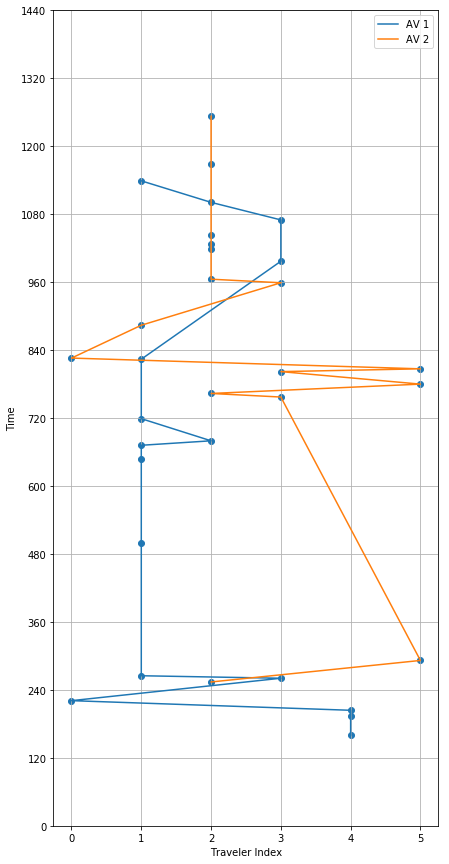

In [41]:
# 2AV
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions,sorted_trips,num_cav,Vehicular_Skim_Dict,superzone_map)

32
num_cav_trips 50
num_occupied_trips 32
num_unoccupied_trips 18
num_pickup_trips 32
num_shared_trips 0
num_convention car trips 32
total_convention_vehicle_driving_time 2.4550000000000005
total_AV_driving_time 3.726666666666666
total_AV_unoccupied_driving_time 1.2716666666666667
total_convention_vehicle_driving_distance 261.989
total_AV_driving_distance 398.4389999999999
total_AV_unoccupied_driving_distance 136.45000000000002
total_reward 5100.0
total_schedule_penalty 7.853999999999986
total_travel_cost 461.7729499999999
reward_mode 2
drivingcost_per_mile 1
share_ride_factor 1
run_mode 0
num_cav 1
cav_use_mode 1
time_window_flag 0


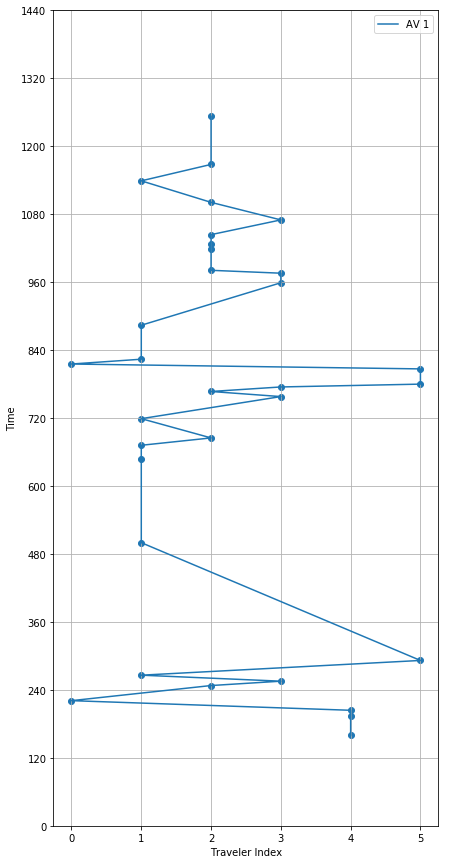

In [31]:
# CAV 1
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions,sorted_trips,num_cav,Vehicular_Skim_Dict,superzone_map)

32
num_cav_trips 50
num_occupied_trips 39
num_unoccupied_trips 11
num_pickup_trips 32
num_shared_trips 6
num_convention car trips 32
total_convention_vehicle_driving_time 2.4550000000000005
total_AV_driving_time 3.588333333333333
total_AV_unoccupied_driving_time 0.735
total_convention_vehicle_driving_distance 261.989
total_AV_driving_distance 385.445
total_AV_unoccupied_driving_distance 80.05499999999999
total_reward 5100.0
total_schedule_penalty 3.2790000000000337
total_travel_cost 445.90859999999986
reward_mode 2
drivingcost_per_mile 1
share_ride_factor 10
run_mode 0
num_cav 1
cav_use_mode 1
time_window_flag 0


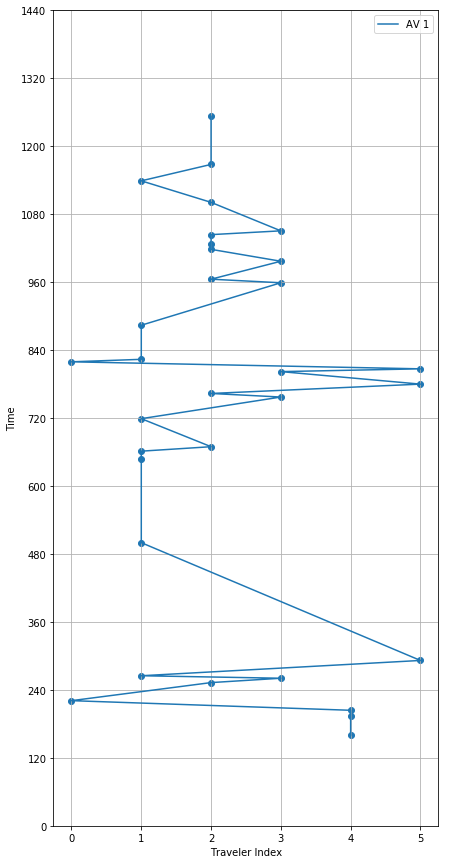

In [29]:
# CAV 1.5
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions,sorted_trips,num_cav,Vehicular_Skim_Dict,superzone_map)

In [49]:
sorted_trips.person_id.unique()

array([5983411, 5983412, 5983407, 5983409, 5983410, 5983408], dtype=int64)

45
num_cav_trips 37
num_occupied_trips 26
num_unoccupied_trips 11
num_pickup_trips 23
num_shared_trips 3
num_convention car trips 32
total_convention_vehicle_driving_time 2.4550000000000005
total_AV_driving_time 2.65
total_AV_unoccupied_driving_time 0.8683333333333335
total_convention_vehicle_driving_distance 261.989
total_AV_driving_distance 284.30699999999996
total_AV_unoccupied_driving_distance 88.315
total_reward 5350.425675568381
total_schedule_penalty 1.1251999999999989
total_travel_cost 160.7625
reward_mode 1
drivingcost_per_mile 0.5
share_ride_factor 8
run_mode 0
num_cav 1
cav_use_mode 1
time_window_flag 0


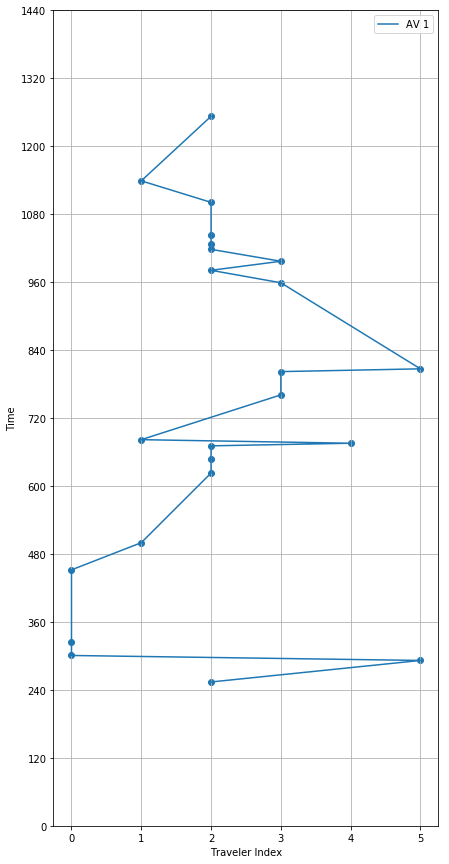

In [45]:
# Transit mode
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions,sorted_trips,num_cav,Vehicular_Skim_Dict,superzone_map)

45
num_cav_trips 38
num_occupied_trips 27
num_unoccupied_trips 11
num_pickup_trips 23
num_shared_trips 4
num_convention car trips 32
total_convention_vehicle_driving_time 2.4550000000000005
total_AV_driving_time 2.7233333333333336
total_AV_unoccupied_driving_time 0.8683333333333335
total_convention_vehicle_driving_distance 261.989
total_AV_driving_distance 292.839
total_AV_unoccupied_driving_distance 88.315
total_reward 5350.425675568381
total_schedule_penalty 1.1171999999999984
total_travel_cost 159.62279999999998
reward_mode 1
drivingcost_per_mile 0.5
share_ride_factor 8
run_mode 0
num_cav 1
cav_use_mode 1
time_window_flag 0


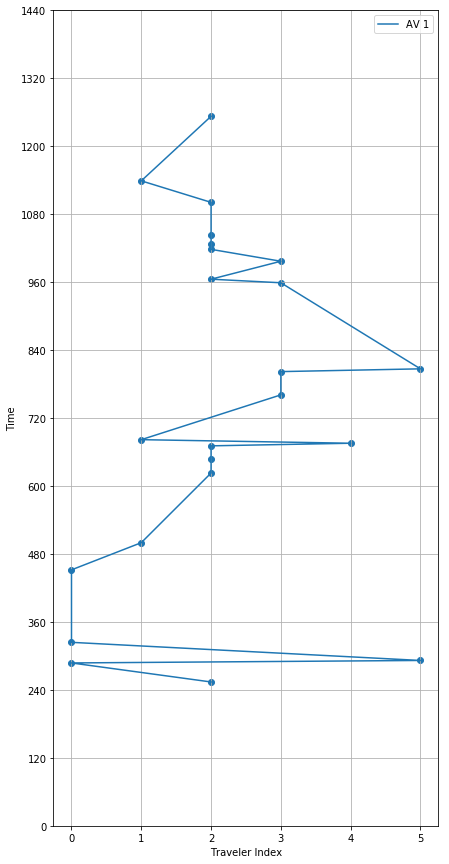

In [48]:
# Transit mode 2
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions,sorted_trips,num_cav,Vehicular_Skim_Dict,superzone_map)

In [ ]:
sod.move_neighborhood(x_sol,T_sol,initial_route_info,hh_num_trips,
                      num_cav,shake_size,Vehicular_Skim_Dict)

In [ ]:
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone\
    =prd.extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,drivingcost_per_mile,num_time_interval)

In [ ]:
print(datetime.datetime.now())
m3,T,S=sod.optimal_start_time(sorted_trips,x_sol[:,:,0],T_sol,hh_num_trips,expected_arrival_time,Vehicular_Skim_Dict,visit_candidate_zone,
    early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,superzone_map)
print(datetime.datetime.now())

# Solve for all households car trips only

##### Compare the exact method and schedule method for one household

In [47]:
output_flag=1
target_hh_id=364652
min_length=15
max_length=20
single_model_runtime=60*2
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=5
share_ride_factor=1.5
time_window_flag=0
print(datetime.datetime.now())
# route_info1=sod.find_av_schedule_exact_method(target_hh_id,traveler_trips.loc[traveler_trips.tripmode<=6],output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
#                          reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
#                          ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU)
# print(datetime.datetime.now())
# target_hh=traveler_trips[(traveler_trips['hh_id']==target_hh_id) &(traveler_trips.tripmode<=6)]\
#         .drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
#                                  'starttime','joint_trip_flag'])
# #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
# sorted_trips=target_hh.sort_values("starttime")

target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

community_hh_list=[972044,972024,2212041,2212030,937968,2285653,1309779,1738127,2034377,2066988]
community_trips=pd.DataFrame()
for hh_id in community_hh_list:
#     print(len(target_trips[target_trips.hh_id==hh_id]))
    community_trips=community_trips.append(target_trips[target_trips.hh_id==hh_id])
sorted_trips=community_trips.sort_values('starttime')
hh_num_trips=sorted_trips.shape[0]

sorted_trips["hh_index"]=(range(hh_num_trips))
print(datetime.datetime.now())
darp_solution2=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                                    superzone_map,min_length,max_length,reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU,transit_zone_dict,transit_zone_candidates,
                                    TransitMazTazFlag,TransitSkimTimeIntervalLength)
print(datetime.datetime.now())

2018-07-15 19:43:12.365548
2018-07-15 19:43:12.700564
17 [2034377  972024 2212041  937968 2285653 2212030 1309779 1738127 2066988] 17
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 120.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 9255 rows, 6552 columns and 53230 nonzeros
Variable types: 72 continuous, 6480 integer (6480 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint FromDepot2[0,1] by 1.000000000

Presolve removed 4107 rows and 2260 columns
Presolve time: 0.18s
Presolved: 5148 rows, 4292 columns, 34512 nonzeros
Variable types: 72 continuous, 4220 integer (4220 binary)
Found heuristic solutio

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 11573 rows, 8080 columns and 70040 nonzeros
Variable types: 80 continuous, 8000 integer (8000 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint FromDepot2[0,1] by 1.000000000

Found heuristic solution: objective -338298.5620
Presolve removed 5424 rows and 2990 columns
Presolve time: 0.29s
Presolved: 6149 rows, 5090 columns, 43901 nonzeros
Variable types: 80 continuous, 5010 integer (5010 binary)

Root relaxation: objective 1.451445e+04, 2276 iterations, 0.36 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14514.4482    0  105 -338298.56 14514.4482  


Found heuristic solution: objective -378807.8900
Presolve removed 3856 rows and 2120 columns
Presolve time: 0.20s
Presolved: 6032 rows, 5176 columns, 42705 nonzeros
Variable types: 76 continuous, 5100 integer (5100 binary)

Root relaxation: objective 1.916428e+04, 2373 iterations, 0.34 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19164.2797    0  106 -378807.89 19164.2797   105%     -    1s
H    0     0                    -150.0500000 19164.2797      -     -    1s
     0     0 19164.2797    0  243 -150.05000 19164.2797      -     -    3s
     0     0 19164.2797    0  244 -150.05000 19164.2797      -     -    3s
     0     0 19164.2797    0  165 -150.05000 19164.2797      -     -    5s
     0     0 19164.2797    0  223 -150.05000 19164.2797      -     -    5s
H    0     0                    1284.5919600 19164.2797  1392%     -    6s
     0     0 19164.2797    

     0     0 18202.0581    0  271 7908.52656 18202.0581   130%     -    6s
H    0     0                    12177.298898 18202.0581  49.5%     -    6s
     0     0 18202.0365    0  269 12177.2989 18202.0365  49.5%     -    6s
     0     0 18202.0215    0  242 12177.2989 18202.0215  49.5%     -    6s
     0     0 18202.0182    0  258 12177.2989 18202.0182  49.5%     -    6s
     0     0 18201.7234    0  292 12177.2989 18201.7234  49.5%     -    7s
     0     0 18201.7134    0  301 12177.2989 18201.7134  49.5%     -    7s
     0     0 18201.7100    0  306 12177.2989 18201.7100  49.5%     -    7s
     0     0 18201.6975    0  316 12177.2989 18201.6975  49.5%     -    7s
     0     0 18201.6834    0  324 12177.2989 18201.6834  49.5%     -    8s
     0     0 18201.6818    0  329 12177.2989 18201.6818  49.5%     -    8s
H    0     0                    12208.429181 18201.6818  49.1%     -    8s
     0     0 18201.6666    0  330 12208.4292 18201.6666  49.1%     -    8s
     0     0 18201.6666  

     0     0 15980.3326    0  212 1760.82893 15980.3326   808%     -    3s
     0     0 15980.3326    0  208 1760.82893 15980.3326   808%     -    4s
     0     0 15980.3326    0  226 1760.82893 15980.3326   808%     -    4s
     0     0 15980.3326    0  217 1760.82893 15980.3326   808%     -    4s
     0     0 15980.3326    0  138 1760.82893 15980.3326   808%     -    5s
     0     0 15980.3326    0  167 1760.82893 15980.3326   808%     -    5s
     0     0 15980.3326    0  159 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  184 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  161 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  191 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  154 1760.82893 15980.3326   808%     -    7s
     0     0 15980.3326    0  154 1760.82893 15980.3326   808%     -    7s
     0     2 15980.3326    0  154 1760.82893 15980.3326   808%     -    8s
    31    37 15979.9837  

H    0     0                    8761.8550660 16856.2381  92.4%     -    6s
     0     0 16855.4893    0  156 8761.85507 16855.4893  92.4%     -    6s
     0     0 16855.3170    0  167 8761.85507 16855.3170  92.4%     -    6s
     0     0 16855.2598    0  164 8761.85507 16855.2598  92.4%     -    6s
     0     0 16855.2225    0  181 8761.85507 16855.2225  92.4%     -    6s
     0     0 16855.2219    0  197 8761.85507 16855.2219  92.4%     -    6s
H    0     0                    8762.1310660 16855.2219  92.4%     -    6s
     0     0 16854.1066    0  221 8762.13107 16854.1066  92.4%     -    6s
     0     0 16853.8867    0  219 8762.13107 16853.8867  92.3%     -    6s
     0     0 16853.7882    0  220 8762.13107 16853.7882  92.3%     -    7s
     0     0 16853.7812    0  232 8762.13107 16853.7812  92.3%     -    7s
     0     0 16853.7795    0  230 8762.13107 16853.7795  92.3%     -    7s
     0     0 16852.9790    0  237 8762.13107 16852.9790  92.3%     -    7s
H    0     0             

[3260909 3260908 3260903 3260792 3260786 3260784 3260791 3260785 7511986
 7511987 7511929 7511928 3065366 3065367 7923628 7923630 7923627 7923631
 4197661 4197662 5983094 5983093 5983092 6823741 6823742 6925729 6925730]


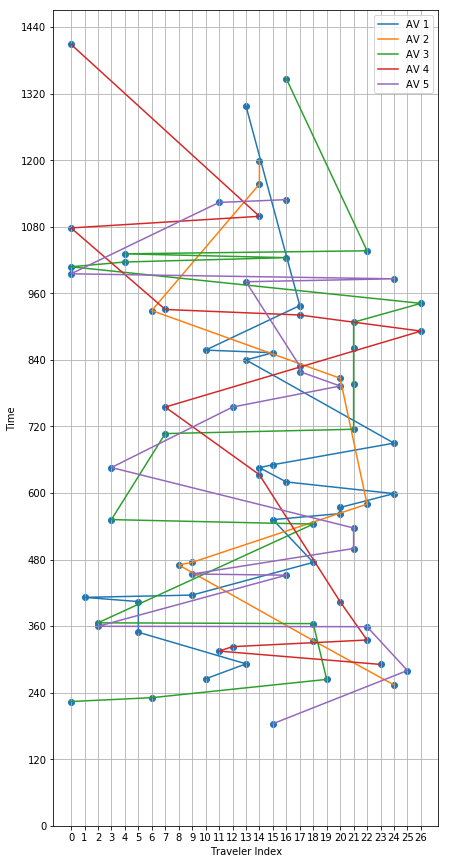

In [48]:
pod.plot_route_info_schedule(darp_solution2['route_info'],community_trips,num_cav)

In [49]:
community_route_info=darp_solution2['route_info']

In [50]:
community_route_info[community_route_info.hh_vehicle_id==1]

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index,p_id
0,7,5,5,111,7923628,254.0,259.9,259.9,0.1249,254.0,4.1,2034377.0,1.0,0,0,2034377.0_0_1.0,24
1,5,7,111,16,0,259.9,334.0,334.0,0.0100,264.0,0.0,2034377.0,1.0,0,1,2034377.0_1_1.0,-1
2,7,17,16,122,6925730,334.0,339.3,339.3,0.0432,334.0,0.0,2034377.0,1.0,0,2,2034377.0_2_1.0,18
0,7,5,33,139,3260908,470.3,474.5,494.2,0.0318,490.0,3.8,972024.0,1.0,0,0,972024.0_0_1.0,8
1,5,2,139,32,0,474.5,475.0,475.0,0.0100,498.0,0.0,972024.0,1.0,0,1,972024.0_1_1.0,-1
2,2,7,32,138,3260909,475.0,479.0,479.0,0.0318,475.0,11.0,972024.0,1.0,0,2,972024.0_2_1.0,9
0,7,17,46,152,7511987,580.0,584.8,584.8,0.1373,580.0,6.2,2212041.0,1.0,0,0,2212041.0_0_1.0,22
0,11,7,68,174,7511929,807.0,808.4,808.4,0.1470,807.0,2.6,1738127.0,1.0,0,0,1738127.0_0_1.0,20
0,12,7,83,189,3260792,929.0,930.6,930.6,0.1509,929.0,0.4,1309779.0,1.0,0,0,1309779.0_0_1.0,6
0,2,13,101,207,5983094,1157.0,1161.1,1161.1,0.1585,1157.0,37.9,937968.0,1.0,0,0,937968.0_0_1.0,14


In [ ]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

route_info_allcartrips15,darp_solutions_allcartrips_temp15=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU,transit_zone_dict)

In [ ]:
import pickle
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_allcartrips15.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_allcartrips_temp15,'darp_solutions',output_filepath)

In [ ]:
darp_solutions_allcartrips_temp15

In [ ]:

if not os.path.exists(route_info_path):
    os.makedirs(route_info_path)
route_info_allcartrips15.to_csv(route_info_path+'route_info.csv')

vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
dtd.route_to_vehiclepathdat(route_info_allcartrips,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
allcar_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
allcar_target_trips=allcar_target_trips[(allcar_target_trips.orig_taz!=allcar_target_trips.dest_taz) 
                                        | (allcar_target_trips.trip_counter==1)]
allcar_target_trips.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                                 'starttime','joint_trip_flag','hh_id'],inplace=True)

In [ ]:
target_solution

In [ ]:
i=0
target_hh_id=241508
for solution in darp_solutions_allcartrips_temp15:
#     print(i)
    if not solution['route_info'].hh_id.empty:
#     print(solution['route_info'].hh_id.iloc[0])
        temp=solution['route_info'].hh_id.iloc[0]
        if (temp)==(target_hh_id):
            target_solution=solution
#     i=i+1

pod.plot_route_info_schedule(target_solution['route_info'],
                             allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],num_cav)

In [ ]:
pod.analysis_result(target_solution,allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],Vehicular_Skim_Dict,superzone_map)

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])
value_of_time_discount_factor=0.9
target_trips['value_of_time']=target_trips['value_of_time']*value_of_time_discount_factor

route_info_modechioce09,darp_solutions_modechoice09=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

In [ ]:
run_name='modechoice09/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_modechioce09.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_modechoice09,'darp_solutions',output_filepath)
vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'

z=route_info_modechioce09
external_vehicle_filepath='Input/external_vehicle50.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath+'external50/'
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
z=dtd.preprocess_routeinfo_for_vehicledat(z)
dtd.route_to_vehiclepathdat(z,origin_links,output_filepath,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_modechoice08,darp_solutions_modechoice08=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
single_model_runtime=60*5
drivingcost_per_mile=1
reward_mode=0
darp_solutions1=[]
cav_use_mode=1
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

# for num_cav in [2]: #range(1,4):
#     for share_ride_factor in [1]: #[1,1.25,1.5]:
#         for time_window_flag in [0]:
num_cav=2
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions1.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                            reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                          cav_use_mode,time_window_flag,single_model_runtime)])

In [ ]:
#!/usr/bin/env python
import random
import pylab
from matplotlib.pyplot import pause

pylab.ion()
Gnormal=nx.Graph()
color_map=[]
for i in node_detail:
    color_map.append('blue')
# nx.draw_networkx_nodes(Gnormal, pos,node_list=[1,2,4],node_color='red',node_size=4)
def get_fig():
    global color_map
    for nodeinf in node_detail:
        node=nodeinf[0,0]
        Gnormal.add_node(node,pos=(nodexy[node][0],nodexy[node][1]))
    for linkinf in link_detail: 
        Gnormal.add_edge(linkinf[0,0],linkinf[0,1])

    pos=nx.get_node_attributes(Gnormal,'pos')
    nx.draw(Gnormal,pos,node_size=10,node_color=color_map )
num_plots = 50;
pylab.show()
for i in range(num_plots):
    color_map[i]='red'
    get_fig()
    pylab.draw()
    pause(2)

In [ ]:
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]

In [ ]:
analyzed_results4=pd.DataFrame()
for solution in darp_solutions4:
        analyzed_results4=analyzed_results4.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_time'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
sorted_trips.head()

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_distance'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
analyzed_results.columns

In [ ]:
analyzed_results4

In [ ]:
len(darp_solutions4[0]['route_info'])

In [ ]:
analyzed_results4.loc[analyzed_results4.share_ride_factor==1].transpose()

In [ ]:
zz.hh_vehicle_id.unique()

In [ ]:
for i in range(3):
    print(len(zz.loc[zz.hh_vehicle_id==i]))

In [ ]:
zz=darp_solutions4[-1]['route_info']
# zz=darp_solutions4[5]['route_info']
# zz['origin_network_node','dest_network_node']=zz.apply(lambda row: dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
for car_id in range(3):
    nodes=[]
    for index, row in zz.loc[zz.hh_vehicle_id==car_id].iterrows():
        nodes.extend(dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
    av.zone_node_highlight(nodes,node_detail,link_detail,nodexy,'r')

In [ ]:
darp_solutions4[-1]['route_info'].head()

In [ ]:
pod.plot_route_info_schedule(darp_solutions4[-1]['route_info'],sorted_trips,3)

In [ ]:
analyzed_results4.columns

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_schedule_penalty'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor')
plt.pyplot.ylabel('Total Late/Early Arrival')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,'Total_early_time'].apply(lambda x: abs(x))+analyzed_results4.loc[analyzed_results4.num_cav==i,'total_delayed_time'].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_travel_cost'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor ')
plt.pyplot.ylabel('Total Generalized Travel Cost')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
len(darp_solutions4[-1]['route_info'])

In [ ]:
for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
    plt.pyplot.figure()
    plt.pyplot.xlabel('share ride factor')
    plt.pyplot.ylabel(factor)
    for i in range(1,4):
        line_label=str(i)+' Cav'
        plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
    plt.pyplot.legend()

In [ ]:
for i in darp_solutions:
    print(i['num_cav'],i['share_ride_factor'])

In [ ]:

route_info.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
route_info.apply(lambda row:prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile) ,axis=1).sum()

In [ ]:
from Modules import Preprocess_DARP as prd

In [ ]:
for j in [2,5,8] :   
    z=darp_solutions4[j]['route_info']
    for i in range(3):
        zz=z.loc[z.hh_vehicle_id==i]
        if len(zz)>0:
            total_driving_time_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
            total_driving_distance_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile),axis=1).sum()
            num_pickup_trips=len(zz.loc[zz.orig_node_index<=len(sorted_trips)])
            print(i,j,len(zz),num_pickup_trips,total_driving_time_temp,total_driving_distance_temp)

In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions4[2]['route_info'],sorted_trips,darp_solutions4[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions4[5]['route_info'],sorted_trips,darp_solutions4[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions4[8]['route_info'],sorted_trips,darp_solutions4[8]['num_cav'])



In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions[2]['route_info'],sorted_trips,darp_solutions[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions[5]['route_info'],sorted_trips,darp_solutions[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions[8]['route_info'],sorted_trips,darp_solutions[8]['num_cav'])


In [ ]:
Vehicular_Skim.loc[18,15,1,1]

In [ ]:
zz1=solution['route_info']

In [ ]:
zz1.dest_zone=zz1.dest_zone.apply(lambda x: int(x))

In [ ]:
analyzed_results3=pd.DataFrame()
for solution in darp_solutions3:
    analyzed_results3=analyzed_results3.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results3.transpose().to_csv('Output/hh_level_result3.csv')

In [ ]:
analyzed_results.transpose().to_csv('hh_level_result.csv')

In [ ]:
analyzed_results.transpose()

### Basic Statistics

In [ ]:
traveler_trips.head()

In [ ]:
traveler_trips.columns

In [ ]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

In [ ]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

In [ ]:
traveler_trips.tripmode.hist()

In [ ]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

In [ ]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

### Sample Household
Select household 2287301 for intial analysis

In [ ]:
target_hh_id=2287301
people_in_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

#### Solve with heuristic

## Estimate travel time and cost

## Solve the optimization with Gurobi

In [ ]:
drivingcost_per_mile=1
transit_fare=2
transit_asc=2

##### Try to solve the problem for a single household

#### Solve with exact method

In [ ]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode=)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())
route_info.to_csv('route_info_yingjie.csv')

In [ ]:
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
#     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
    T_sol[i]=T[i].x
schedule_deviation=T_sol-expected_arrival_time
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,schedule_deviation)

#### Solve with the schedule partition heuristic

In [ ]:
def analysis_result(route_info,sorted_trips,Vehicular_Skim,schedule_deviation):
    print('Number of CAV Trips',len(route_info))
    print('Number of Occupied trips',len(route_info.loc[route_info.person_id>0]))
    print('Number of unoccupied trips',len(route_info.loc[route_info.person_id==0]))
    print('Number of pickup trips',len(route_info.loc[route_info.orig_node_index<=len(sorted_trips)]))
    print('Number of shared trips',len(route_info.loc[(route_info.orig_node_index<=len(sorted_trips)) &(route_info.dest_node_index<=len(sorted_trips))]))
    print('Number of convention car trips',len(sorted_trips.loc[sorted_trips.tripmode<=6]))
    # Compare the VHT between convention vehicle and CAV
    
    total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row:estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_driving_time=route_info.apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    print('Convention car trips VHT: \t',total_convention_vehicle_driving_time/60,
          '\nAV driving time: \t',total_AV_driving_time/60,
          '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time/60)
    # Compare the VMT between convention vehicle and CAV
    total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    total_AV_driving_distance=route_info.apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1) ,axis=1).sum()
    total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    print('Convention VMT: \t',total_convention_vehicle_driving_distance,
          '\nAV driving distance: \t',total_AV_driving_distance,
          '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)
    print('Number of delayed trips\t',sum(1 for i in schedule_deviation if i >1))
    print('Number of early trips\t',sum(1 for i in schedule_deviation if i <-1))
    print('Total delayed time\t',sum(i for i in schedule_deviation if i >0))
    print('Total_early_time\t',sum(i for i in schedule_deviation if i <0))
    plt.pyplot.figure(1,figsize=[2.3,10])
    plot_route_info_schedule(route_info,sorted_trips)
    return

In [ ]:
def plot_route_info_schedule(route_info,sorted_trips):
#     z=traveler_trips[traveler_trips.hh_id==route_info.hh_id[0]]
    sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
    hh_num_trips=len(sorted_trips)
    person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
    person_id_and_inhouse_p_id_map[0]=-1
    route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
    
    plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                    route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
#     plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) & (route_info.dest_node_index<1+hh_num_trips),'p_id'],
#                     route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) &(route_info.dest_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.xlabel('Traveler Index')
    plt.pyplot.ylabel('Time')
    plt.pyplot.grid()
    plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
    plt.pyplot.yticks(np.arange(0,1441,30))
#     plt.pyplot.title(title)
    return 

#### All trips take CAV

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
share_ride_factor=2
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_partition,all_trips_schedule_deviation=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation)

#### Strict time window

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=2
time_window_flag=1
num_poav=2
single_model_runtime=60*5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_stricttw,all_trips_schedule_deviation_stricttw=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_stricttw,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_stricttw)

##### Only car trips take CAV

In [ ]:
len(sorted_car_trips)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
sorted_car_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_car_trips.shape[0]
sorted_car_trips["hh_index"]=(range(hh_num_trips))
car_trips_route_info_partition,car_trips_schedule_deviation=solve_with_schedule_partition(sorted_car_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(car_trips_route_info_partition,sorted_car_trips,Vehicular_Skim,car_trips_schedule_deviation)

#### Ban Shared Rides

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_ban_sharerides,all_trips_schedule_deviation_ban_sharerides=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_ban_sharerides,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_ban_sharerides)

#### Share ride factor 1.25

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
share_ride_factor=1.25
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_sharerides125,all_trips_schedule_deviation_sharerides125=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_sharerides125,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_sharerides125)

In [ ]:
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(142)
plot_route_info_schedule(car_trips_route_info_partition,sorted_car_trips)
plt.pyplot.subplot(143)
plot_route_info_schedule(all_trips_route_info_partition,sorted_trips)
plt.pyplot.subplot(144)
plot_route_info_schedule(all_trips_route_info_ban_sharerides,sorted_trips)

#### Probability Mode Choice

In [ ]:
drivingcost_per_mile=1
transit_fare=1.4
transit_asc=2

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=1
share_ride_factor=1.5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
mode_choice_route_info,mode_choice_schedule_deviation=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
sorted_trips=compare_mode_utlity(sorted_trips)

In [ ]:
min_length=15
max_length=20
run_mode=0
share_ride_factor=1.5
force_serve_factor=1
car_sorted_trips=sorted_trips.loc[sorted_trips.expected_mode=='Car']
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
car_only_mode_choice_route_info,car_only_mode_choice_schedule_deviation=solve_with_schedule_partition(car_sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)
force_serve_factor=0

In [ ]:
sorted_trips[['transit_time','transit_walk_time','car_time','toll_cost','car_dist','transit_utility','car_utility','expected_mode','actual_mode','value_of_time']]

In [ ]:
# sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]
# sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
# route_info=pd.DataFrame()

# total_previous_sub_trips_length=0
# total_tailing_sub_trips_length=0
# schedule_deviation=[]
# x_list=[]
# for sub_sorted_trip in sub_sorted_trips:

#     num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
#     R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
#     print('start sovling problem at ',datetime.datetime.now())
#     m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
#     x_list.extend([x])
#     print('finish solving problem at ',datetime.datetime.now())
#     sub_route_info=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
#     total_tailing_sub_trips_length=len(sorted_trips)-total_previous_sub_trips_length-len(sub_sorted_trip)
#     sub_route_info['orig_node_index']=sub_route_info.orig_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     sub_route_info['dest_node_index']=sub_route_info.dest_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     total_previous_sub_trips_length=total_previous_sub_trips_length+len(sub_sorted_trip)
#     route_info=route_info.append(sub_route_info)
# #         for index, row in route_info.iterrows():
# #             print(route_info.dest_expected_arrival_time,'\t',row.dest_arrival_time,'\t',row.start_time,'\t',T[row.dest_node_index].x)
# #         #Estimate the delay and early arrival
# T_sol=np.ones(2*hh_num_trips+2)
# for i in range(2*hh_num_trips+2):
# #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
#     T_sol[i]=T[i].x
#     print(T_sol[i],expected_arrival_time[i])
# schedule_deviation.extend(T_sol-expected_arrival_time)

In [ ]:
sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
hh_num_trips=len(sorted_trips)
person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
person_id_and_inhouse_p_id_map[0]=-1
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plot_route_info_schedule(car_only_mode_choice_route_info,car_sorted_trips)
z1=[sorted_trips.iloc[i-1].p_id for i in temp3]
z2=[sorted_trips.iloc[i-1].starttime for i in temp3]
print(z1,z2)
plt.pyplot.scatter(z1,z2)

In [ ]:
analysis_result(mode_choice_route_info,sorted_trips,Vehicular_Skim,mode_choice_schedule_deviation)

In [ ]:
sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
#     route_info=pd.DataFrame()
for sub_sorted_trip in sub_sorted_trips:
#     sub_sorted_trip=sub_sorted_trips[1]
    num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    # R=np.ones(hh_num_trips+1)*10
    R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
    print('start sovling problem at ',datetime.datetime.now())
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode)
    print('finish solving problem at ',datetime.datetime.now())
    sub_route_info_temp=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    
    T_sol=np.ones(2*hh_num_trips+2)
    for i in range(2*hh_num_trips+2):
    #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
        T_sol[i]=T[i].x
    schedule_deviation.extend(T_sol-expected_arrival_time)
    analysis_result(sub_route_info_temp,sub_sorted_trips,Vehicular_Skim,schedule_deviation)

In [ ]:
analysis_result(sub_route_info,sub_sorted_trip,Vehicular_Skim,schedule_deviation)

In [ ]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info_partition['p_id']=route_info_partition.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])

plt.pyplot.figure(1,figsize=[21,14])
plt.pyplot.subplot(131)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(132)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(133)
plt.pyplot.scatter(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
sorted_trips=target_hh.sort_values("starttime")
sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]

In [ ]:
plot_route_info_schedule(sub_route_info,traveler_trips)

In [ ]:
sub_route_info.groupby('person_id').count()

In [ ]:
sub_sorted_trip.groupby('person_id').count()

In [ ]:
sub_route_info

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

#### Result Analysis